In [ ]:
"""
Sea Shanty Exploratory Data Analysis

This script is designed to be run in a Jupyter notebook to explore 
the musical features of sea shanties and their relationship to shanty types.
"""

# Sea Shanty Feature Analysis

This notebook explores the musical features of sea shanties extracted from MIDI files.
We'll analyze how different shanty types (Windlass & Capstan, Halliard, etc.) differ
in their musical characteristics, and look for patterns that might explain their 
functional differences.

In [56]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
import scipy.stats as stats

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# Create a directory for plots if it doesn't exist
os.makedirs('plots', exist_ok=True)

## 1. Data Loading and Initial Exploration

Let's start by loading our dataset from the CSV file and getting a basic understanding
of what we're working with.

In [58]:
# Load the data from CSV
# Update this path with your actual CSV file path
file_path = '../results/sea_shanties_analysis_20250410_233421.csv'
df_original = pd.read_csv(file_path)

# Filter out 'Unknown' shanty types
df = df_original[df_original['shanty_type'] != 'Unknown'].copy()
print(f"Filtered out {len(df_original) - len(df)} shanties with 'Unknown' type")

# Identify metadata columns vs feature columns
metadata_cols = ['filename', 'directory', 'shanty_name', 'shanty_type', 'shanty_number']
feature_cols = [col for col in df.columns if col not in metadata_cols]

print(f"Analyzing {len(df)} shanties with {len(feature_cols)} musical features")

Filtered out 93 shanties with 'Unknown' type
Analyzing 29 shanties with 17 musical features


In [59]:
# Basic dataset information
print("=== Dataset Overview ===")
print(f"Dataset shape: {df.shape}")

# View the first few rows
print("\nFirst few rows of data:")
df.head()

=== Dataset Overview ===
Dataset shape: (29, 22)

First few rows of data:


filename          directory               shanty_name  \
0    20hilo.midi  shanty_book/music  Johnny come down to Hilo   
2  22reuben.midi  shanty_book/music              Reuben Ranzo   
3   13bound.midi  shanty_book/music  Bound for the Rio Grande   
4    29haul.midi  shanty_book/music            Haul away, Joe   
5    28haul.midi  shanty_book/music            Haul away, Joe   

                 shanty_type  shanty_number  average_interval  \
0           WINDLASS CAPSTAN            4.0          2.694915   
2                   HALLIARD           22.0          2.213115   
3           WINDLASS CAPSTAN            2.0          2.239669   
4  FORE-SHEET OR SWEATING-UP           28.0          2.209302   
5  FORE-SHEET OR SWEATING-UP           28.0          2.294118   

   average_note_duration  contour_directionality  entropy_of_pitch_sequence  \
0               1.025000                0.491228                   2.558708   
2               1.026882                0.468085                   2.107920   
3               0.788934                0.448598                   2.603968   
4               0.659091                0.486486                   2.335384   
5               0.918269                0.513514                   2.437789   

   interval_complexity  ...  melodic_pattern_repetition  note_count_per_bar  \
0             2.184856  ...                    0.620690            3.157895   
2             2.100752  ...                    0.600000            3.100000   
3             2.106584  ...                    0.666667            3.588235   
4             2.341865  ...                    0.547619            4.400000   
5             2.456618  ...                    0.580000            2.600000   

   note_count_per_bar_variability  pitch_range  rest_frequency  \
0                        1.014706           12        0.268293   
2                        2.492647            9        0.215190   
3                        2.155303           13        0.024000   
4                        4.861111           10        0.153846   
5                        1.183824           12        0.409091   

   rhythm_complexity  rhythmic_pattern_repetition  score_length_in_bars  \
0           1.172254                     0.775862                    19   
2           1.886685                     0.716667                    20   
3           1.421583                     0.800000                    34   
4           2.220290                     0.642857                    10   
5           1.676737                     0.760000                    20   

   syncopation  variance_in_note_density  
0     0.033333                  2.140351  
2     0.225806                  3.884211  
3     0.491803                  2.491979  
4     0.409091                  6.711111  
5     0.500000                  2.252632  

[5 rows x 22 columns]


Shanty types distribution:
shanty_type
WINDLASS CAPSTAN             17
HALLIARD                      9
FORE-SHEET OR SWEATING-UP     2
BUNT                          1
Name: count, dtype: int64


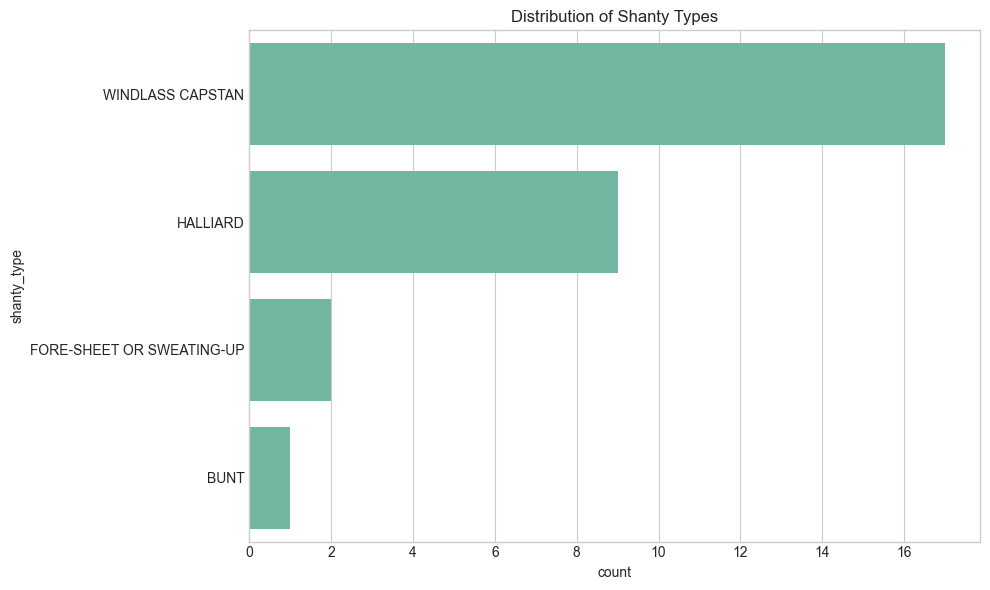

In [60]:
# Distribution of shanty types
print("\nShanty types distribution:")
type_counts = df['shanty_type'].value_counts()
print(type_counts)

# Visualize the distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='shanty_type', data=df)
plt.title('Distribution of Shanty Types')
plt.tight_layout()
plt.show()

In [61]:
# Basic statistics of the features
print("\nBasic statistics of numerical features:")
df[feature_cols].describe().T


Basic statistics of numerical features:


count       mean        std       min  \
average_interval                 29.0   2.277093   0.435396  1.465116   
average_note_duration            29.0   0.851388   0.232662  0.439498   
contour_directionality           29.0   0.485980   0.059075  0.326316   
entropy_of_pitch_sequence        29.0   2.558994   0.299095  1.967208   
interval_complexity              29.0   2.264562   0.187300  1.823019   
leap_frequency                   29.0   0.319573   0.120202  0.162791   
melodic_contour_complexity       29.0   0.402488   0.082606  0.161290   
melodic_pattern_repetition       29.0   0.600063   0.077305  0.473684   
note_count_per_bar               29.0   3.315323   0.702554  2.000000   
note_count_per_bar_variability   29.0   2.261958   1.702626  0.626894   
pitch_range                      29.0  12.379310   2.956999  7.000000   
rest_frequency                   29.0   0.169581   0.101896  0.024000   
rhythm_complexity                29.0   1.699106   0.405251  1.022630   
rhythmic_pattern_repetition      29.0   0.748522   0.078252  0.600000   
score_length_in_bars             29.0  24.034483  13.592232  9.000000   
syncopation                      29.0   0.366008   0.169612  0.033333   
variance_in_note_density         29.0   3.419051   2.013447  1.012048   

                                      25%        50%        75%        max  
average_interval                 2.049180   2.239669   2.487179   3.196078  
average_note_duration            0.679348   0.848684   1.025000   1.252976  
contour_directionality           0.458015   0.491228   0.513514   0.620690  
entropy_of_pitch_sequence        2.335384   2.611395   2.755574   3.216168  
interval_complexity              2.097161   2.280893   2.436912   2.560598  
leap_frequency                   0.225806   0.311475   0.375758   0.725490  
melodic_contour_complexity       0.358491   0.413333   0.452174   0.551020  
melodic_pattern_repetition       0.547619   0.596491   0.633333   0.768293  
note_count_per_bar               2.888889   3.222222   3.666667   4.888889  
note_count_per_bar_variability   1.014706   1.901186   2.492647   7.361111  
pitch_range                     10.000000  12.000000  14.000000  17.000000  
rest_frequency                   0.107143   0.153846   0.222222   0.414286  
rhythm_complexity                1.379423   1.676737   1.895462   2.570524  
rhythmic_pattern_repetition      0.716216   0.760000   0.800000   0.909722  
score_length_in_bars            18.000000  20.000000  25.000000  84.000000  
syncopation                      0.225806   0.406250   0.500000   0.625000  
variance_in_note_density         2.120635   2.916667   3.884211   8.647619

In [62]:
# Check for missing values
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print("\nMissing values:")
    print(missing_values[missing_values > 0])
else:
    print("\nNo missing values found in the dataset.")


No missing values found in the dataset.


## 2. Feature Distributions

Now let's examine how each musical feature is distributed across our dataset.
This will help us understand the range and typical values for each feature.

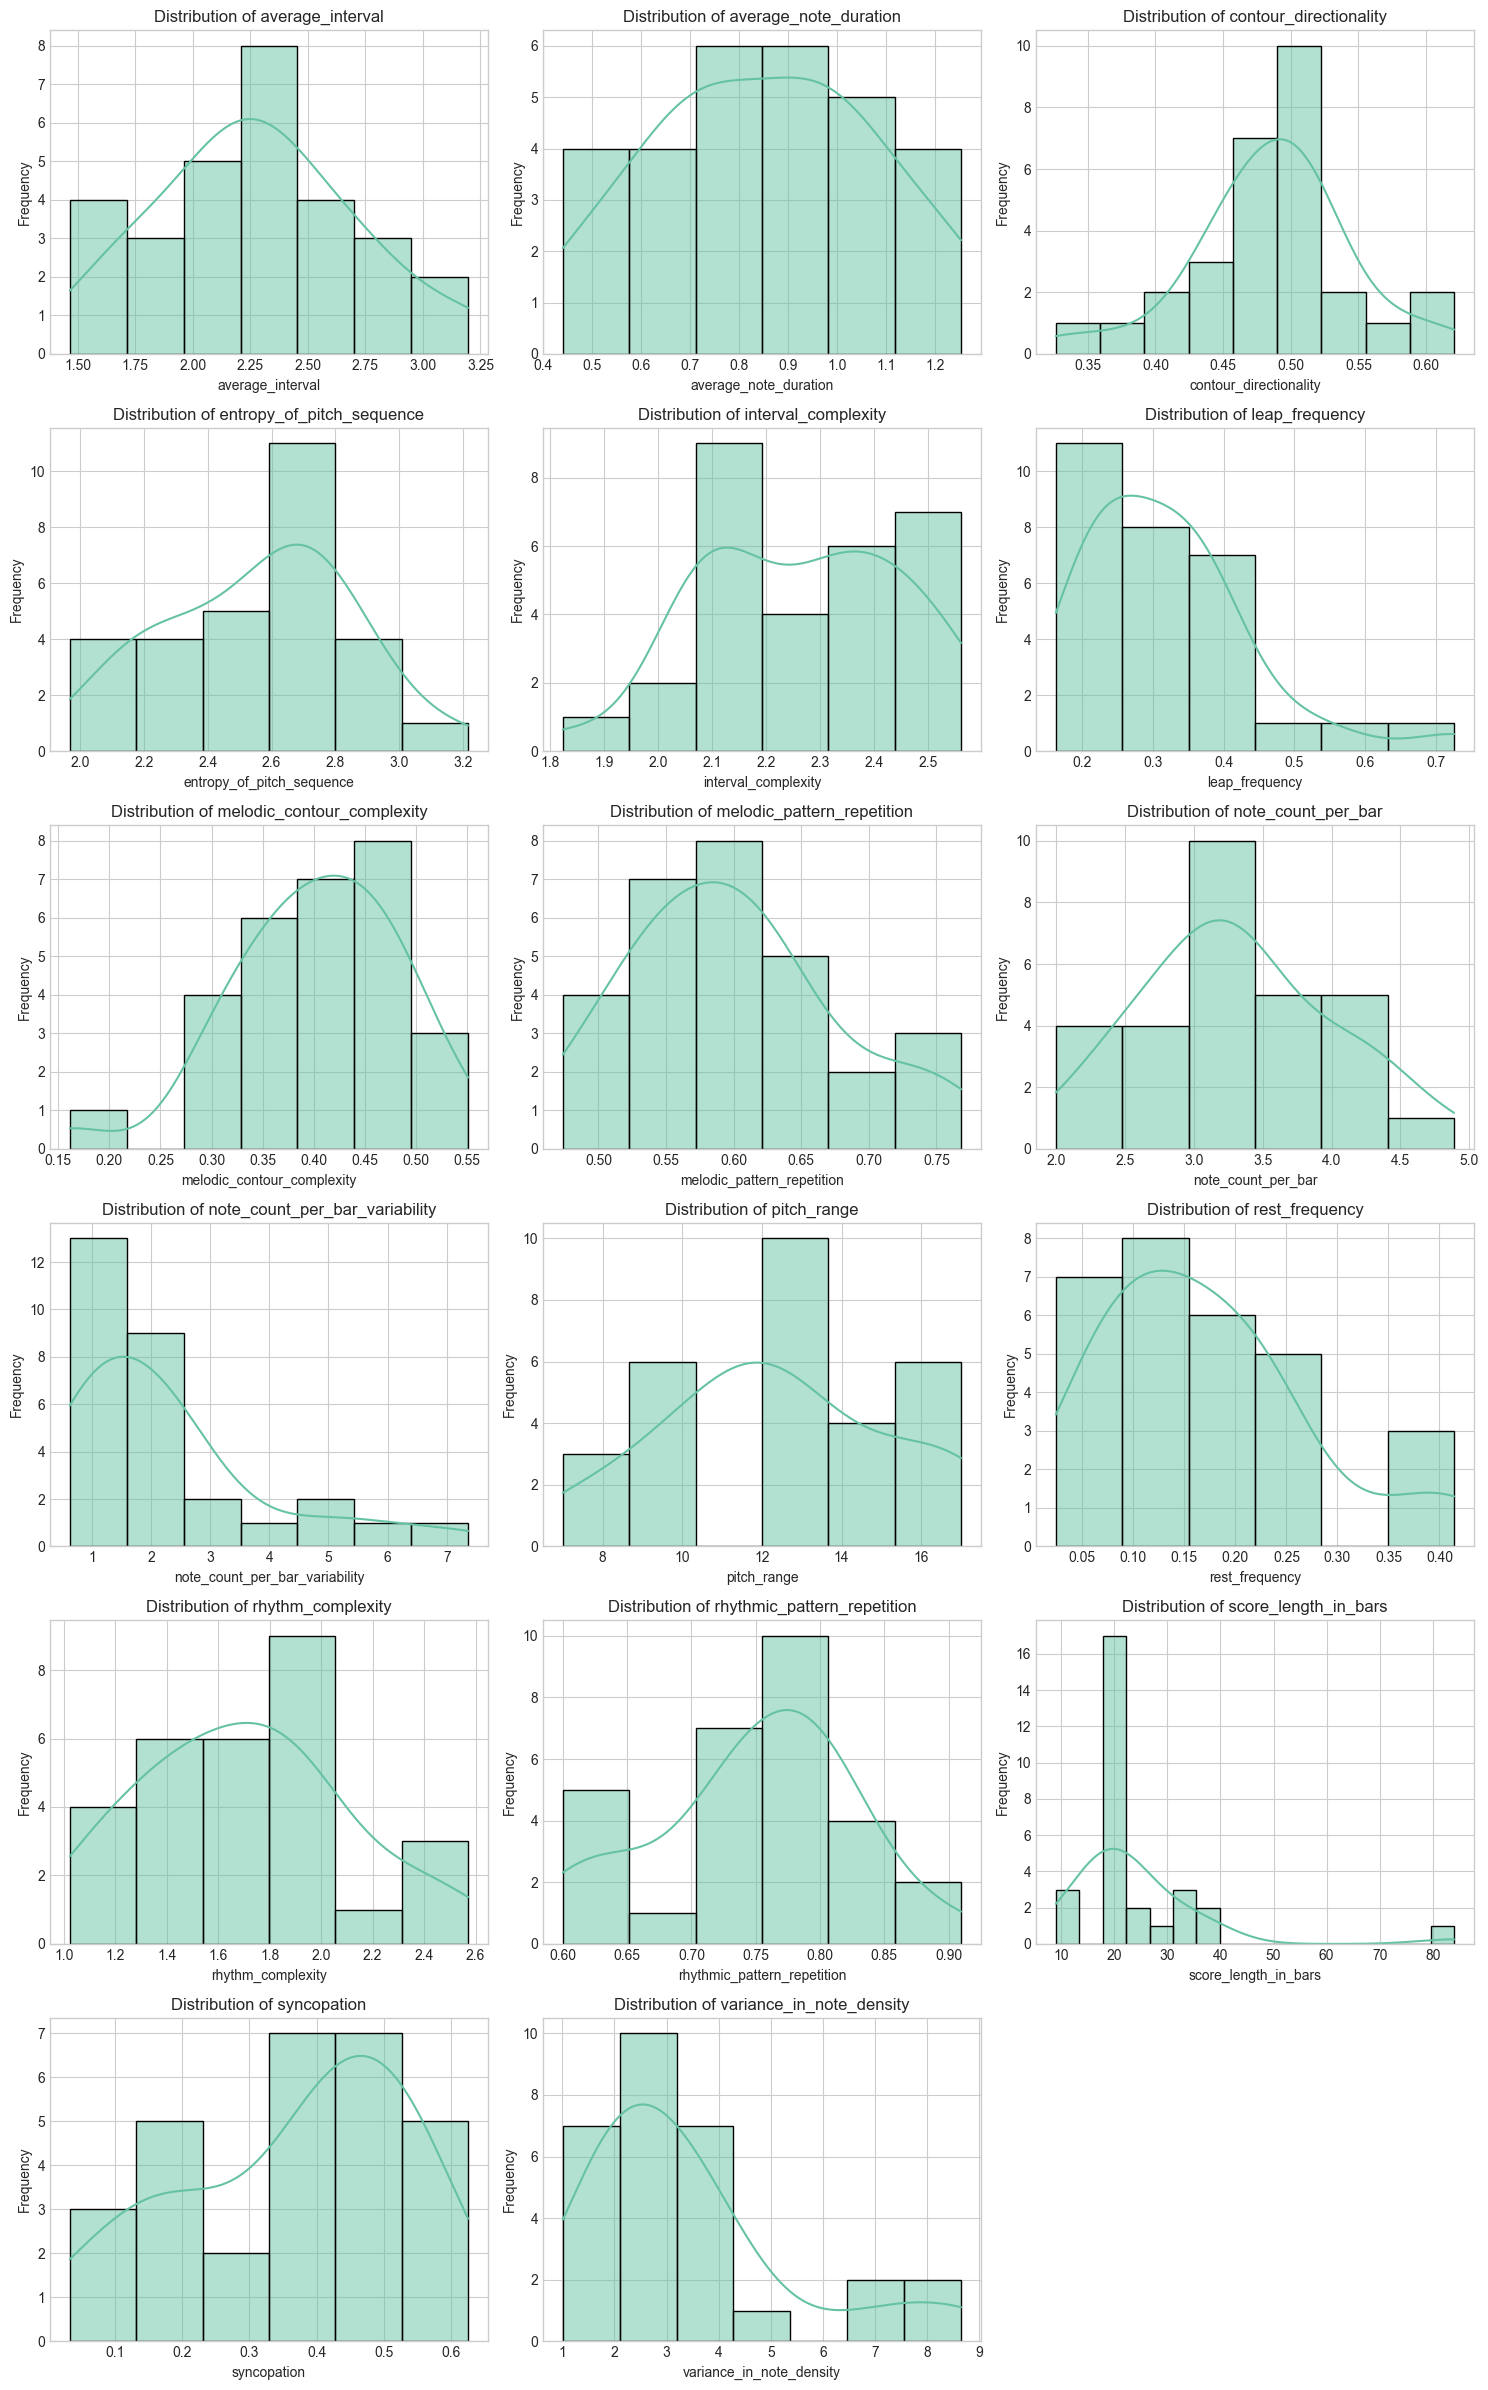

In [63]:
# Create histograms for each feature
# We'll create a grid of subplots for better organization
n_features = len(feature_cols)
n_cols = 3
n_rows = (n_features // n_cols) + (1 if n_features % n_cols > 0 else 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, feature in enumerate(feature_cols):
    if i < len(axes):
        sns.histplot(df[feature], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Save the figure for later reference
fig.savefig('plots/feature_distributions.png', dpi=300, bbox_inches='tight')

## 3. Feature Analysis by Shanty Type

Now let's examine how musical features differ between different types of shanties.
This could help us understand the musical characteristics associated with different
functional categories of shanties.

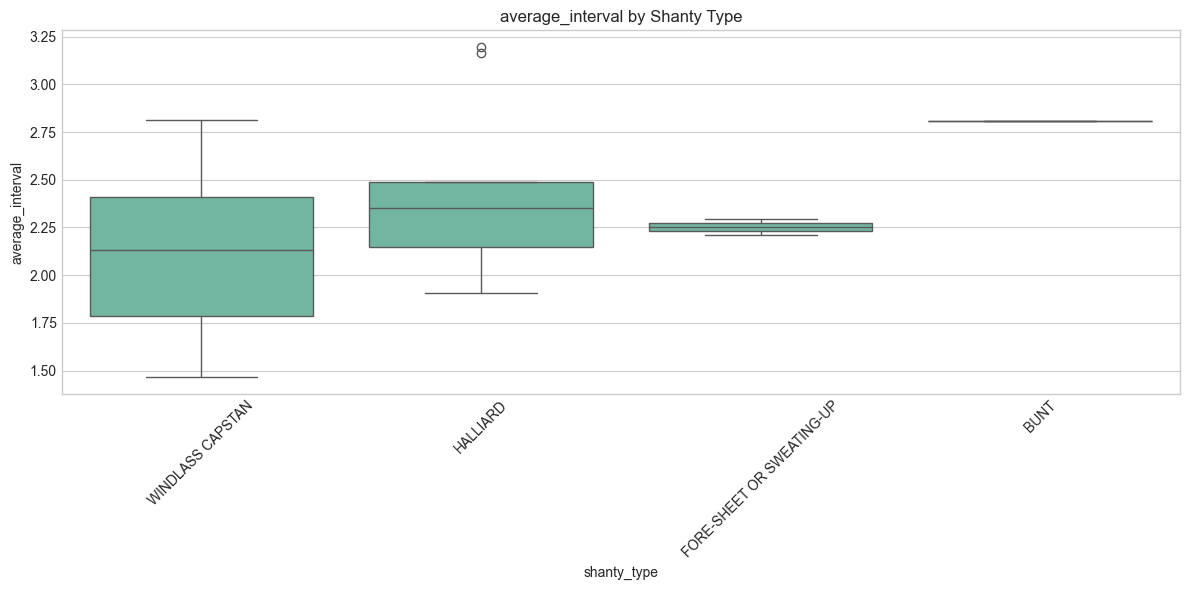

<Figure size 1200x800 with 0 Axes>

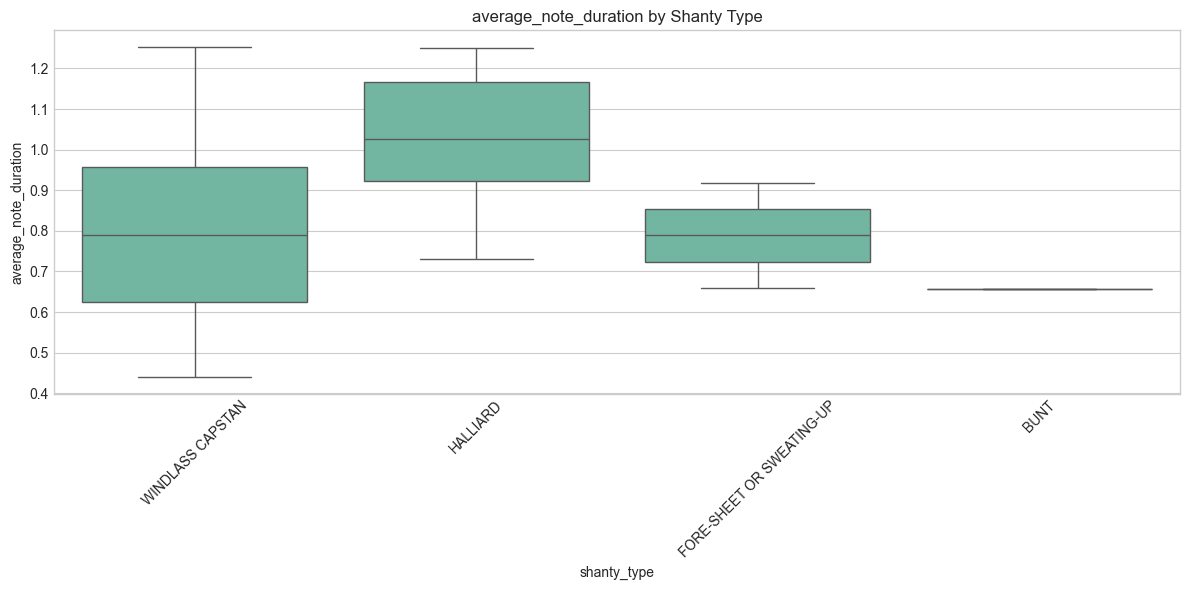

<Figure size 1200x800 with 0 Axes>

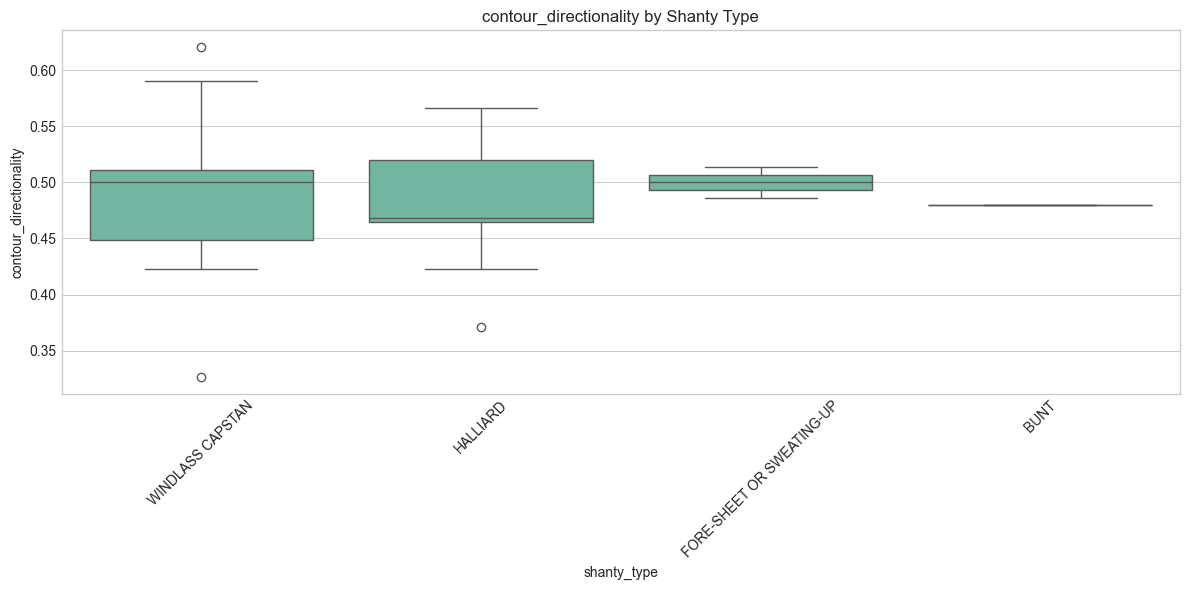

<Figure size 1200x800 with 0 Axes>

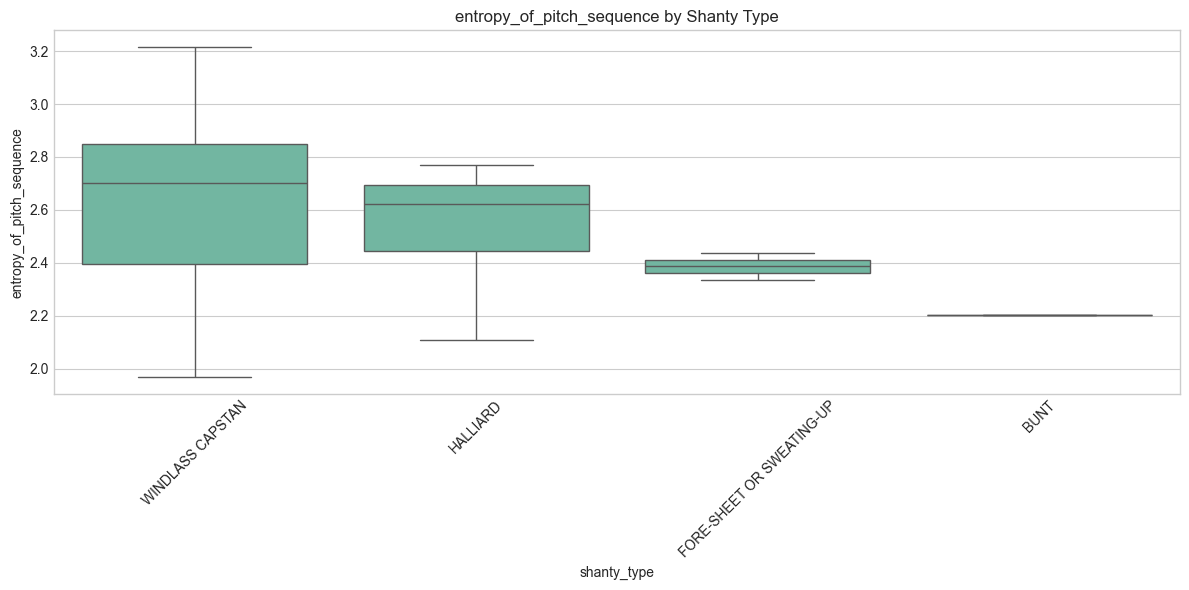

<Figure size 1200x800 with 0 Axes>

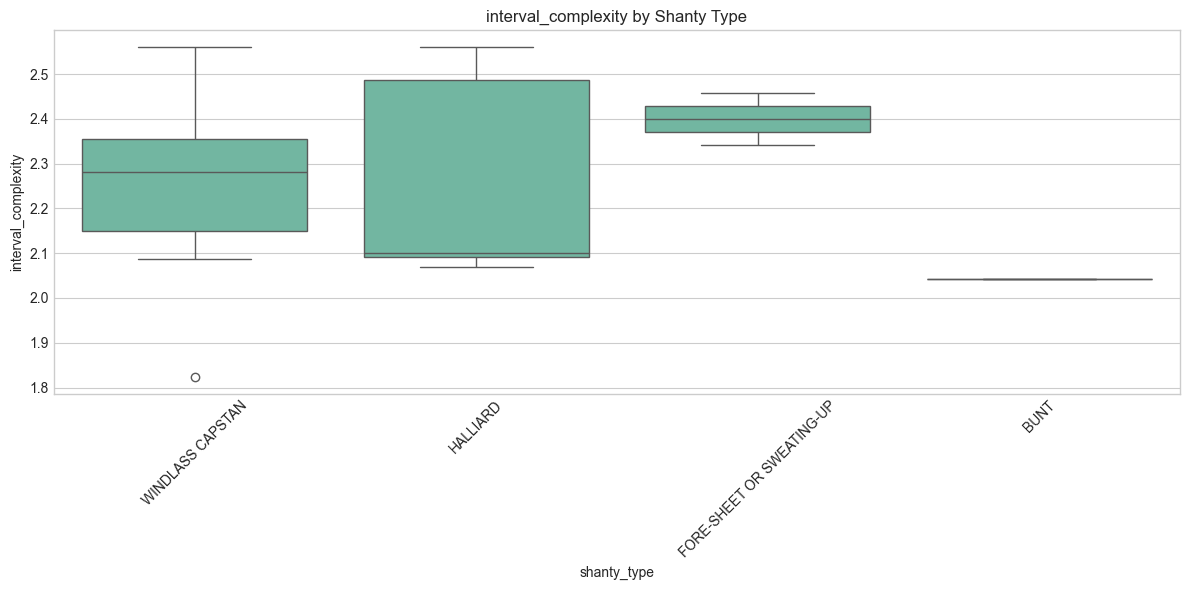

<Figure size 1200x800 with 0 Axes>

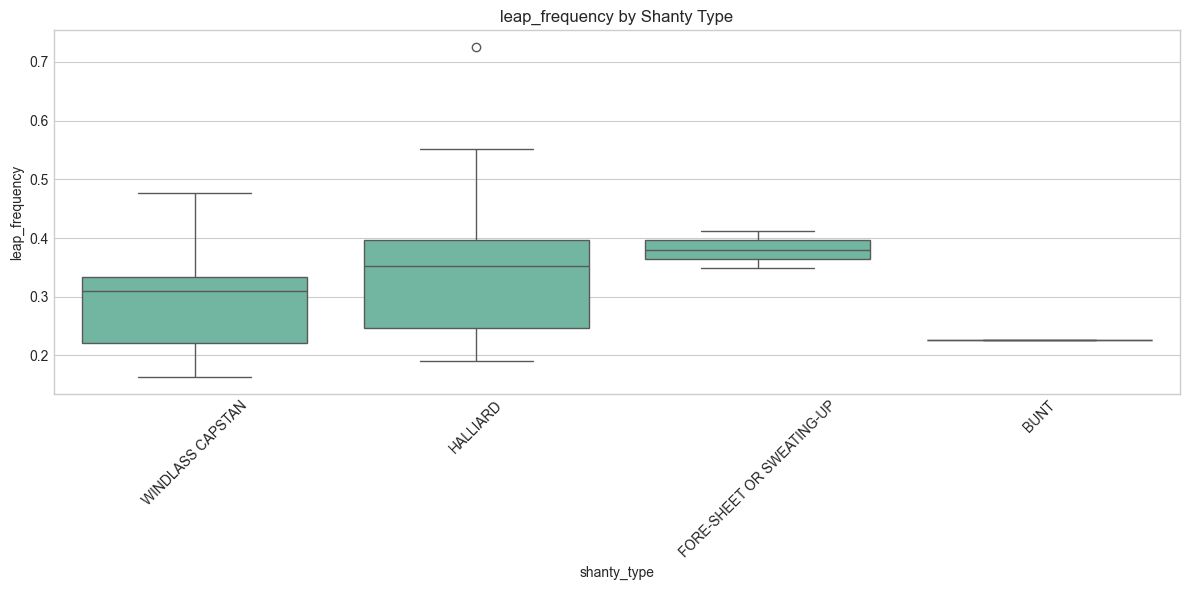

<Figure size 1200x800 with 0 Axes>

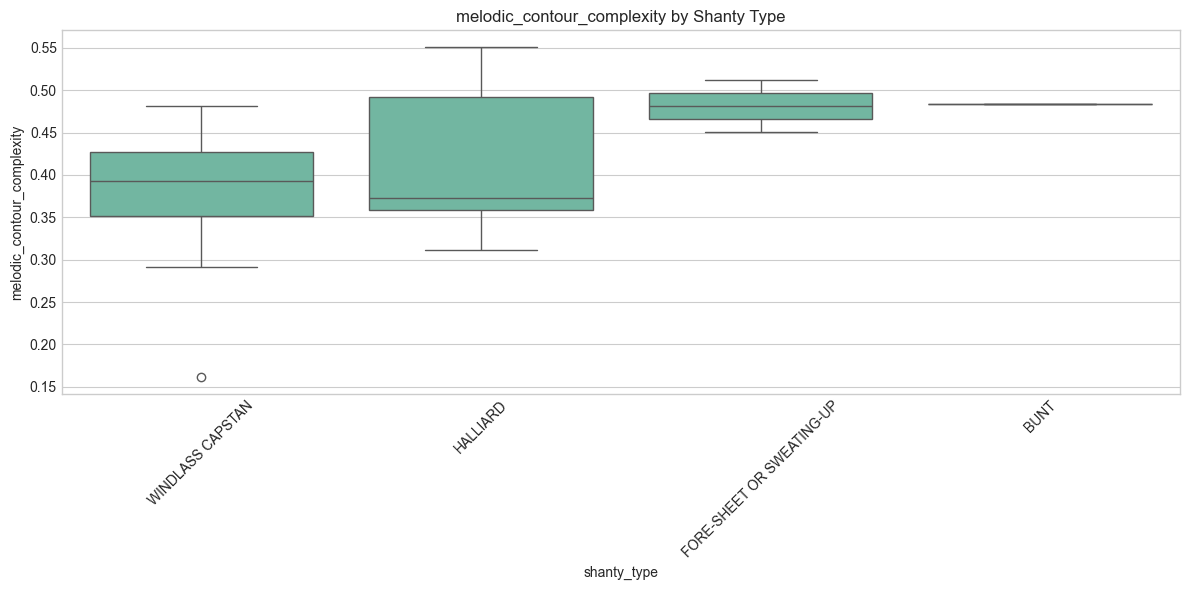

<Figure size 1200x800 with 0 Axes>

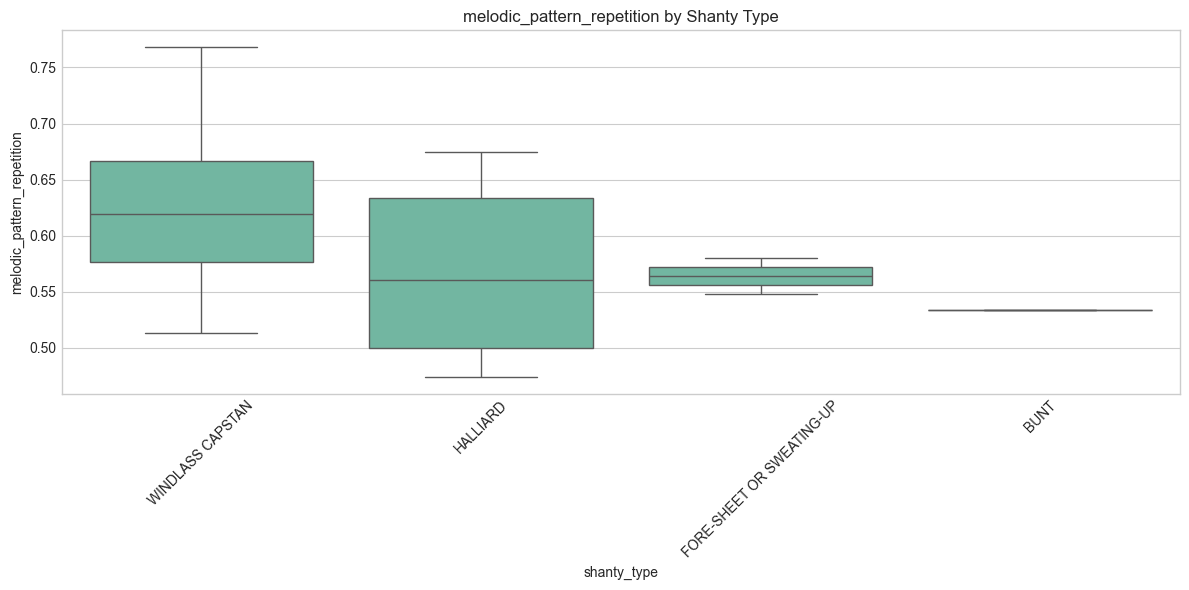

<Figure size 1200x800 with 0 Axes>

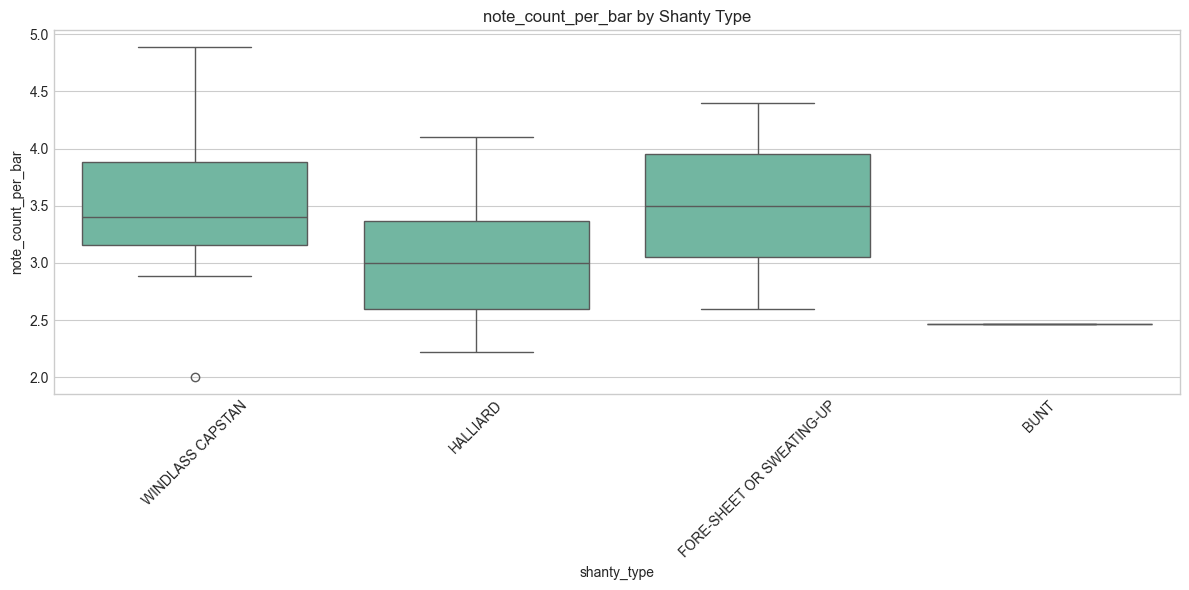

<Figure size 1200x800 with 0 Axes>

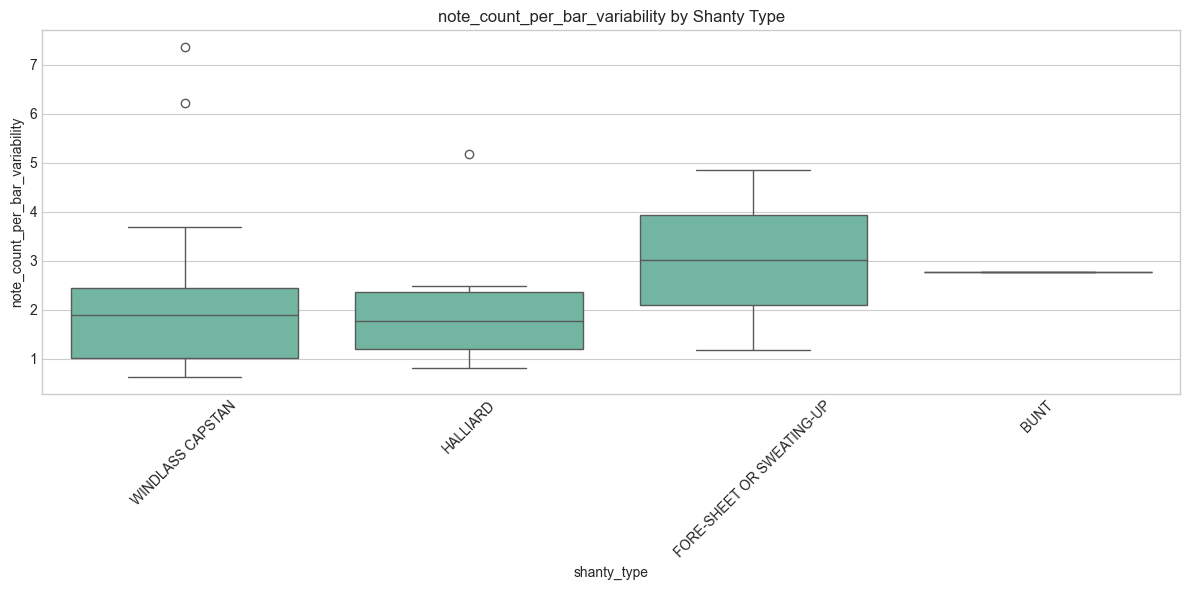

<Figure size 1200x800 with 0 Axes>

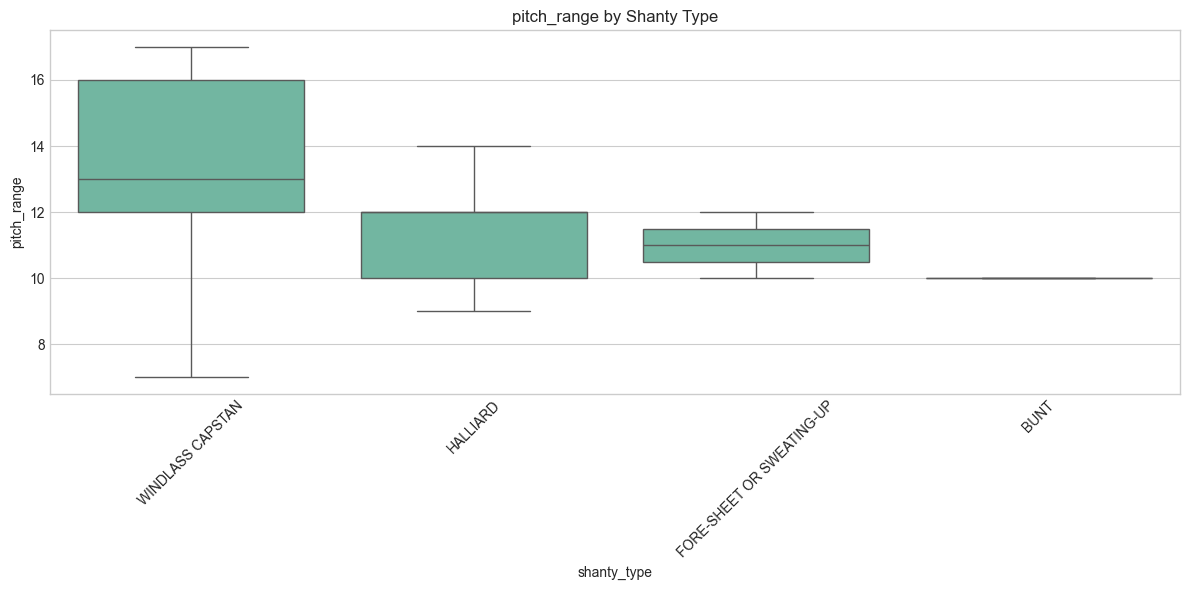

<Figure size 1200x800 with 0 Axes>

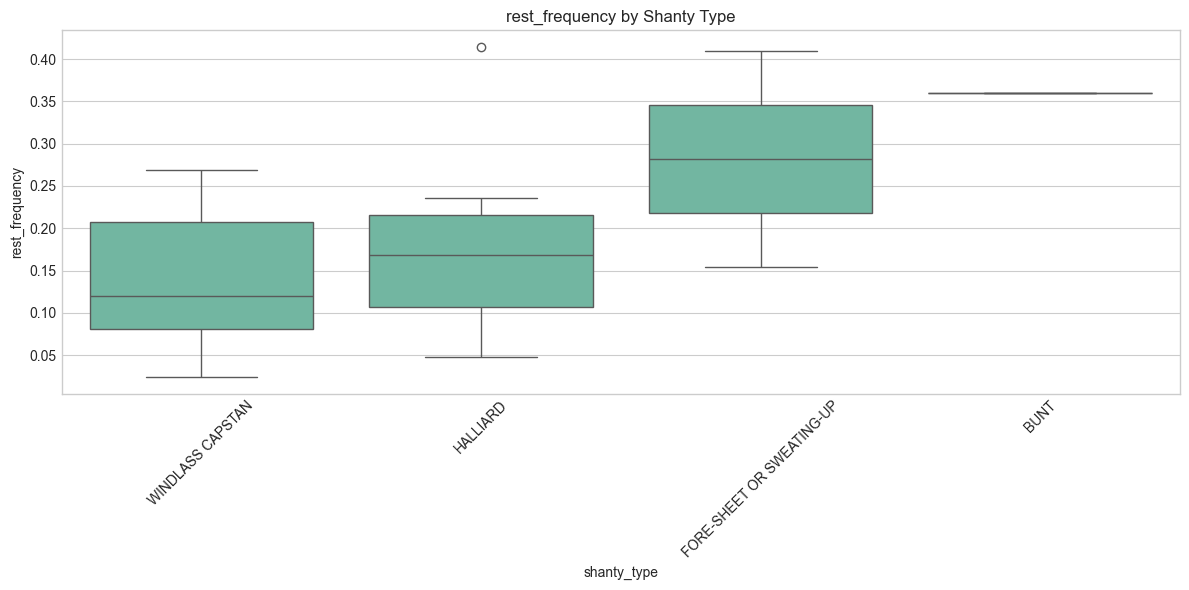

<Figure size 1200x800 with 0 Axes>

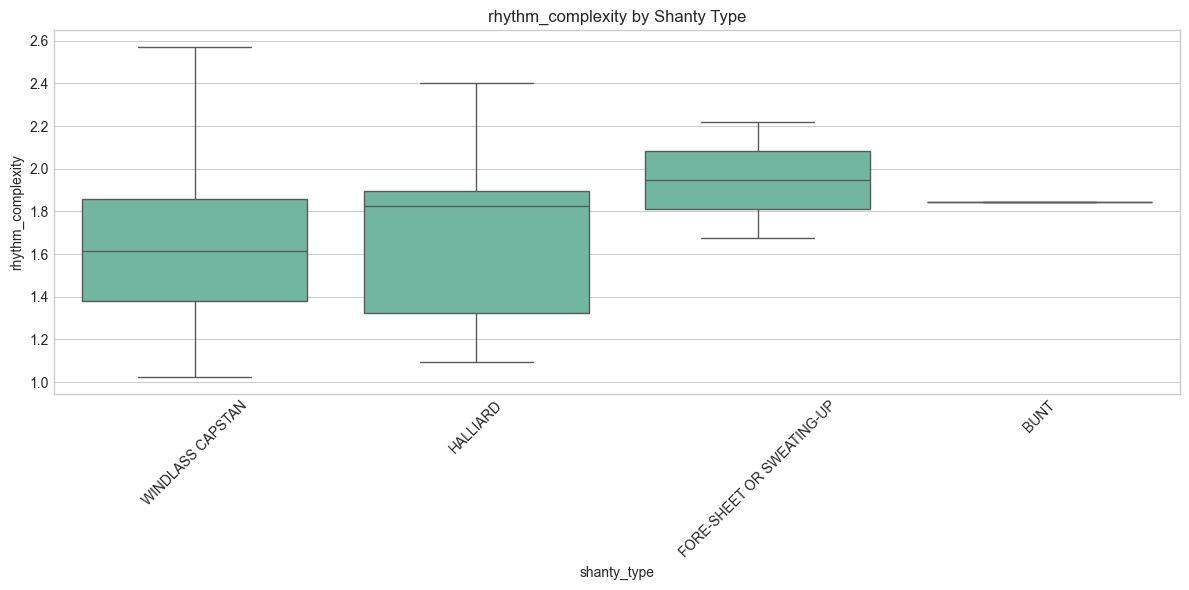

<Figure size 1200x800 with 0 Axes>

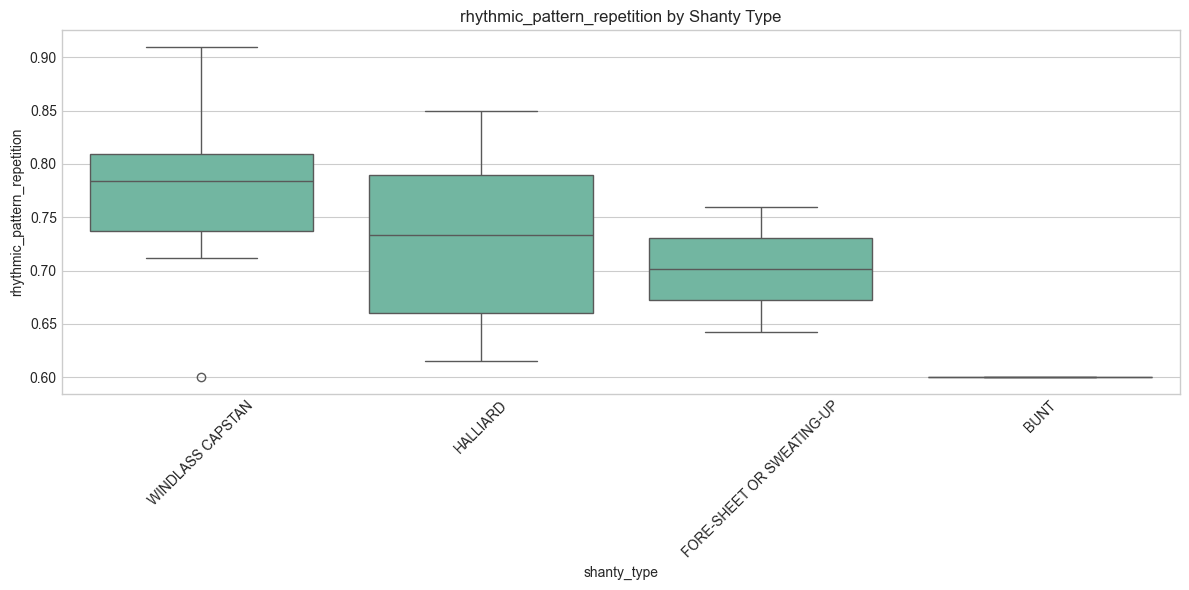

<Figure size 1200x800 with 0 Axes>

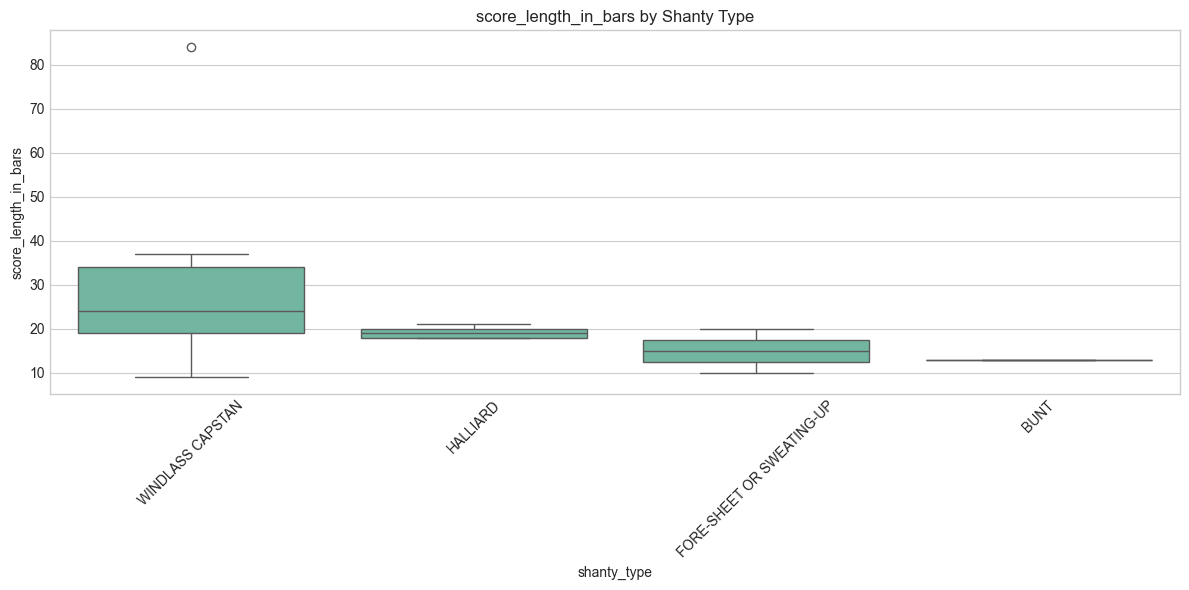

<Figure size 1200x800 with 0 Axes>

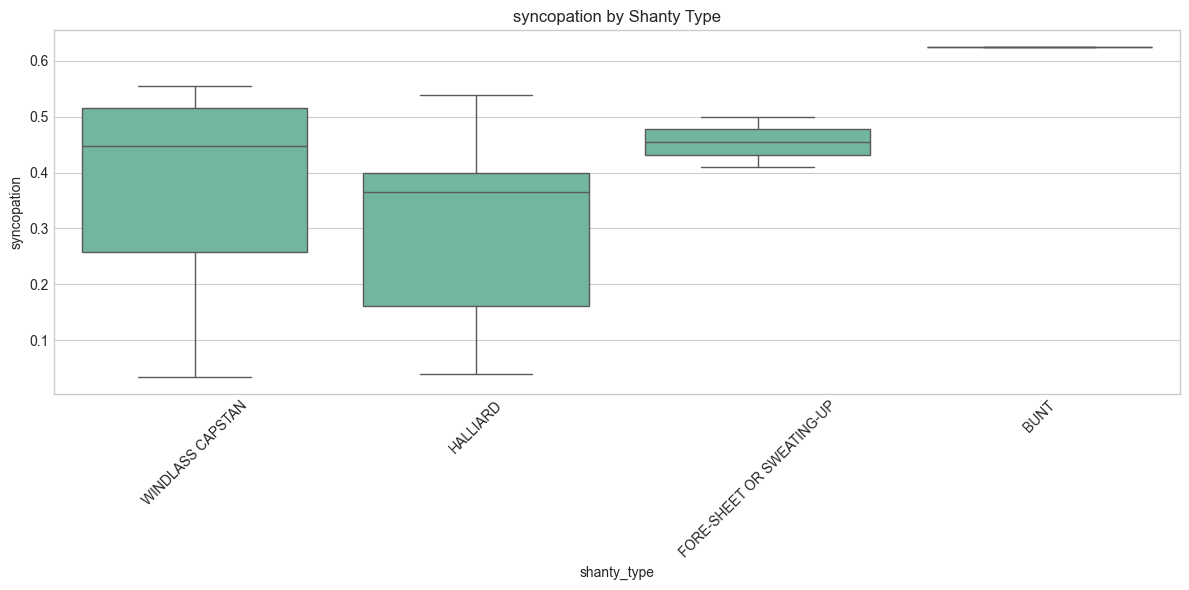

<Figure size 1200x800 with 0 Axes>

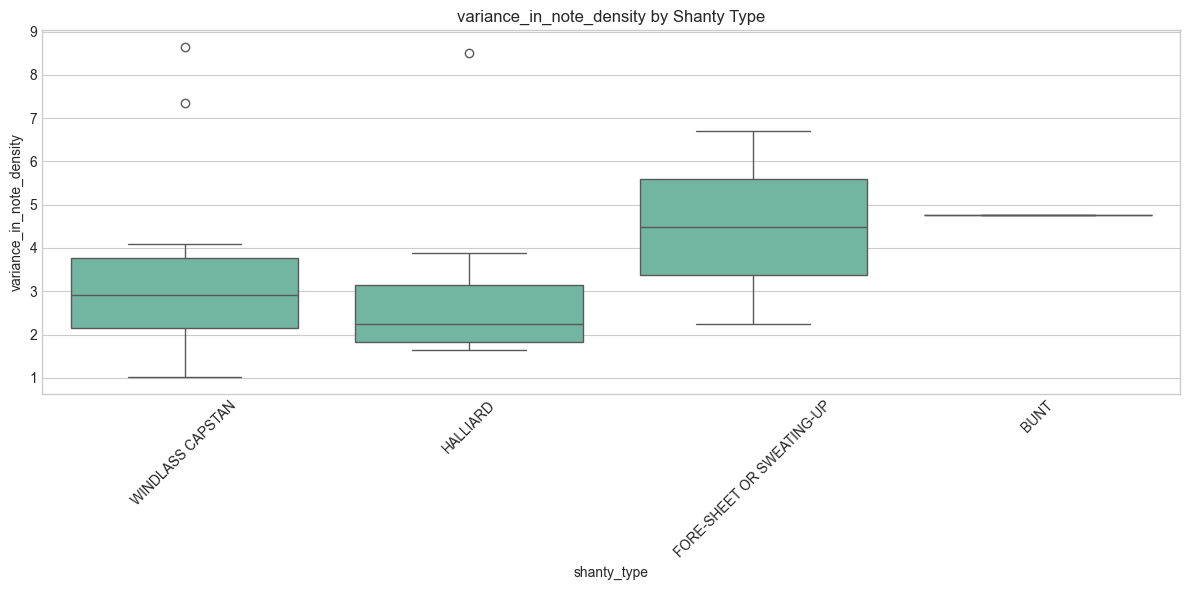

<Figure size 1200x800 with 0 Axes>

In [64]:
# Create boxplots for ALL features by shanty type
for feature in feature_cols:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='shanty_type', y=feature, data=df)
    plt.title(f'{feature} by Shanty Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Save the figure
    plt.savefig(f'plots/boxplot_{feature}_by_type.png', dpi=300, bbox_inches='tight')

In [65]:
# Group statistics by shanty type
print("=== Feature Statistics by Shanty Type ===")
grouped_stats = df.groupby('shanty_type')[feature_cols].agg(['mean', 'std'])
grouped_stats

=== Feature Statistics by Shanty Type ===


average_interval           average_note_duration  \
                                      mean       std                  mean   
shanty_type                                                                  
BUNT                              2.806452       NaN              0.656250   
FORE-SHEET OR SWEATING-UP         2.251710  0.059973              0.788680   
HALLIARD                          2.444257  0.457164              1.003257   
WINDLASS CAPSTAN                  2.160441  0.423382              0.789844   

                                    contour_directionality            \
                                std                   mean       std   
shanty_type                                                            
BUNT                            NaN               0.480000       NaN   
FORE-SHEET OR SWEATING-UP  0.183267               0.500000  0.019111   
HALLIARD                   0.185396               0.477118  0.058885   
WINDLASS CAPSTAN           0.235746               0.489373  0.065326   

                          entropy_of_pitch_sequence            \
                                               mean       std   
shanty_type                                                     
BUNT                                       2.202820       NaN   
FORE-SHEET OR SWEATING-UP                  2.386586  0.072411   
HALLIARD                                   2.527290  0.252744   
WINDLASS CAPSTAN                           2.617013  0.329390   

                          interval_complexity            ...  \
                                         mean       std  ...   
shanty_type                                              ...   
BUNT                                 2.042433       NaN  ...   
FORE-SHEET OR SWEATING-UP            2.399241  0.081142  ...   
HALLIARD                             2.273249  0.225426  ...   
WINDLASS CAPSTAN                     2.257184  0.173554  ...   

                          rhythm_complexity            \
                                       mean       std   
shanty_type                                             
BUNT                               1.841917       NaN   
FORE-SHEET OR SWEATING-UP          1.948513  0.384350   
HALLIARD                           1.708031  0.411522   
WINDLASS CAPSTAN                   1.656637  0.427177   

                          rhythmic_pattern_repetition            \
                                                 mean       std   
shanty_type                                                       
BUNT                                         0.600000       NaN   
FORE-SHEET OR SWEATING-UP                    0.701429  0.082833   
HALLIARD                                     0.730146  0.079849   
WINDLASS CAPSTAN                             0.772527  0.068126   

                          score_length_in_bars            syncopation  \
                                          mean        std        mean   
shanty_type                                                             
BUNT                                 13.000000        NaN    0.625000   
FORE-SHEET OR SWEATING-UP            15.000000   7.071068    0.454545   
HALLIARD                             19.222222   1.092906    0.296543   
WINDLASS CAPSTAN                     28.294118  16.415559    0.377132   

                                    variance_in_note_density            
                                std                     mean       std  
shanty_type                                                             
BUNT                            NaN                 4.769231       NaN  
FORE-SHEET OR SWEATING-UP  0.064282                 4.481871  3.152621  
HALLIARD                   0.160370                 3.101672  2.167183  
WINDLASS CAPSTAN           0.170906                 3.382615  1.952359  

[4 rows x 34 columns]

In [66]:
# Statistical comparison of features across ALL shanty types
print("\n=== Statistical Comparison of Features Across All Shanty Types ===")

# Get all shanty types (excluding 'Unknown')
shanty_types = df['shanty_type'].unique().tolist()

if len(shanty_types) >= 2:
    # Initialize a dictionary to store features with significant differences
    significant_features = {}
    
    # Print header row for the comparison table
    print(f"\n{'Feature':<30} | " + " | ".join([f"{t:<15}" for t in shanty_types]))
    print("-" * 30 + "+" + "+".join(["-" * 16 for _ in shanty_types]))
    
    # For each feature, compare means across all shanty types
    for feature in feature_cols:
        # Get means for each shanty type
        means = [df[df['shanty_type'] == t][feature].mean() for t in shanty_types]
        
        # Print the feature and its means
        print(f"{feature:<30} | " + " | ".join([f"{m:<15.3f}" for m in means]))
        
        # Calculate pairwise percent differences
        significant_diffs = []
        for i in range(len(shanty_types)):
            for j in range(i+1, len(shanty_types)):
                mean1 = means[i]
                mean2 = means[j]
                
                # Calculate percent difference, handling division by zero
                if mean1 == 0 and mean2 == 0:
                    pct_diff = 0
                elif mean1 == 0:
                    pct_diff = float('inf')  # Infinite percentage difference
                else:
                    pct_diff = ((mean2 - mean1) / abs(mean1)) * 100
                
                # Check if the difference is significant
                if abs(pct_diff) > 20:  # 20% difference threshold
                    significant_diffs.append((shanty_types[i], shanty_types[j], pct_diff))
        
        # If we found significant differences, store them
        if significant_diffs:
            significant_features[feature] = significant_diffs
    
    # Print the significant differences
    print("\n=== Significant Differences Between Shanty Types (>20% difference) ===")
    for feature, diffs in significant_features.items():
        print(f"\n{feature}:")
        for type1, type2, pct_diff in diffs:
            print(f"  {type1} vs {type2}: {pct_diff:.1f}% difference")
else:
    print("Need at least two different shanty types for comparison.")


=== Statistical Comparison of Features Across All Shanty Types ===

Feature                        | WINDLASS CAPSTAN | HALLIARD        | FORE-SHEET OR SWEATING-UP | BUNT           
------------------------------+----------------+----------------+----------------+----------------
average_interval               | 2.160           | 2.444           | 2.252           | 2.806          
average_note_duration          | 0.790           | 1.003           | 0.789           | 0.656          
contour_directionality         | 0.489           | 0.477           | 0.500           | 0.480          
entropy_of_pitch_sequence      | 2.617           | 2.527           | 2.387           | 2.203          
interval_complexity            | 2.257           | 2.273           | 2.399           | 2.042          
leap_frequency                 | 0.292           | 0.369           | 0.380           | 0.226          
melodic_contour_complexity     | 0.382           | 0.415           | 0.481           | 0.484        

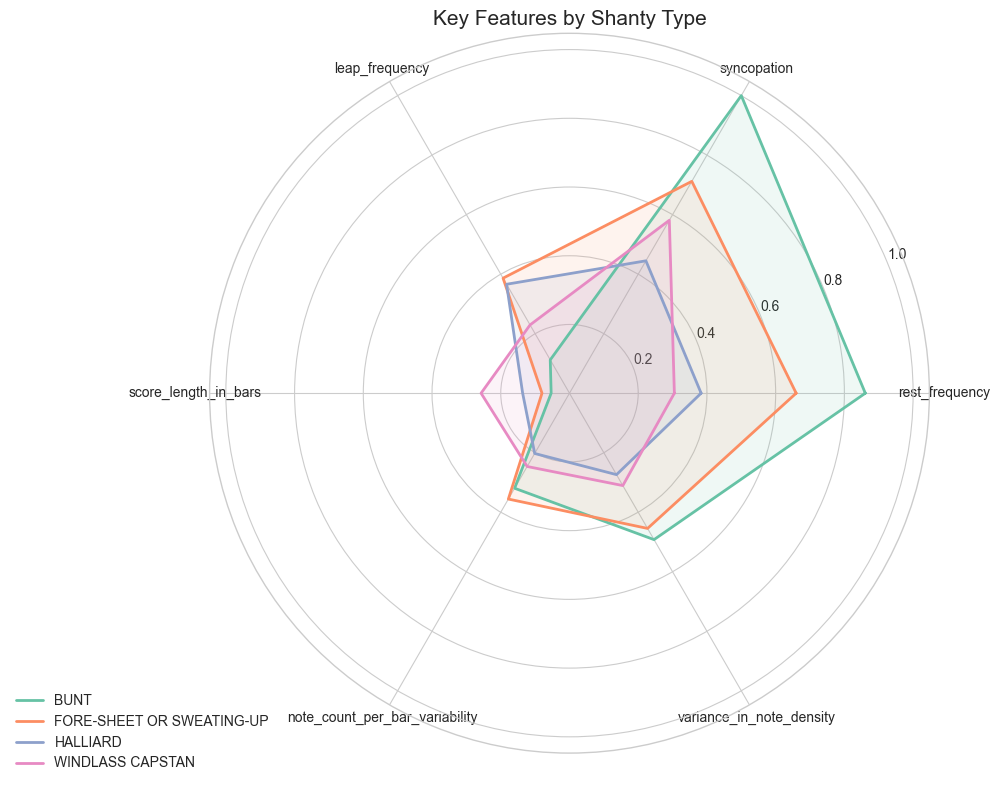

<Figure size 1200x800 with 0 Axes>

In [67]:
# Create a radar chart for features with significant differences between shanty types
if len(shanty_types) >= 2 and 'significant_features' in locals() and significant_features:
    # Count how many times each feature appears in significant differences
    feature_counts = {}
    for feature, diffs in significant_features.items():
        feature_counts[feature] = len(diffs)
    
    # Sort features by number of significant differences
    sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Take top N features 
    top_n = min(6, len(sorted_features))
    radar_features = [f[0] for f in sorted_features[:top_n]]
    
    # Prepare data for radar chart
    # Scale the features to 0-1 range for comparison
    radar_df = df[radar_features + ['shanty_type']].copy()
    for feature in radar_features:
        min_val = radar_df[feature].min()
        max_val = radar_df[feature].max()
        radar_df[feature] = (radar_df[feature] - min_val) / (max_val - min_val) if max_val > min_val else 0
    
    # Get means for each shanty type
    means = radar_df.groupby('shanty_type')[radar_features].mean()
    
    # Create radar chart
    n_features = len(radar_features)
    angles = np.linspace(0, 2*np.pi, n_features, endpoint=False).tolist()
    angles += angles[:1]  # Close the circle
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    for shanty_type, values in means.iterrows():
        values_list = values.tolist()
        values_list += values_list[:1]  # Close the circle
        ax.plot(angles, values_list, linewidth=2, label=shanty_type)
        ax.fill(angles, values_list, alpha=0.1)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_features)
    ax.set_title('Key Features by Shanty Type', size=15)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.tight_layout()
    plt.show()
    
    # Save the figure
    plt.savefig('plots/radar_chart_shanty_types.png', dpi=300, bbox_inches='tight')

## 4. Correlation Analysis

Let's examine how different musical features correlate with each other.
This can help us understand which features tend to appear together in shanties.

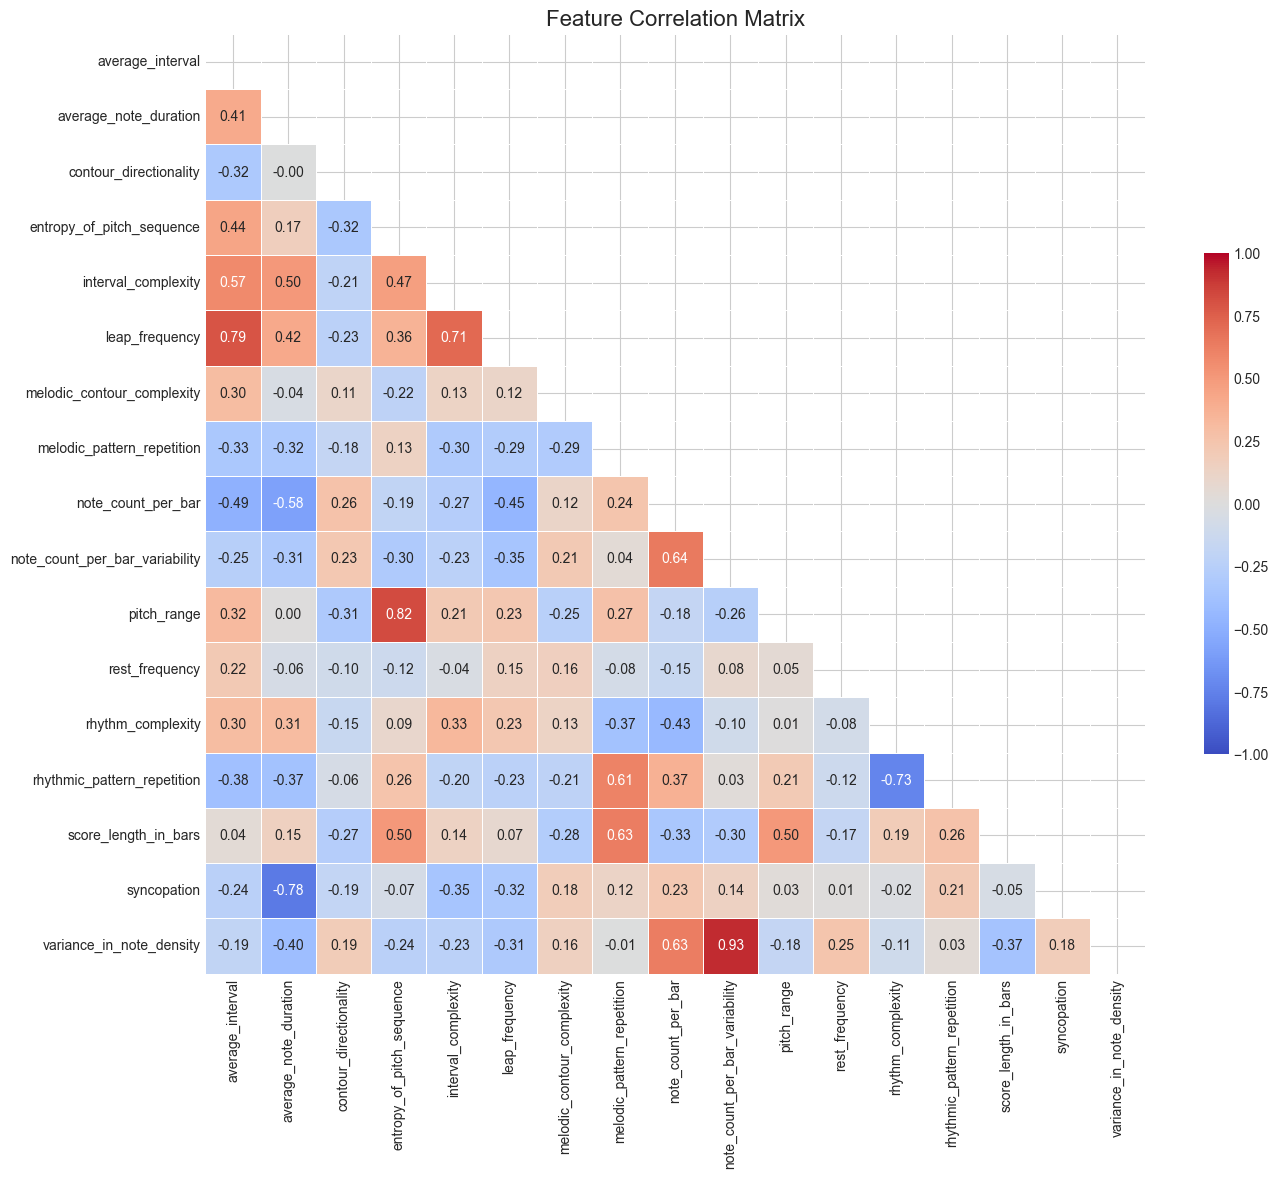

<Figure size 1200x800 with 0 Axes>

In [68]:
# Compute and visualize the correlation matrix - improved version
corr_matrix = df[feature_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
# Mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# Draw the heatmap with the mask
sns.heatmap(
    corr_matrix, 
    mask=mask,
    cmap='coolwarm',
    vmin=-1, 
    vmax=1, 
    center=0,
    square=True, 
    linewidths=.5,
    annot=True, 
    fmt='.2f',
    cbar_kws={"shrink": .5}
)
plt.title('Feature Correlation Matrix', size=16)
plt.tight_layout()
plt.show()

# Save the figure
plt.savefig('plots/correlation_matrix.png', dpi=300, bbox_inches='tight')

=== Highly Correlated Features (|r| > 0.7) ===
                        Feature 1                    Feature 2  Correlation
4  note_count_per_bar_variability     variance_in_note_density     0.929168
2       entropy_of_pitch_sequence                  pitch_range     0.823596
0                average_interval               leap_frequency     0.792766
3             interval_complexity               leap_frequency     0.711756
5               rhythm_complexity  rhythmic_pattern_repetition    -0.732348
1           average_note_duration                  syncopation    -0.783115


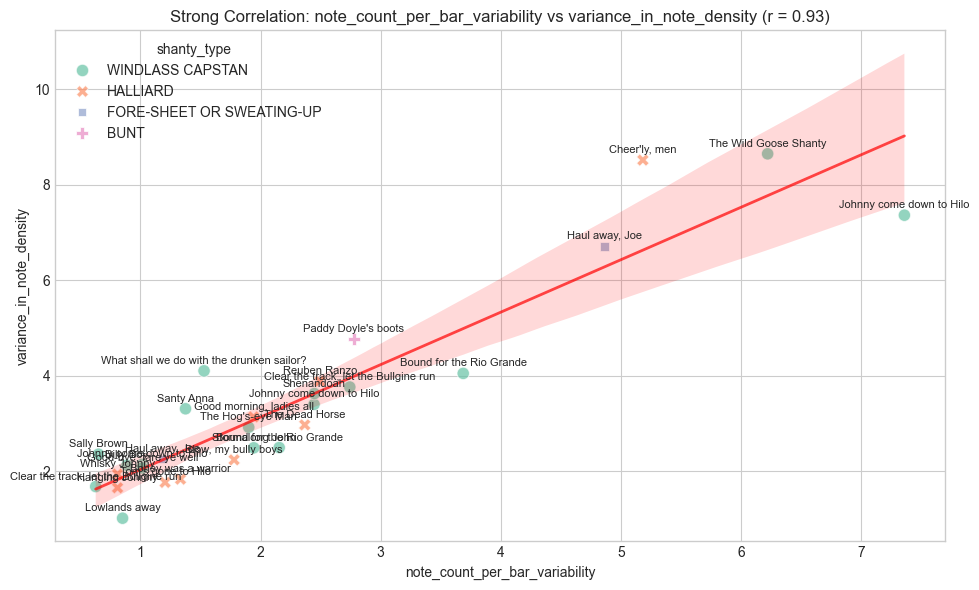

<Figure size 1200x800 with 0 Axes>

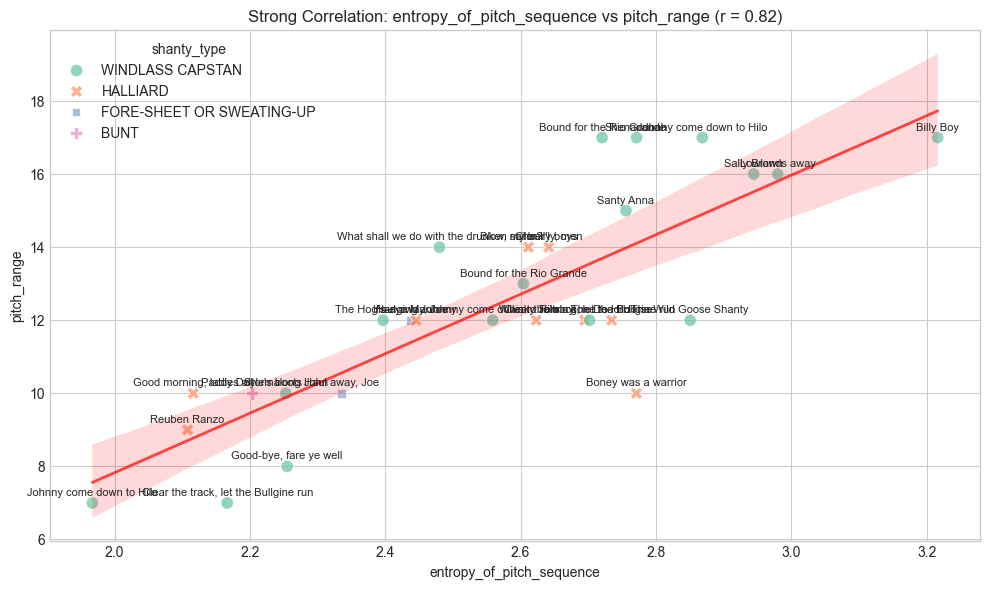

<Figure size 1200x800 with 0 Axes>

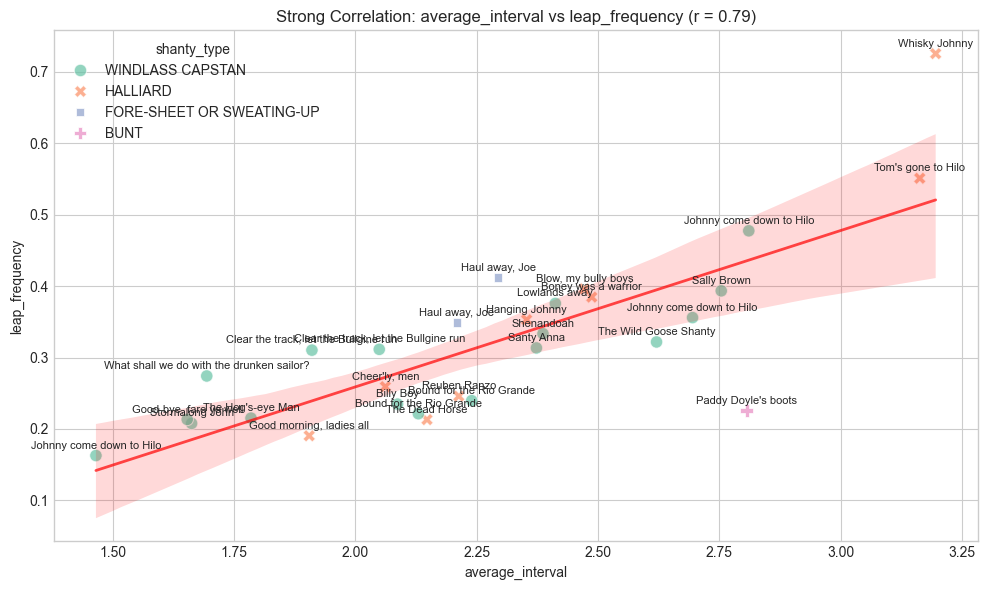

<Figure size 1200x800 with 0 Axes>

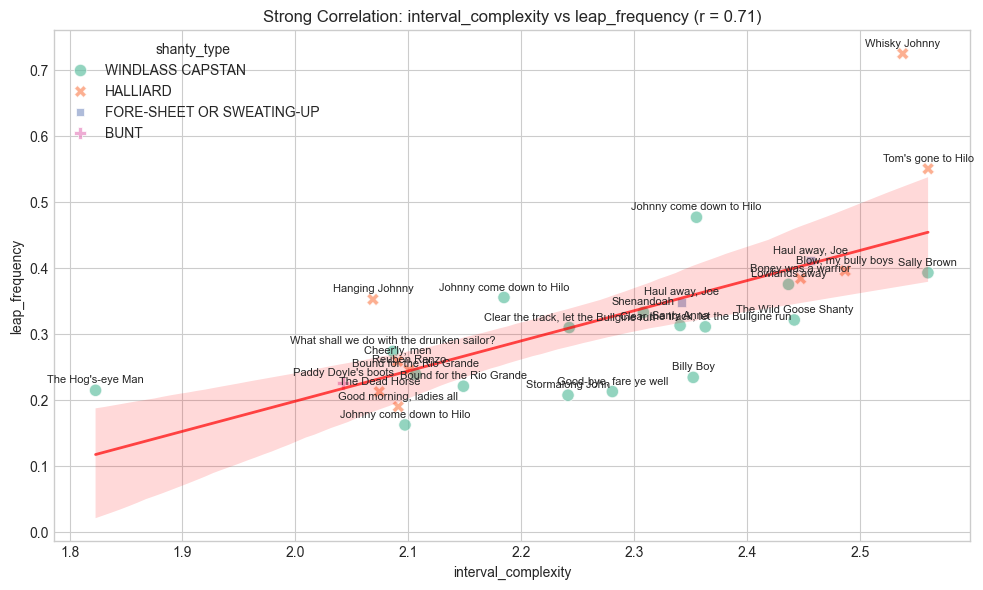

<Figure size 1200x800 with 0 Axes>

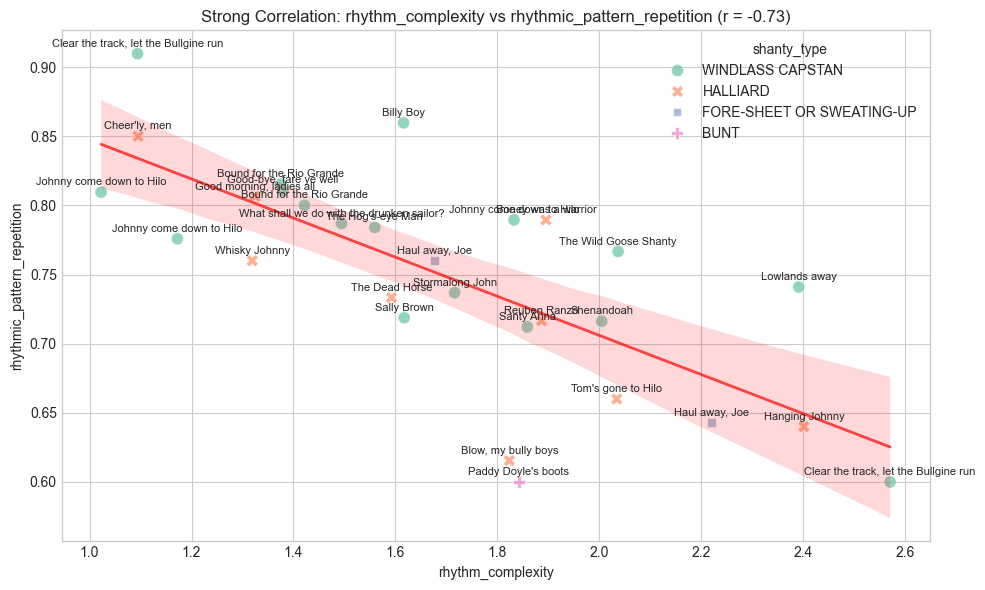

<Figure size 1200x800 with 0 Axes>

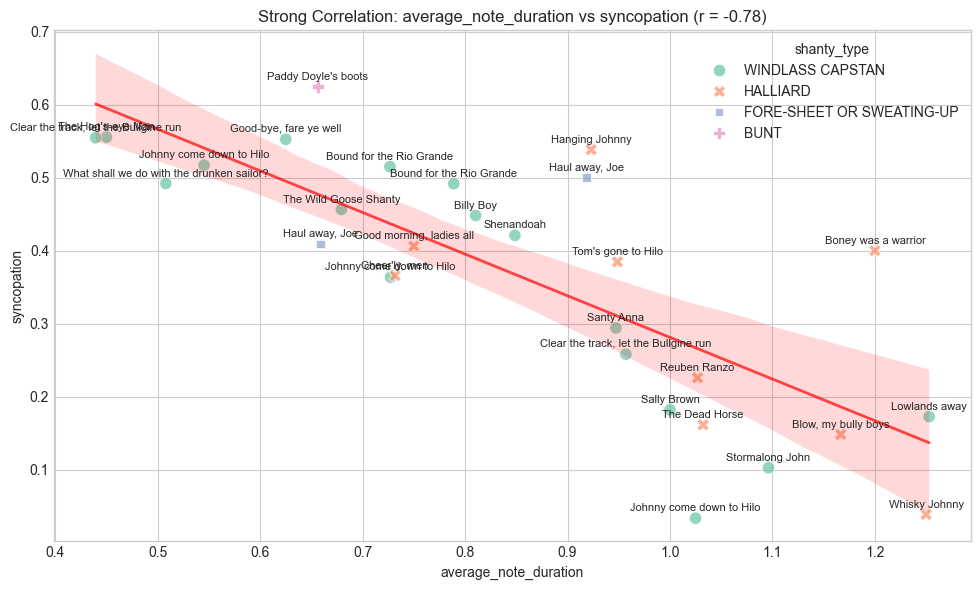

<Figure size 1200x800 with 0 Axes>

In [75]:
# Find and display the most highly correlated feature pairs
print("=== Highly Correlated Features (|r| > 0.7) ===")
# Create a DataFrame to hold feature1, feature2, correlation
corr_pairs = []
for i in range(len(feature_cols)):
    for j in range(i+1, len(feature_cols)):  # upper triangle only
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > 0.7:  # threshold for "high" correlation
            corr_pairs.append({
                'Feature 1': feature_cols[i],
                'Feature 2': feature_cols[j],
                'Correlation': corr
            })

# Display as a sorted DataFrame
if corr_pairs:
    corr_df = pd.DataFrame(corr_pairs)
    sorted_corr_df = corr_df.sort_values('Correlation', ascending=False)
    print(sorted_corr_df)
    
    # Visualize the most highly correlated pairs
    for i, row in sorted_corr_df.iterrows():
        feature1 = row['Feature 1']
        feature2 = row['Feature 2']
        corr = row['Correlation']
        
        plt.figure(figsize=(10, 6))
        scatter = sns.scatterplot(
            data=df, 
            x=feature1, 
            y=feature2, 
            hue='shanty_type',
            style='shanty_type',
            s=80,
            alpha=0.7
        )
        
        # Add regression line
        sns.regplot(
            data=df, 
            x=feature1, 
            y=feature2, 
            scatter=False, 
            line_kws={"color": "red", "lw": 2, "alpha": 0.7}
        )
        
        # Add labels for each point
        for i, row in df.iterrows():
            plt.annotate(row['shanty_name'], 
                        (row[feature1], row[feature2]),
                        textcoords="offset points", 
                        xytext=(0, 5),
                        ha='center',
                        fontsize=8)
        
        plt.title(f'Strong Correlation: {feature1} vs {feature2} (r = {corr:.2f})')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # Save the figure
        plt.savefig(f'plots/high_corr_{feature1}_vs_{feature2}.png', dpi=300, bbox_inches='tight')
else:
    print("No feature pairs with correlation > 0.7 found")
    
    # If no high correlations, show a few of the strongest correlations anyway
    print("\nShowing strongest correlations found:")
    # Get absolute values of correlations
    corr_matrix_abs = corr_matrix.abs()
    # Get upper triangle only
    mask = np.triu(np.ones_like(corr_matrix_abs), k=1).astype(bool)
    corr_matrix_upper = corr_matrix_abs.where(mask)
    
    # Find top 5 correlations
    n_top = 5
    valid_pairs = []
    for i in range(n_top):
        # Find the max value position
        idx = corr_matrix_upper.stack().idxmax()
        if pd.isna(idx) or corr_matrix_upper.loc[idx] == 0:
            break
        
        feature1, feature2 = idx
        corr = corr_matrix.loc[feature1, feature2]
        valid_pairs.append((feature1, feature2))
        print(f"{feature1} and {feature2}: {corr:.3f}")
        
        # Set this pair to 0 to find the next highest
        corr_matrix_upper.loc[feature1, feature2] = 0
    
    # Visualize these top correlations
    for feature1, feature2 in valid_pairs:
        corr = corr_matrix.loc[feature1, feature2]
        
        plt.figure(figsize=(10, 6))
        scatter = sns.scatterplot(
            data=df, 
            x=feature1, 
            y=feature2, 
            hue='shanty_type',
            style='shanty_type',
            s=80,
            alpha=0.7
        )
        
        # Add regression line
        sns.regplot(
            data=df, 
            x=feature1, 
            y=feature2, 
            scatter=False, 
            line_kws={"color": "red", "lw": 2, "alpha": 0.7}
        )
        
        # Add labels for each point
        for i, row in df.iterrows():
            plt.annotate(row['shanty_name'], 
                         (row[feature1], row[feature2]),
                         textcoords="offset points", 
                         xytext=(0, 5),
                         ha='center',
                         fontsize=8)
        
        plt.title(f'Top Correlation: {feature1} vs {feature2} (r = {corr:.2f})')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # Save the figure
        plt.savefig(f'plots/top_corr_{feature1}_vs_{feature2}.png', dpi=300, bbox_inches='tight')

## 5. Dimensionality Reduction and Visualization

Now let's use PCA to reduce our feature space to 2 dimensions so we can visualize 
how shanties relate to each other across all features simultaneously.

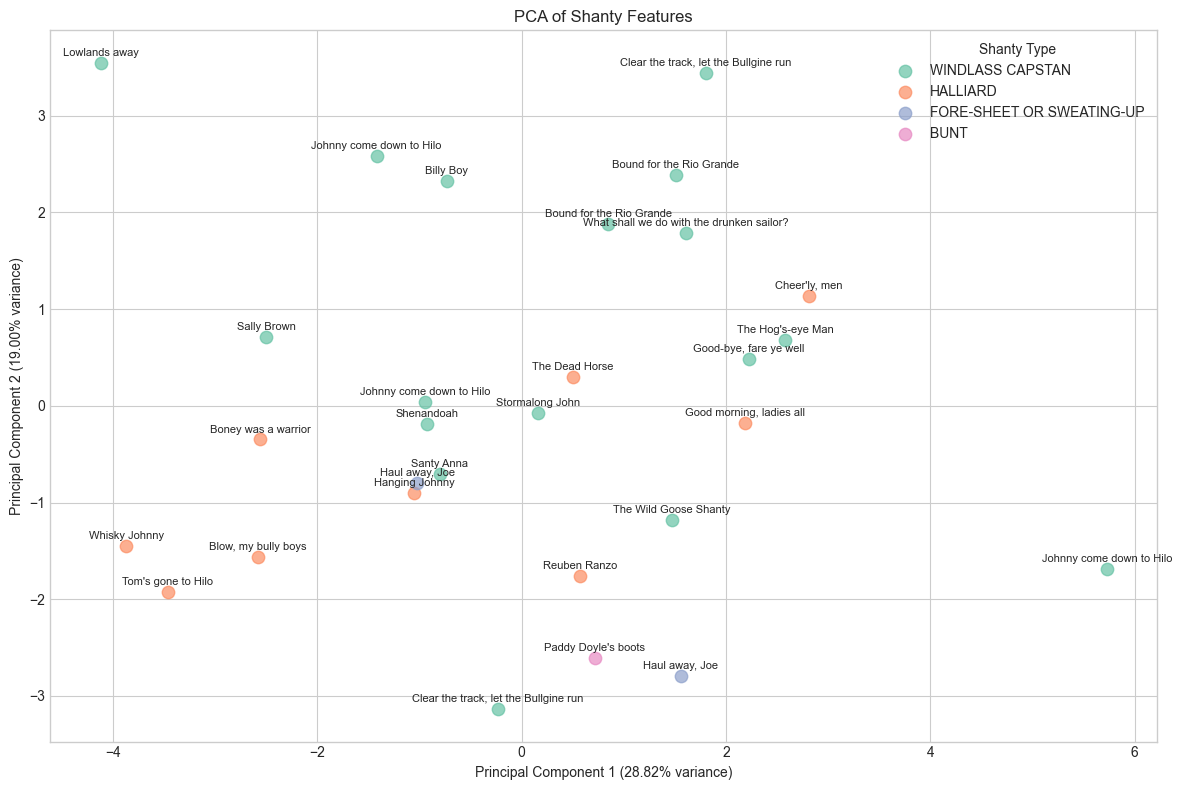

<Figure size 1200x800 with 0 Axes>

In [76]:
# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[feature_cols])

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Create DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['shanty_type'] = df['shanty_type'].values
pca_df['shanty_name'] = df['shanty_name'].values

# Plot PCA results
plt.figure(figsize=(12, 8))
shanty_types = pca_df['shanty_type'].unique()

for i, shanty_type in enumerate(shanty_types):
    subset = pca_df[pca_df['shanty_type'] == shanty_type]
    plt.scatter(subset['PC1'], subset['PC2'], label=shanty_type, s=80, alpha=0.7)

# Add labels for each point
for i, row in pca_df.iterrows():
    plt.annotate(row['shanty_name'], 
                (row['PC1'], row['PC2']),
                textcoords="offset points", 
                xytext=(0, 5),
                ha='center',
                fontsize=8)

plt.title('PCA of Shanty Features')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.legend(title='Shanty Type')
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the figure
plt.savefig('plots/pca_visualization.png', dpi=300, bbox_inches='tight')

In [77]:
# Analyze feature contributions to principal components
print("\n=== Feature Contributions to Principal Components ===")
components_df = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=feature_cols
)
components_df['abs_pc1'] = abs(components_df['PC1'])
components_df = components_df.sort_values('abs_pc1', ascending=False)
components_df[['PC1', 'PC2']]


=== Feature Contributions to Principal Components ===


PC1       PC2
note_count_per_bar              0.351053  0.017375
leap_frequency                 -0.344091 -0.083316
average_interval               -0.339592 -0.118409
interval_complexity            -0.318972 -0.071047
average_note_duration          -0.318833 -0.140421
note_count_per_bar_variability  0.290411 -0.165714
variance_in_note_density        0.284496 -0.161090
entropy_of_pitch_sequence      -0.245100  0.314056
rhythm_complexity              -0.216635 -0.198718
syncopation                     0.198548  0.104109
pitch_range                    -0.180335  0.347265
rhythmic_pattern_repetition     0.169546  0.402770
score_length_in_bars           -0.159934  0.391700
contour_directionality          0.156356 -0.185583
melodic_pattern_repetition      0.127525  0.432132
melodic_contour_complexity      0.018239 -0.283030
rest_frequency                 -0.007187 -0.118615

## 6. Feature Relationship Exploration

Let's examine the relationships between ALL pairs of features to better understand 
how they interact and differ across shanty types.

There are 136 possible feature pairs. Showing the first 20.


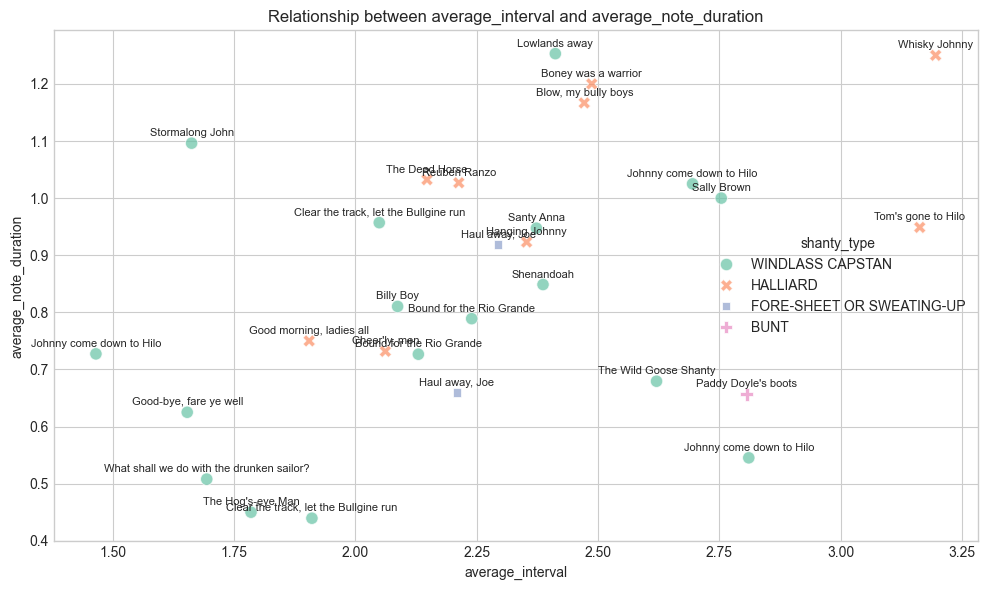

<Figure size 1200x800 with 0 Axes>

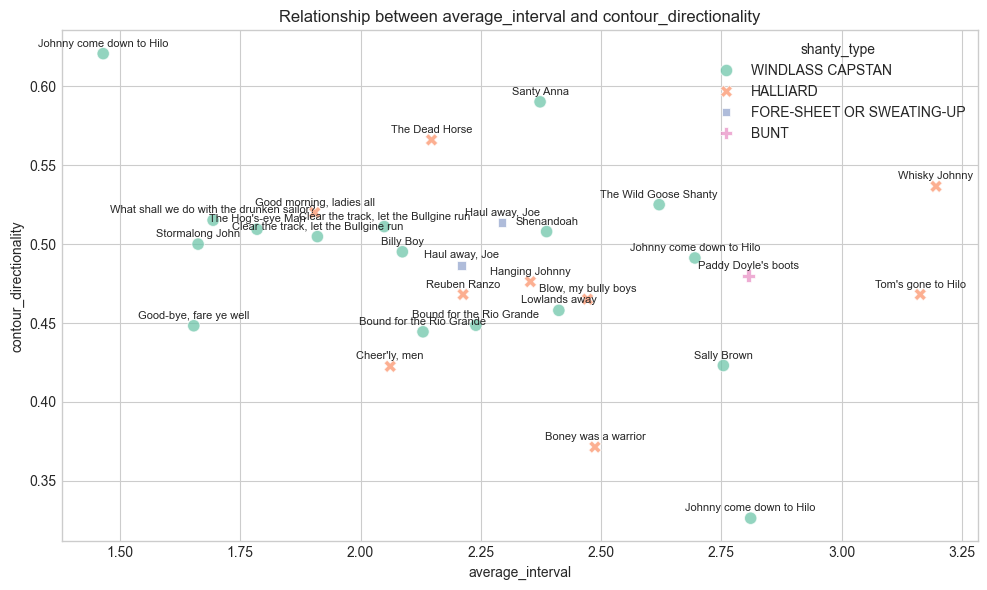

<Figure size 1200x800 with 0 Axes>

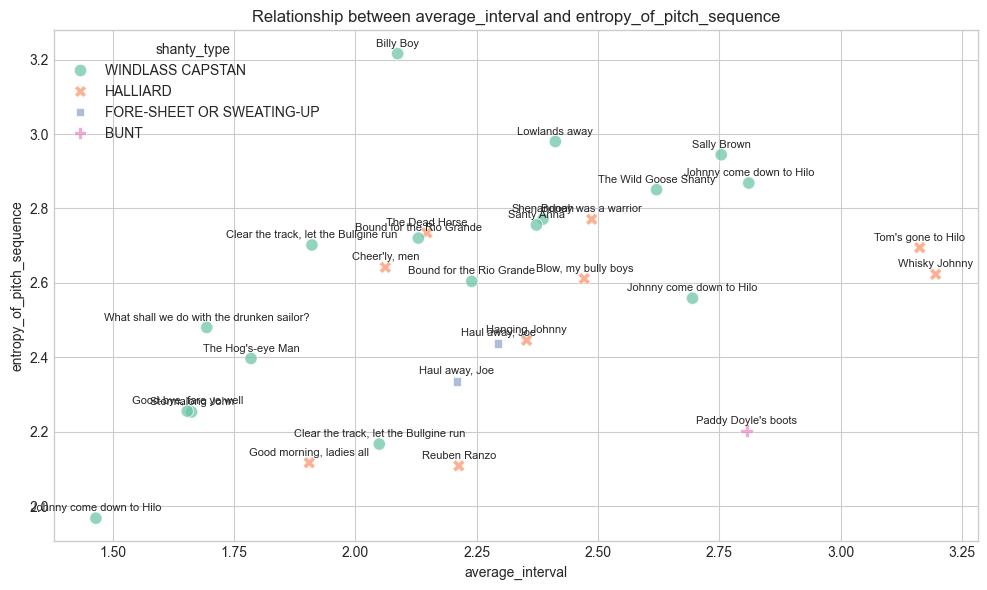

<Figure size 1200x800 with 0 Axes>

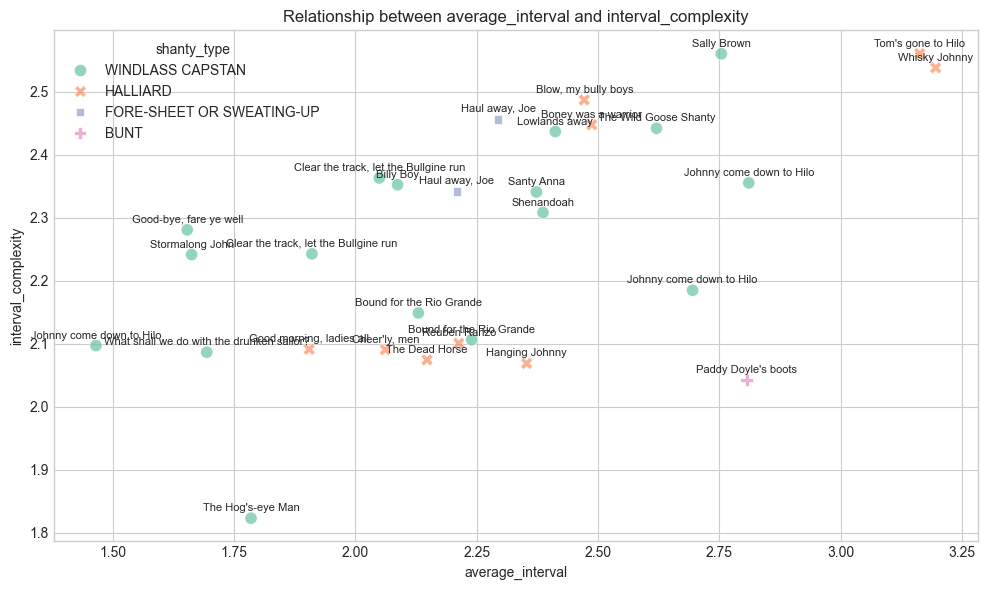

<Figure size 1200x800 with 0 Axes>

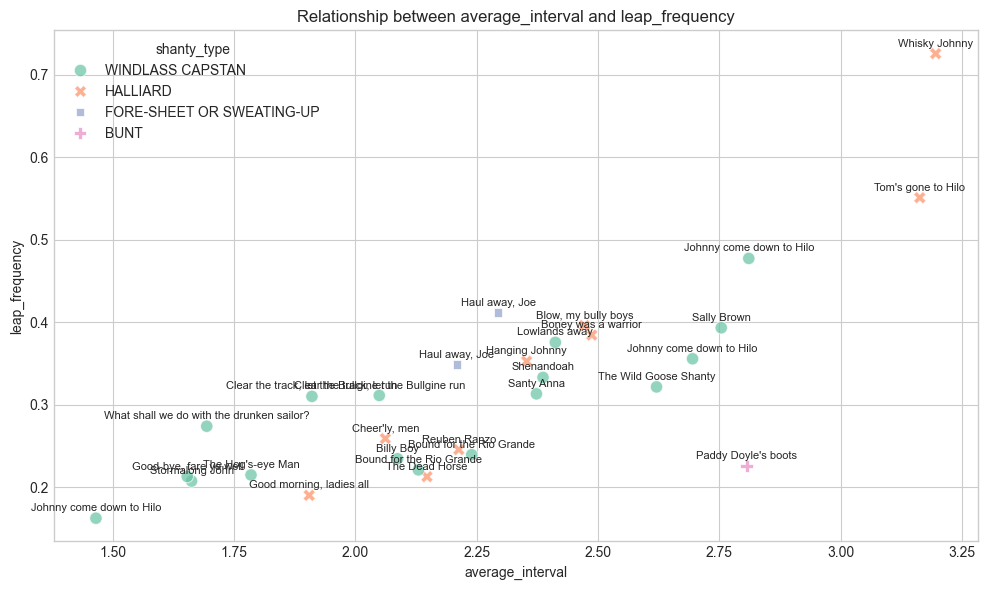

<Figure size 1200x800 with 0 Axes>

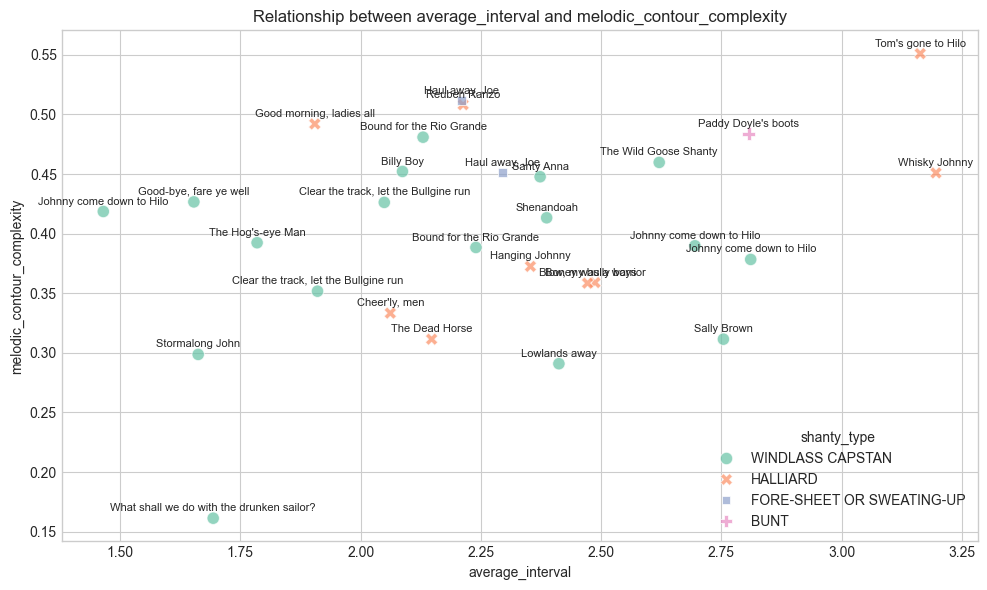

<Figure size 1200x800 with 0 Axes>

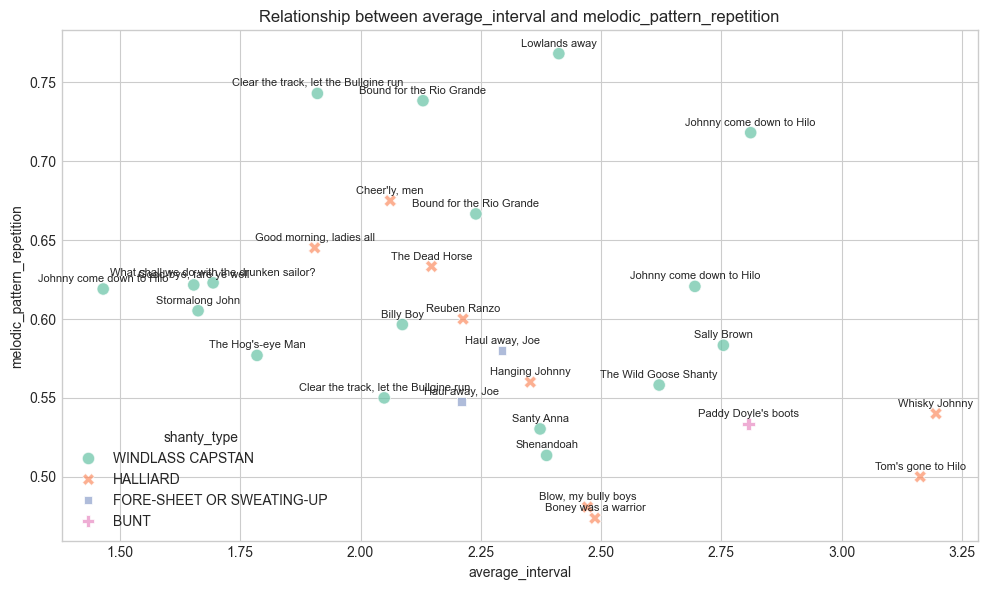

<Figure size 1200x800 with 0 Axes>

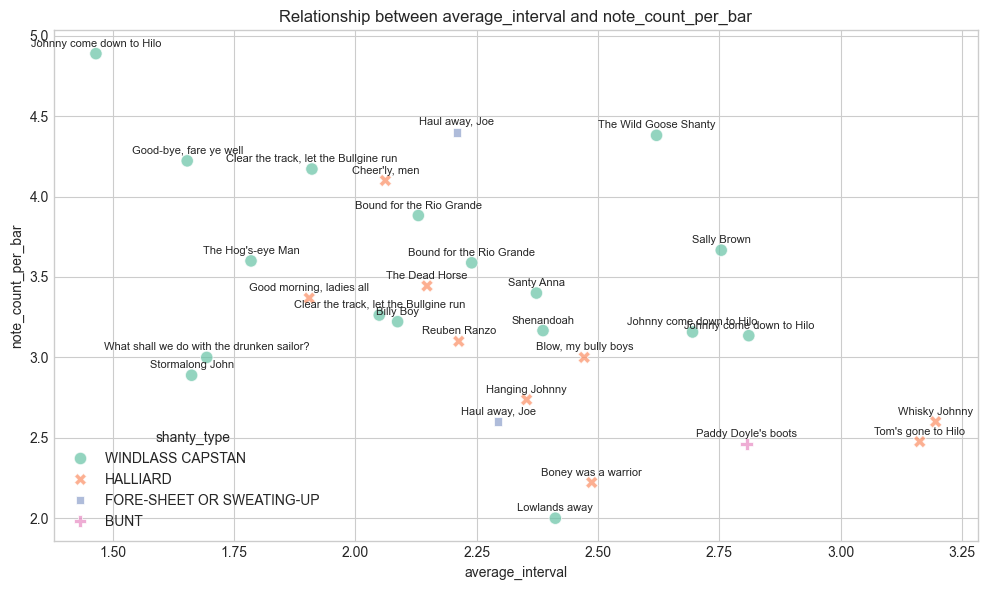

<Figure size 1200x800 with 0 Axes>

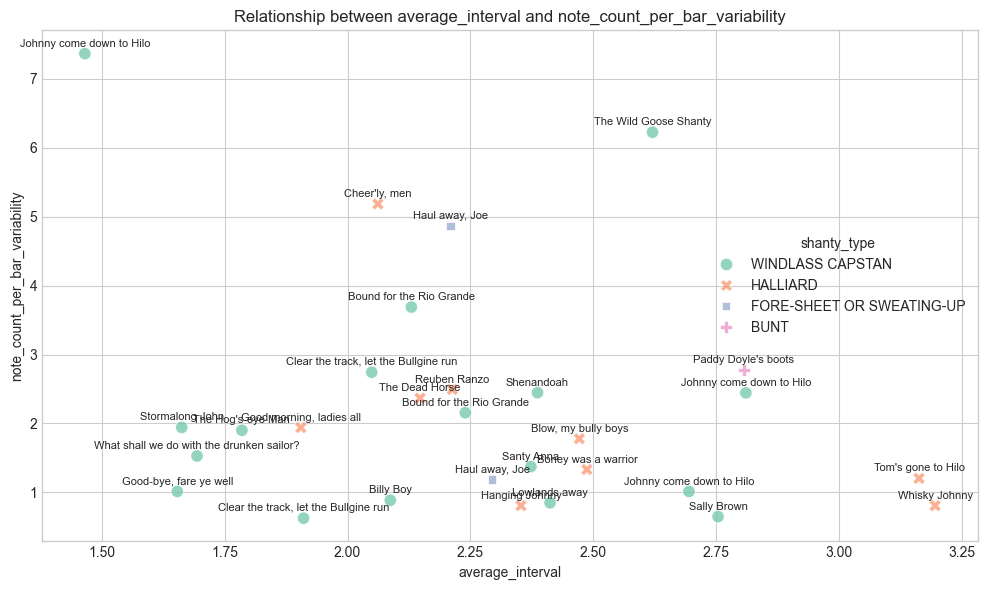

<Figure size 1200x800 with 0 Axes>

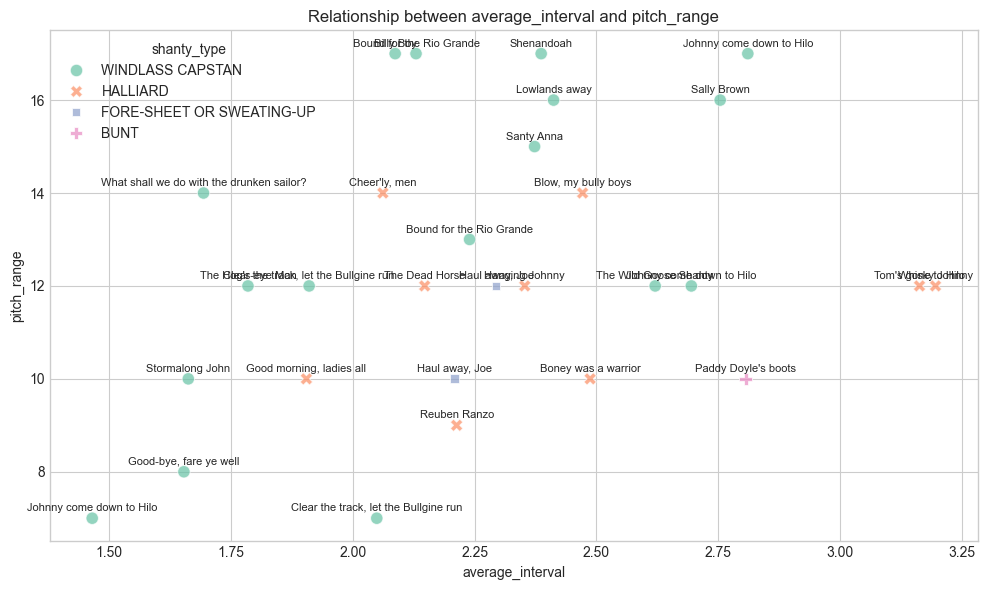

<Figure size 1200x800 with 0 Axes>

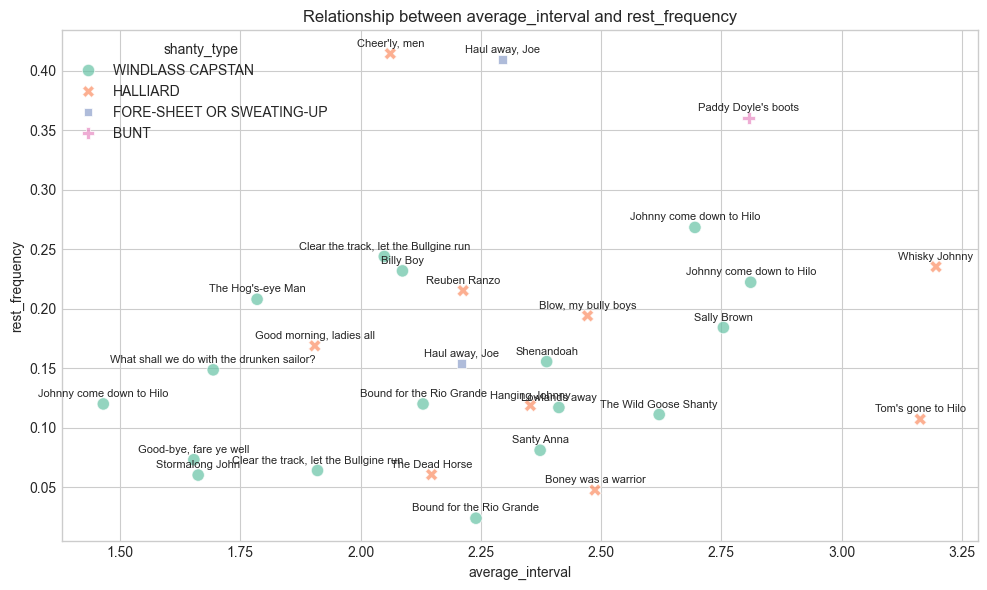

<Figure size 1200x800 with 0 Axes>

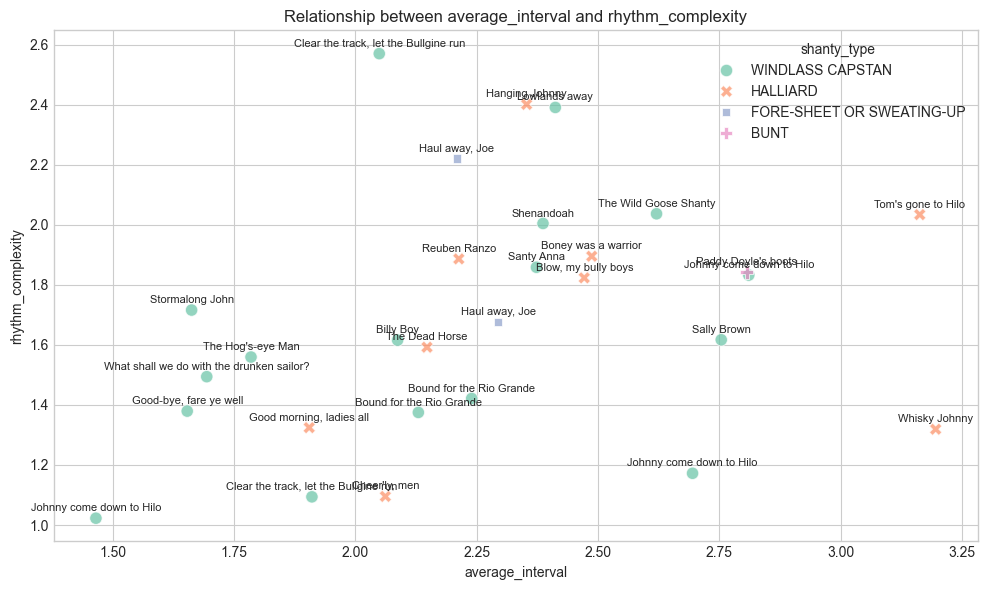

<Figure size 1200x800 with 0 Axes>

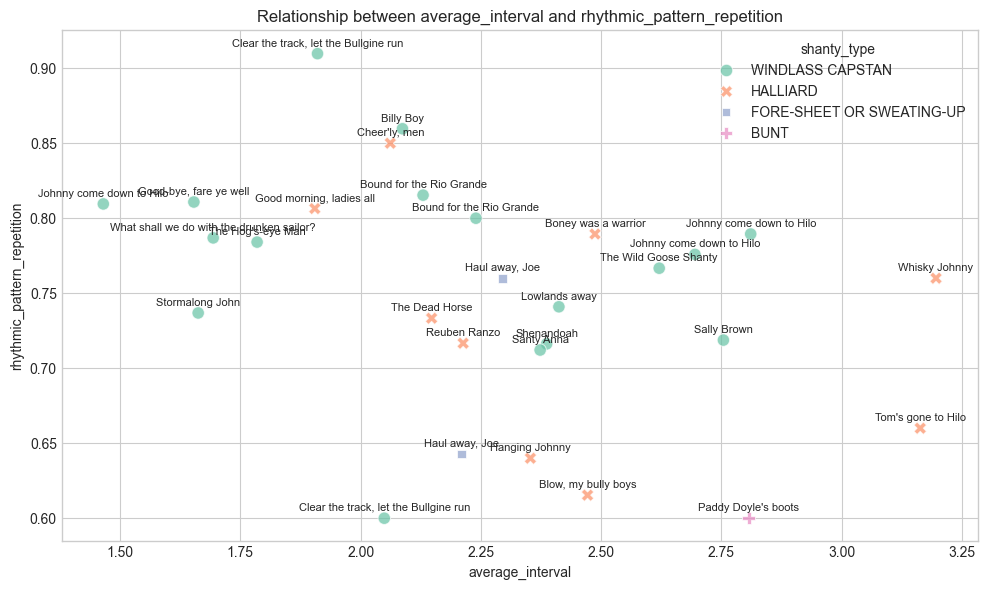

<Figure size 1200x800 with 0 Axes>

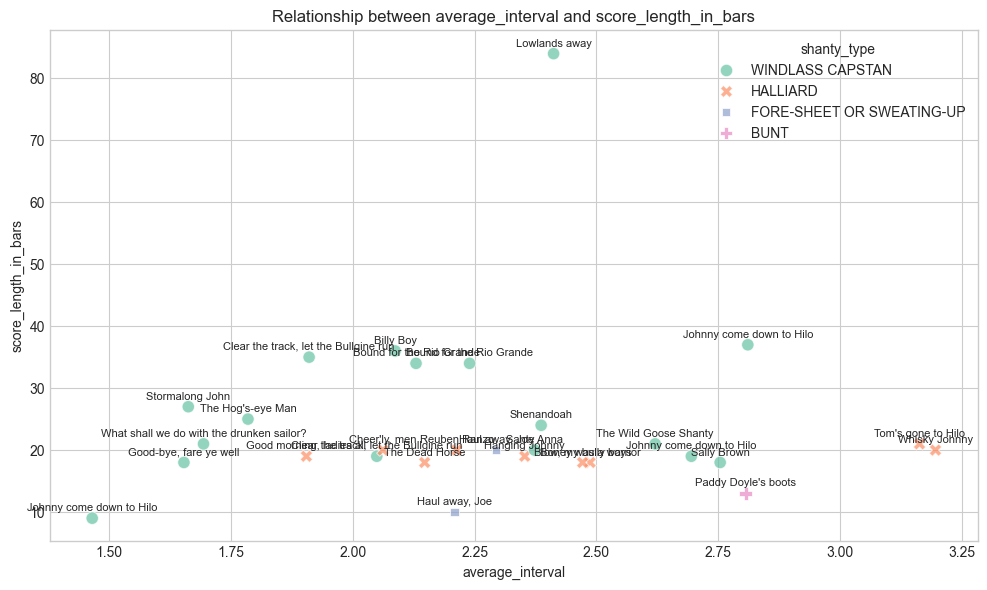

<Figure size 1200x800 with 0 Axes>

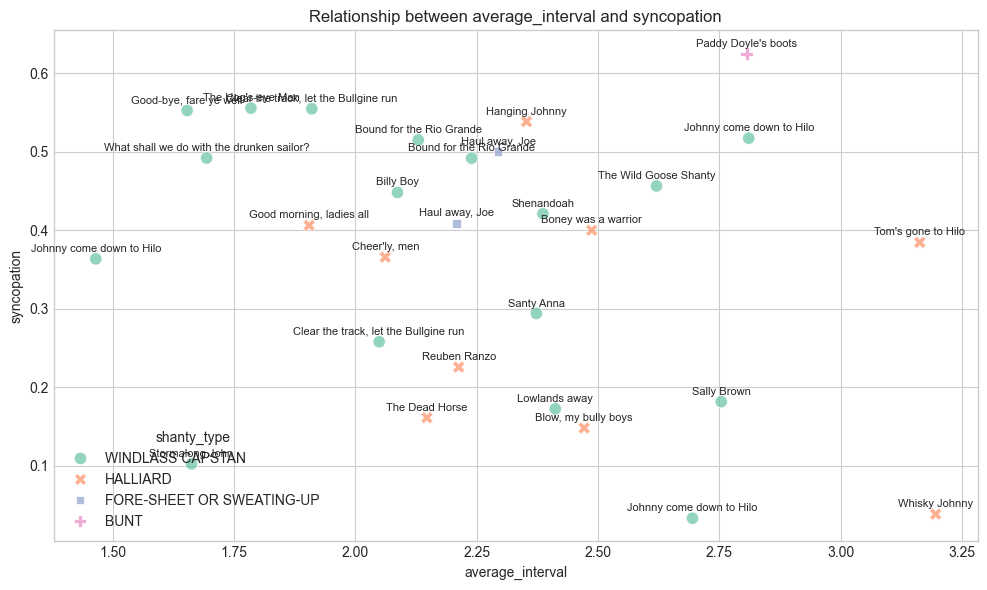

<Figure size 1200x800 with 0 Axes>

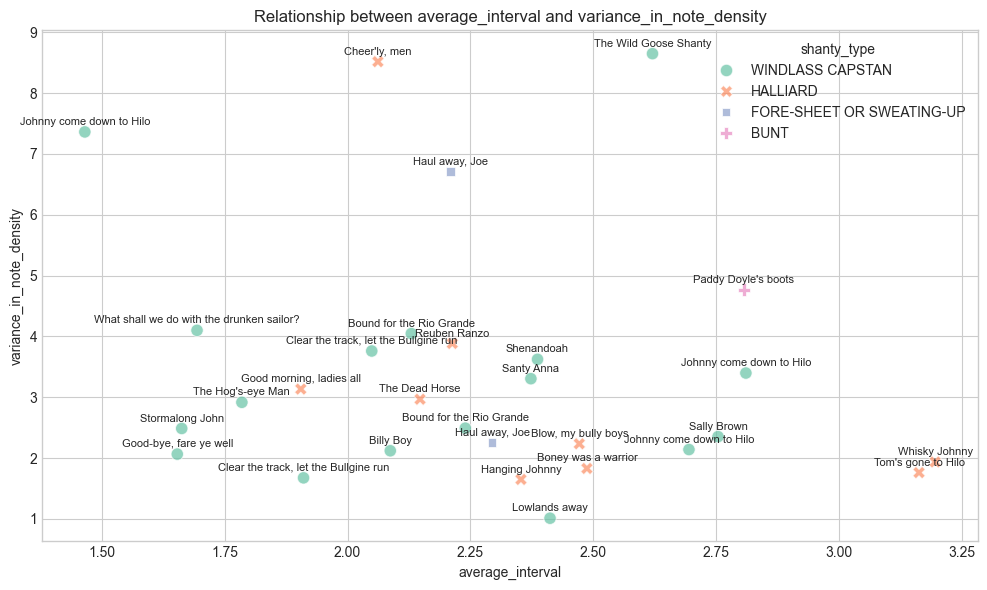

<Figure size 1200x800 with 0 Axes>

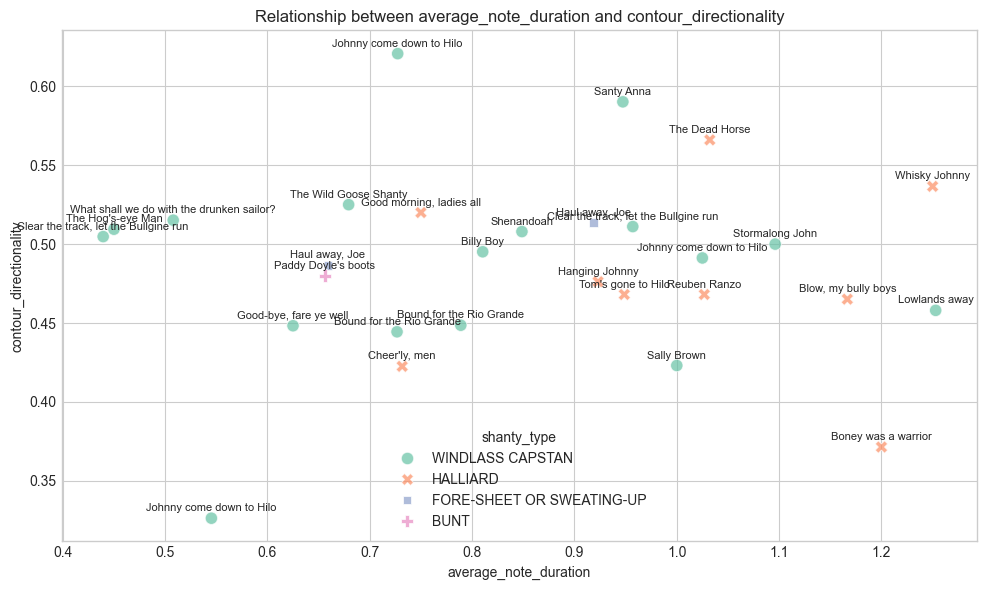

<Figure size 1200x800 with 0 Axes>

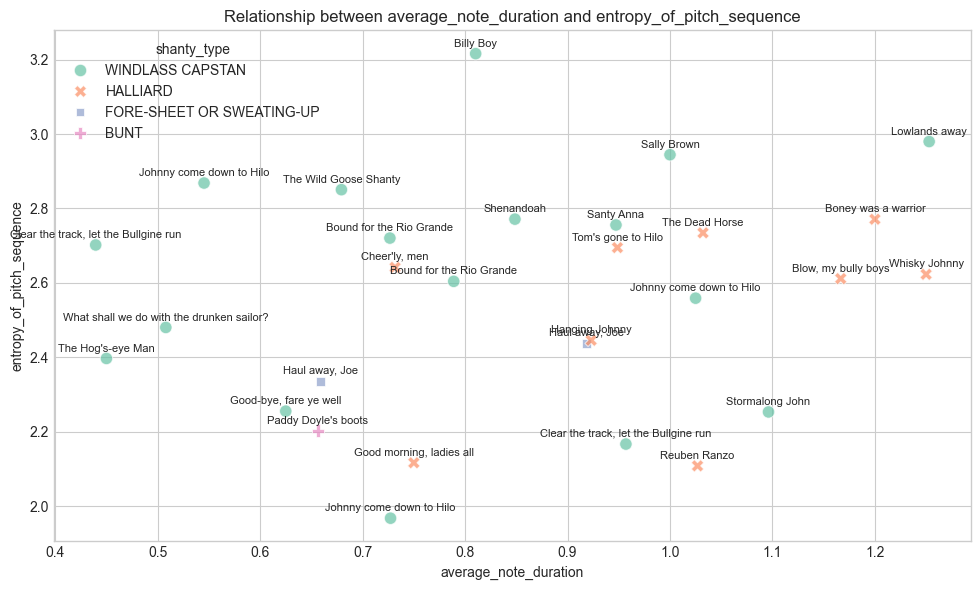

<Figure size 1200x800 with 0 Axes>

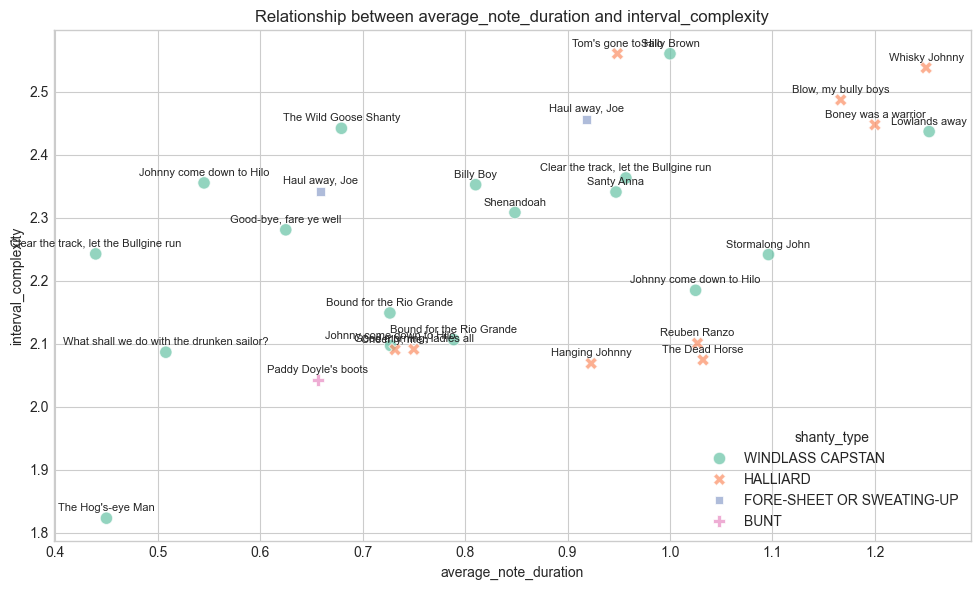

<Figure size 1200x800 with 0 Axes>

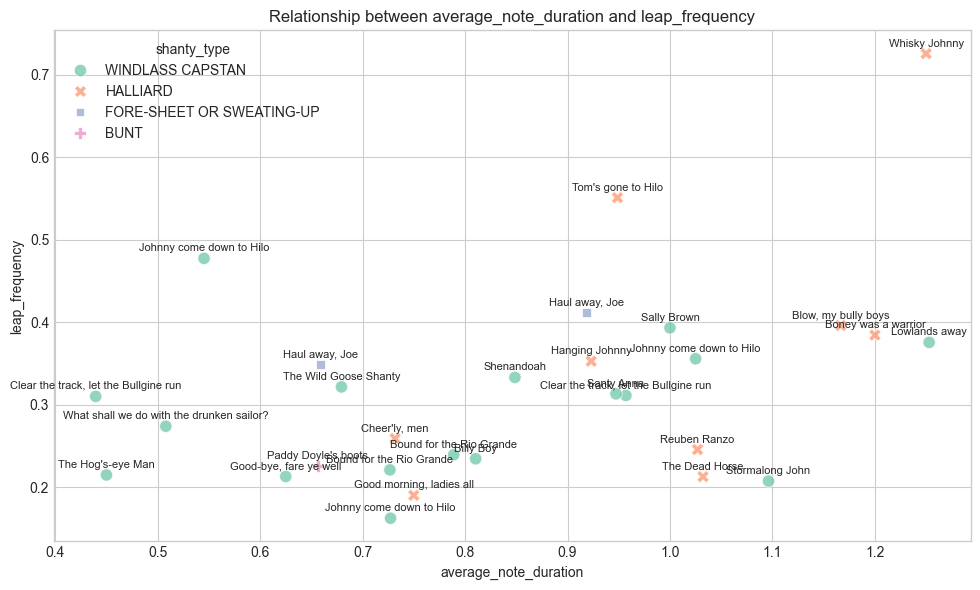

<Figure size 1200x800 with 0 Axes>

In [78]:
# Generate all possible feature pairs
feature_pairs = list(combinations(feature_cols, 2))

# Limit to a reasonable number if there are too many
max_pairs = 20  # Max number of pairs to plot
if len(feature_pairs) > max_pairs:
    print(f"There are {len(feature_pairs)} possible feature pairs. Showing the first {max_pairs}.")
    feature_pairs = feature_pairs[:max_pairs]

# Plot scatterplots for each feature pair, colored by shanty type
for feature1, feature2 in feature_pairs:
    plt.figure(figsize=(10, 6))
    
    scatter = sns.scatterplot(
        data=df,
        x=feature1,
        y=feature2,
        hue='shanty_type',
        style='shanty_type',
        s=80,
        alpha=0.7
    )
    
    # Add labels for each point
    for i, row in df.iterrows():
        plt.annotate(row['shanty_name'], 
                    (row[feature1], row[feature2]),
                    textcoords="offset points", 
                    xytext=(0, 5),
                    ha='center',
                    fontsize=8)
    
    plt.title(f'Relationship between {feature1} and {feature2}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Save the figure
    plt.savefig(f'plots/scatter_{feature1}_vs_{feature2}.png', dpi=300, bbox_inches='tight')

## 7. Clustering Analysis

Let's use K-means clustering to see if we can automatically discover natural groupings 
in our data, and compare them to the historical shanty types.

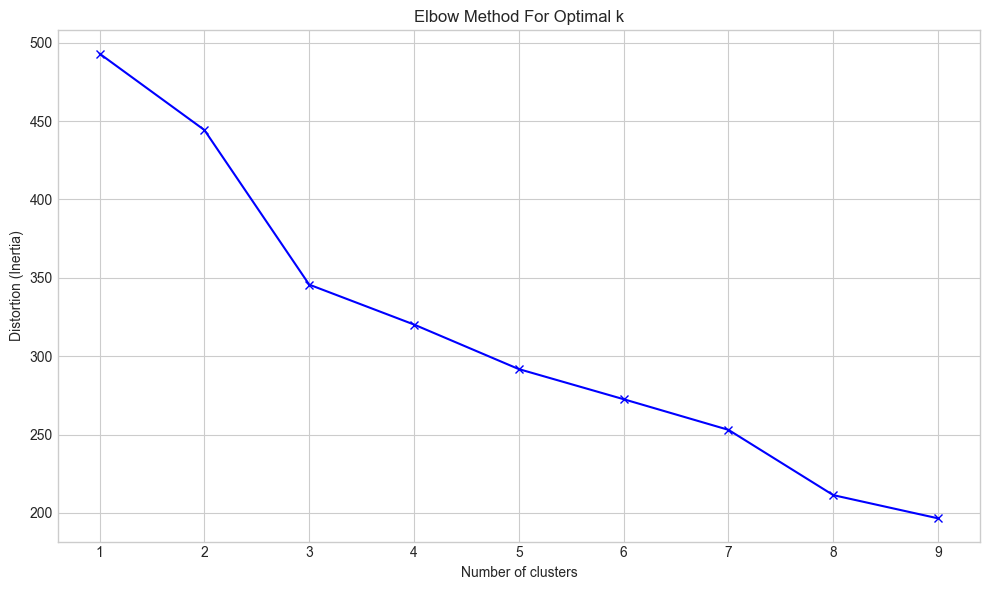


=== Cluster vs. Shanty Type Distribution ===
shanty_type  BUNT  FORE-SHEET OR SWEATING-UP  HALLIARD  WINDLASS CAPSTAN
cluster                                                                 
0               0                          0         2                 6
1               0                          0         1                 5
2               1                          1         1                 2
3               0                          1         5                 4


<Figure size 1200x800 with 0 Axes>

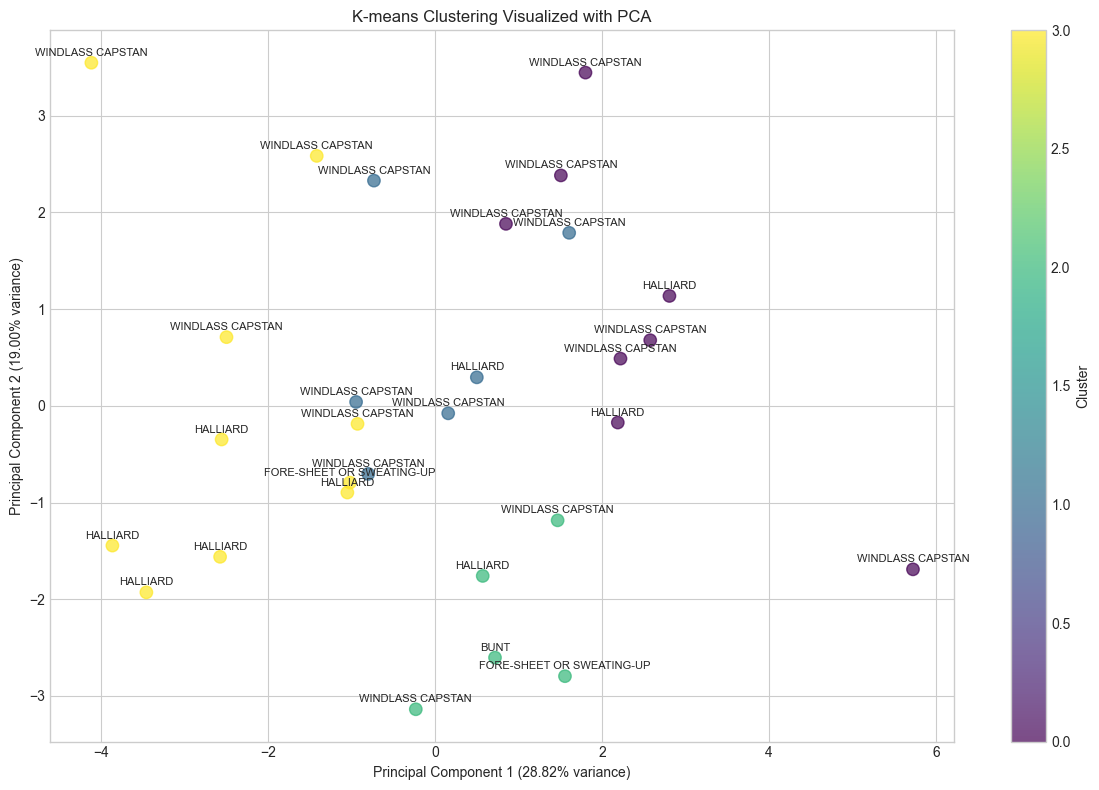

<Figure size 1200x800 with 0 Axes>

In [79]:
# Check if we have enough samples for clustering
if len(df) < 3:
    print("Not enough samples for clustering analysis")
else:
    # Determine the optimal number of clusters using the Elbow method
    distortions = []
    K_range = range(1, min(10, len(df)))
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(scaled_features)
        distortions.append(kmeans.inertia_)
    
    # Plot the Elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, distortions, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion (Inertia)')
    plt.title('Elbow Method For Optimal k')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Save the figure
    plt.savefig('plots/kmeans_elbow_curve.png', dpi=300, bbox_inches='tight')
    
    # Choose the number of clusters (either from known shanty types or from elbow method)
    true_n_clusters = len(df['shanty_type'].unique())
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=true_n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    
    # Add cluster labels to the dataframe for analysis
    df_with_clusters = df.copy()
    df_with_clusters['cluster'] = cluster_labels
    
    # Compare clusters with shanty types
    cluster_vs_type = pd.crosstab(df_with_clusters['cluster'], df_with_clusters['shanty_type'])
    print("\n=== Cluster vs. Shanty Type Distribution ===")
    print(cluster_vs_type)
    
    # Visualize clusters using PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_features)
    
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, 
                         cmap='viridis', alpha=0.7, s=80)
    
    # Add shanty type labels
    for i, point in enumerate(pca_result):
        plt.annotate(df['shanty_type'].iloc[i],
                    (point[0], point[1]),
                    textcoords="offset points", 
                    xytext=(0, 5),
                    ha='center',
                    fontsize=8)
    
    plt.colorbar(scatter, label='Cluster')
    plt.title('K-means Clustering Visualized with PCA')
    plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Save the figure
    plt.savefig('plots/kmeans_clusters_pca.png', dpi=300, bbox_inches='tight')

## 8. Classification Analysis

Finally, let's attempt to build a machine learning model to predict shanty type 
from musical features, even with our limited dataset.


=== Classification Analysis (Exploratory) ===
Note: Limited data may cause overfitting or unreliable results.

Confusion Matrix:
[[1 0]
 [5 2]]

Classification Report:
                  precision    recall  f1-score   support

        HALLIARD       0.17      1.00      0.29         1
WINDLASS CAPSTAN       1.00      0.29      0.44         7

        accuracy                           0.38         8
       macro avg       0.58      0.64      0.37         8
    weighted avg       0.90      0.38      0.42         8


Feature Importance:
                           Feature  Importance
14            score_length_in_bars    0.156185
1            average_note_duration    0.094954
11                  rest_frequency    0.077651
8               note_count_per_bar    0.077560
15                     syncopation    0.076193
3        entropy_of_pitch_sequence    0.069006
16        variance_in_note_density    0.066654
6       melodic_contour_complexity    0.058198
5                   leap_frequency  

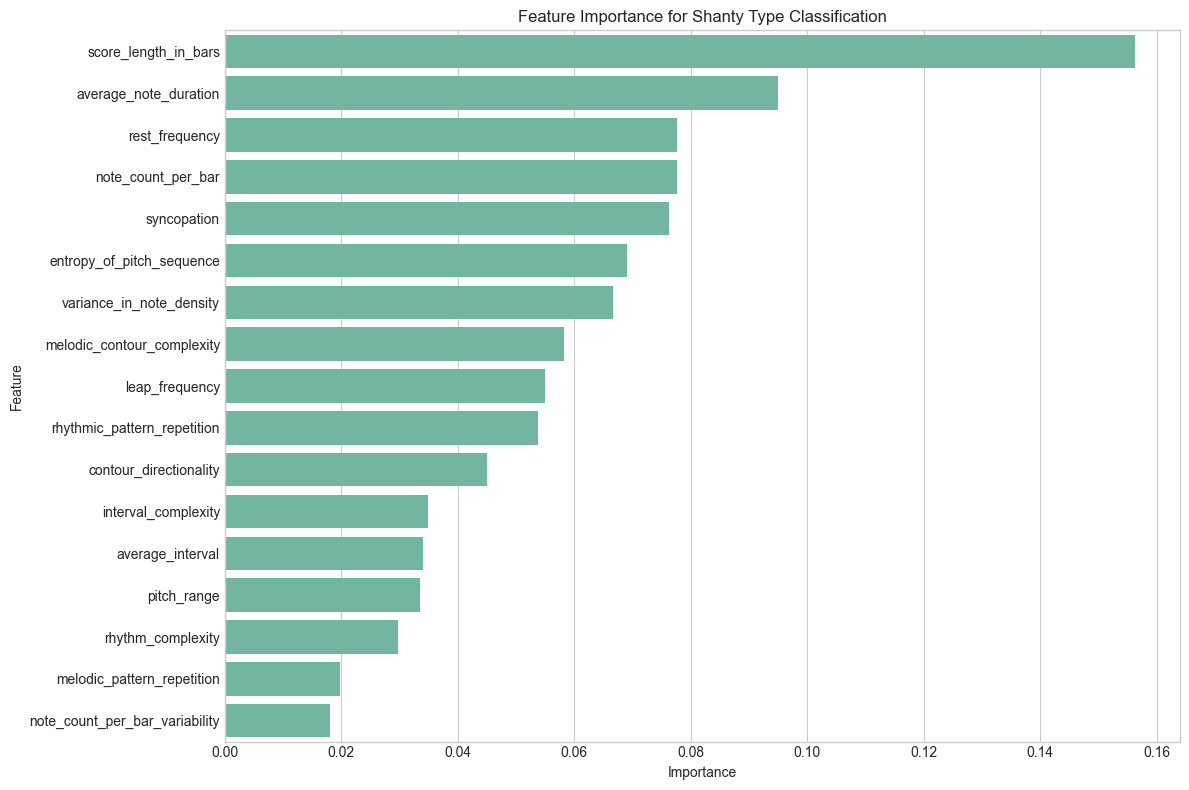

<Figure size 1200x800 with 0 Axes>

In [81]:
# Classification analysis - attempt even with limited data
print("\n=== Classification Analysis (Exploratory) ===")
print("Note: Limited data may cause overfitting or unreliable results.")

X = df[feature_cols].values
y = df['shanty_type'].values

try:
    # Split data for evaluation (with a smaller test set due to limited data)
    test_size = min(0.3, 1/len(df['shanty_type'].unique()))
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )
    
    # Train a RandomForest classifier with adjusted parameters for small datasets
    clf = RandomForestClassifier(
        n_estimators=50,  # Smaller number of trees
        max_depth=3,      # Limit tree depth to prevent overfitting
        min_samples_leaf=1,
        random_state=42
    )
    clf.fit(X_train, y_train)
    
    # Evaluate
    y_pred = clf.predict(X_test)
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': clf.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance:")
    print(feature_importance)
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance for Shanty Type Classification')
    plt.tight_layout()
    plt.show()
    
    # Save the figure
    plt.savefig('plots/feature_importance.png', dpi=300, bbox_inches='tight')
    
except Exception as e:
    print(f"Classification analysis failed: {str(e)}")


=== Predicting Shanty Types for 'Unknown' Samples ===
        filename shanty_name    predicted_type  prob_BUNT  \
1   music01.midi     Unknown          HALLIARD      0.160   
8   music07.midi     Unknown          HALLIARD      0.170   
17  music10.midi     Unknown          HALLIARD      0.114   
19  music06.midi     Unknown          HALLIARD      0.110   
23  music05.midi     Unknown  WINDLASS CAPSTAN      0.090   

    prob_FORE-SHEET OR SWEATING-UP  prob_HALLIARD  prob_WINDLASS CAPSTAN  
1                         0.212000       0.594833               0.033167  
8                         0.054000       0.468167               0.307833  
17                        0.156667       0.565333               0.164000  
19                        0.134000       0.688318               0.067682  
23                        0.204000       0.324000               0.382000  

=== Prediction Results Summary ===
Total predictions: 93
Low Confidence: 63 (67.7%)
High Confidence: 30 (32.3%)

=== Shanty Typ

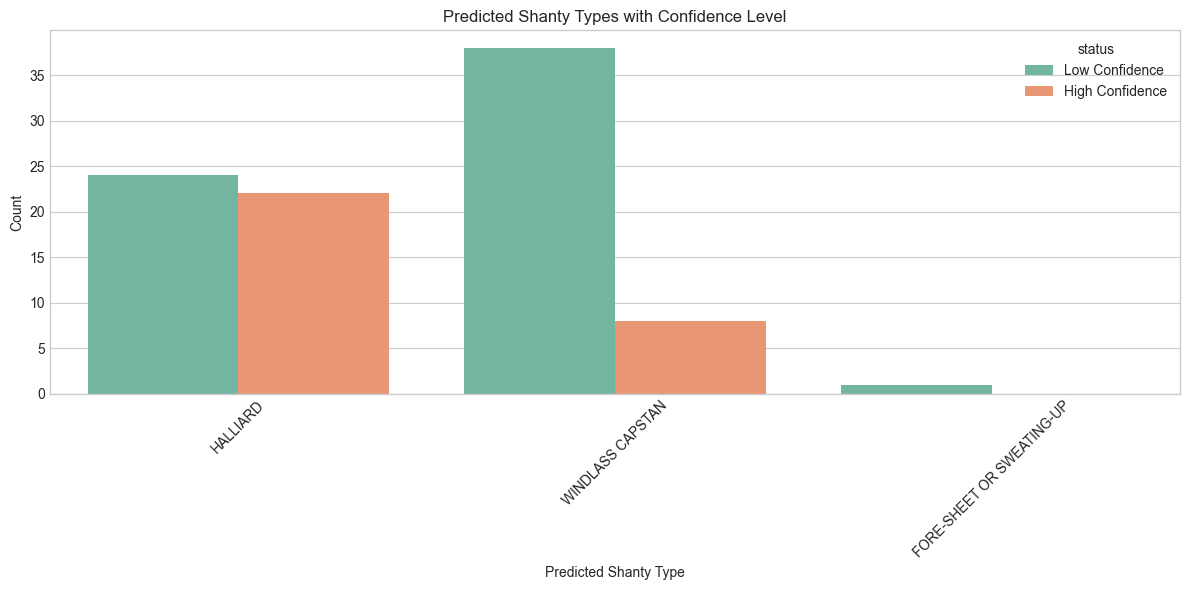


=== Examples from Each Prediction Category ===

Low Confidence Examples:
  music01.midi: HALLIARD (confidence: 0.59)
  music07.midi: HALLIARD (confidence: 0.47)

High Confidence Examples:
  music06.midi: HALLIARD (confidence: 0.69)
  music09.midi: HALLIARD (confidence: 0.68)

Predictions saved to 'shanty_predictions.csv'


<Figure size 1200x800 with 0 Axes>

In [83]:
# Bonus: Predict shanty types for the 'Unknown' samples
if 'Unknown' in df_original['shanty_type'].values:
    print("\n=== Predicting Shanty Types for 'Unknown' Samples ===")
    unknown_df = df_original[df_original['shanty_type'] == 'Unknown']
    unknown_X = unknown_df[feature_cols].values
    
    # Make predictions
    unknown_pred = clf.predict(unknown_X)
    unknown_pred_proba = clf.predict_proba(unknown_X)
    
    # Create a DataFrame of predictions
    unknown_results = pd.DataFrame({
        'filename': unknown_df['filename'],
        'shanty_name': unknown_df['shanty_name'],
        'predicted_type': unknown_pred
    })
    
    # Add prediction probabilities
    for i, class_name in enumerate(clf.classes_):
        unknown_results[f'prob_{class_name}'] = unknown_pred_proba[:, i]
    
    print(unknown_results.head())

    # Enhanced classification with confidence thresholds
    confidence_threshold = 0.60  # Only accept predictions with 60%+ confidence
    
    predictions = []
    for i, row in unknown_df.iterrows():
        shanty_name = row['shanty_name']
        features = row[feature_cols].values.reshape(1, -1)
        
        pred = clf.predict(features)[0]
        proba = clf.predict_proba(features)[0]
        max_proba = proba.max()
        
        if max_proba >= confidence_threshold:
            prediction_status = "High Confidence"
        else:
            prediction_status = "Low Confidence"
            
        predictions.append({
            'filename': row['filename'],
            'shanty_name': shanty_name,
            'predicted_type': pred,
            'confidence': max_proba,
            'status': prediction_status
        })

    predictions_df = pd.DataFrame(predictions)
    
    # For low confidence predictions, find most similar known shanties
    def find_similar_shanties(unknown_features, known_df, feature_cols, n=3):
        """Find most similar known shanties based on feature distance"""
        similarities = []
        
        for i, row in known_df.iterrows():
            known_features = row[feature_cols].values
            # Calculate Euclidean distance
            distance = np.sqrt(np.sum((unknown_features - known_features)**2))
            similarities.append({
                'shanty_name': row['shanty_name'],
                'shanty_type': row['shanty_type'],
                'distance': distance
            })
        
        # Sort by similarity (smallest distance first)
        similarities.sort(key=lambda x: x['distance'])
        return similarities[:n]

    # Apply to low confidence predictions
    for i, row in predictions_df[predictions_df['status'] == 'Low Confidence'].iterrows():
        unknown_features = unknown_df.loc[unknown_df['shanty_name'] == row['shanty_name'], feature_cols].values[0]
        similar_shanties = find_similar_shanties(unknown_features, df, feature_cols)
        
        # If most similar shanties agree on type, use that instead
        types = [s['shanty_type'] for s in similar_shanties]
        if len(set(types)) == 1:  # All agree
            predictions_df.loc[i, 'predicted_type'] = types[0]
            predictions_df.loc[i, 'status'] = "Feature Similarity"
    
    # Summarize results
    print("\n=== Prediction Results Summary ===")
    status_counts = predictions_df['status'].value_counts()
    print(f"Total predictions: {len(predictions_df)}")
    for status, count in status_counts.items():
        print(f"{status}: {count} ({count/len(predictions_df)*100:.1f}%)")
    
    print("\n=== Shanty Type Predictions ===")
    type_counts = predictions_df['predicted_type'].value_counts()
    print(type_counts)
    
    # Visualize prediction distribution
    plt.figure(figsize=(12, 6))
    sns.countplot(x='predicted_type', hue='status', data=predictions_df)
    plt.title('Predicted Shanty Types with Confidence Level')
    plt.xlabel('Predicted Shanty Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Save the figure
    plt.savefig('plots/predicted_shanty_types.png', dpi=300, bbox_inches='tight')
    
    # Show examples of each prediction type
    print("\n=== Examples from Each Prediction Category ===")
    for status in predictions_df['status'].unique():
        subset = predictions_df[predictions_df['status'] == status].head(2)
        print(f"\n{status} Examples:")
        for _, row in subset.iterrows():
            print(f"  {row['filename']}: {row['predicted_type']} (confidence: {row['confidence']:.2f})")
    
    # Save final predictions to CSV
    predictions_df.to_csv('shanty_predictions.csv', index=False)
    print("\nPredictions saved to 'shanty_predictions.csv'")

## 9. Summary and Conclusions

In this exploratory data analysis, we've examined the relationships between musical features 
and shanty types. Our key findings include:

- The differences in musical features between different shanty types
- The correlations between different musical features
- The natural clustering tendencies of shanties based on their musical features
- The most important features for distinguishing between shanty types

These findings help us understand how the musical characteristics of shanties relate 
to their functional roles in maritime work.

# Advanced Shanty Type Classification with Machine Learning Models

This section performs comprehensive machine learning analysis to classify shanty types 
based on their musical features. We'll implement multiple classification algorithms,
feature selection, hyperparameter tuning, and thorough evaluation methods.

In [85]:
# Import additional ML libraries
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import warnings
from scipy.stats import randint, uniform

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

## 1. Data Preparation

First, we'll prepare our data for machine learning, standardizing features and
setting up train/test splits.

In [87]:
print(f"Dataset for classification: {len(df)} shanties with {len(feature_cols)} features")
print(f"Shanty types: {df['shanty_type'].unique()}")
print(f"Shanty type distribution:")
print(df['shanty_type'].value_counts())

# Prepare X (features) and y (target labels)
X = df[feature_cols].values
y = df['shanty_type'].values

# Check if we have enough samples for meaningful classification
if len(df) < 5 or len(df['shanty_type'].unique()) < 2:
    print("Warning: Limited data for classification. Results may not be reliable.")

# Check if any class has too few samples
class_counts = df['shanty_type'].value_counts()
min_class_count = class_counts.min()

# Decide whether to use stratification
use_stratify = len(df) > 10 and min_class_count >= 2

if not use_stratify and len(df) > 10:
    print(f"Warning: Disabling stratification because the least populated class has only {min_class_count} sample(s).")

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y if use_stratify else None
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scale all features for later use
X_scaled = scaler.fit_transform(X)

Dataset for classification: 29 shanties with 17 features
Shanty types: ['WINDLASS CAPSTAN' 'HALLIARD' 'FORE-SHEET OR SWEATING-UP' 'BUNT']
Shanty type distribution:
shanty_type
WINDLASS CAPSTAN             17
HALLIARD                      9
FORE-SHEET OR SWEATING-UP     2
BUNT                          1
Name: count, dtype: int64
Training set: 21 samples
Test set: 8 samples


## 2. Feature Selection

Let's identify the most informative features using multiple methods.

=== Univariate Feature Selection ===
Top features by univariate F-test:
                        Feature     Score   P-value
14         score_length_in_bars  7.106735  0.002662
11               rest_frequency  3.316498  0.045013
1         average_note_duration  2.943063  0.062706
13  rhythmic_pattern_repetition  2.873250  0.066798
15                  syncopation  2.692198  0.078841
10                  pitch_range  2.336398  0.110047
3     entropy_of_pitch_sequence  1.900664  0.167830
8            note_count_per_bar  1.529831  0.242958
6    melodic_contour_complexity  1.148337  0.358135
0              average_interval  1.116818  0.369865


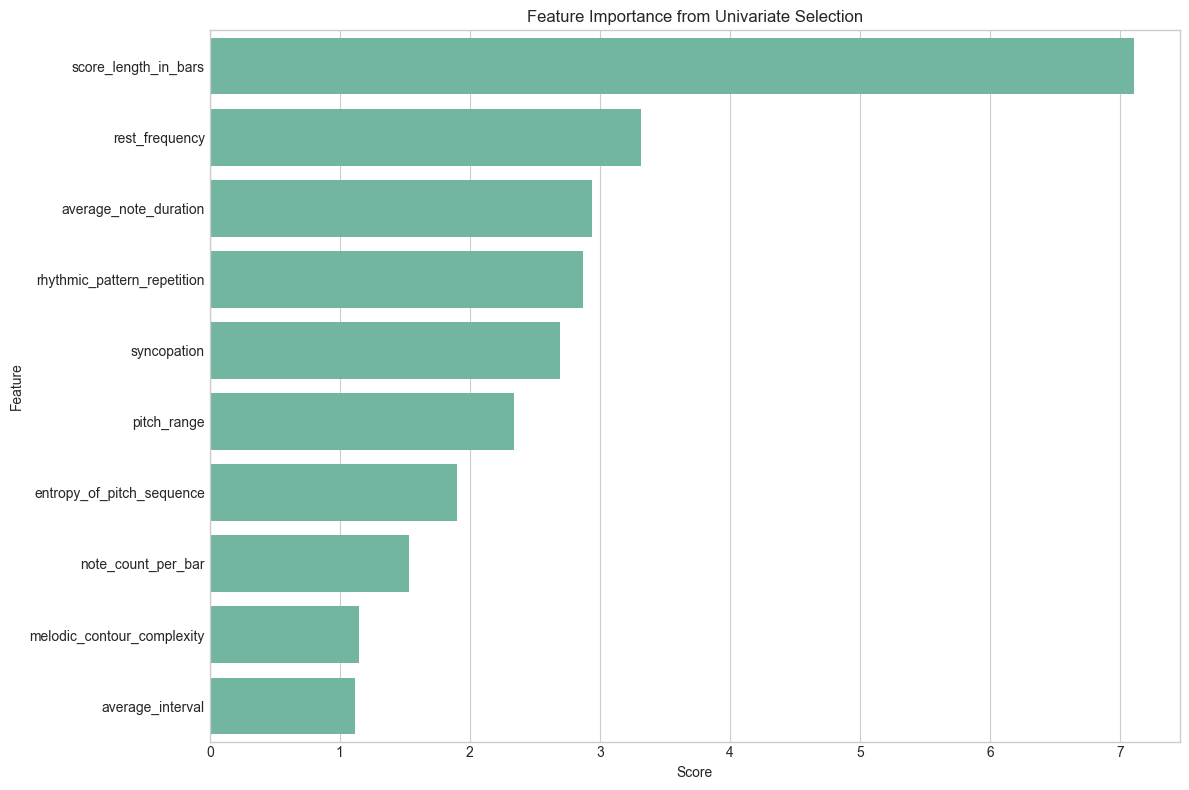


=== Random Forest Feature Importance ===
Top features by Random Forest importance:
                        Feature  Importance
14         score_length_in_bars    0.142648
1         average_note_duration    0.106956
11               rest_frequency    0.084848
15                  syncopation    0.078411
8            note_count_per_bar    0.059522
3     entropy_of_pitch_sequence    0.058615
13  rhythmic_pattern_repetition    0.057794
6    melodic_contour_complexity    0.056356
5                leap_frequency    0.056352
16     variance_in_note_density    0.049197


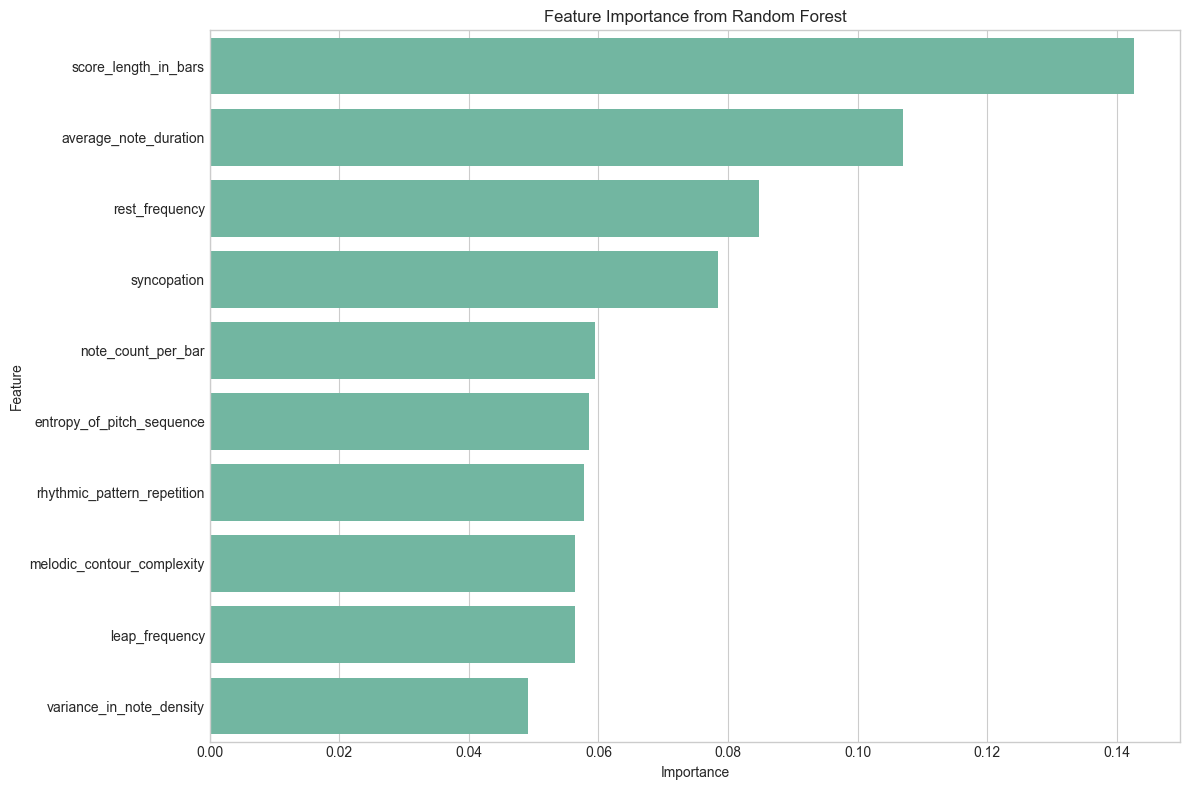


=== Recursive Feature Elimination ===
Selected features by RFE: ['contour_directionality', 'note_count_per_bar_variability', 'rest_frequency', 'rhythm_complexity', 'rhythmic_pattern_repetition', 'score_length_in_bars', 'syncopation', 'variance_in_note_density']


In [88]:
# A. Univariate Feature Selection
print("=== Univariate Feature Selection ===")
selector = SelectKBest(f_classif, k=min(10, len(feature_cols)))
X_new = selector.fit_transform(X_train_scaled, y_train)

# Get feature scores and p-values
feature_scores = pd.DataFrame({
    'Feature': feature_cols,
    'Score': selector.scores_,
    'P-value': selector.pvalues_
})
feature_scores = feature_scores.sort_values('Score', ascending=False)

print("Top features by univariate F-test:")
print(feature_scores.head(10))

# Visualize feature scores
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_scores.head(10))
plt.title('Feature Importance from Univariate Selection')
plt.tight_layout()
plt.show()

# B. Random Forest Feature Importance
print("\n=== Random Forest Feature Importance ===")
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train_scaled, y_train)

feature_importance_rf = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_selector.feature_importances_
})
feature_importance_rf = feature_importance_rf.sort_values('Importance', ascending=False)

print("Top features by Random Forest importance:")
print(feature_importance_rf.head(10))

# Visualize RF feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_rf.head(10))
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.show()

# C. Recursive Feature Elimination
try:
    print("\n=== Recursive Feature Elimination ===")
    # Use a simpler model for RFE
    estimator = DecisionTreeClassifier(random_state=42)
    # Select half of the features
    rfe = RFE(estimator=estimator, n_features_to_select=max(3, len(feature_cols)//2), step=1)
    rfe.fit(X_train_scaled, y_train)
    
    # Get selected features
    selected_features = [feature_cols[i] for i in range(len(feature_cols)) if rfe.support_[i]]
    print(f"Selected features by RFE: {selected_features}")
except Exception as e:
    print(f"RFE failed: {e}")
    selected_features = feature_cols  # Use all features if RFE fails

## 3. Model Training and Hyperparameter Tuning

We'll train several classification models and optimize their parameters.

In [89]:
# Create a list of models to try
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'k-NN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Define parameter grids for each model
param_grids = {
    'Decision Tree': {
        'max_depth': [None, 3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'linear']
    },
    'k-NN': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  # Manhattan or Euclidean distance
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1', 'l2']
    }
}

# Function to tune hyperparameters for a model
def tune_model(model_name, model, param_grid, X_train, y_train, cv=3):
    print(f"\nTuning hyperparameters for {model_name}...")
    
    # Check if we have enough data for meaningful CV
    if len(X_train) < 10:
        print(f"Not enough data for proper CV. Using default parameters for {model_name}.")
        model.fit(X_train, y_train)
        return model
    
    # Use RandomizedSearchCV if there are too many combinations
    n_combinations = np.prod([len(values) for values in param_grid.values()])
    
    if n_combinations > 20:
        print(f"Using RandomizedSearchCV with {min(20, n_combinations)} combinations")
        search = RandomizedSearchCV(
            model, param_grid, n_iter=min(20, n_combinations),
            cv=cv, scoring='accuracy', random_state=42, n_jobs=-1
        )
    else:
        print(f"Using GridSearchCV with {n_combinations} combinations")
        search = GridSearchCV(
            model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1
        )
    
    search.fit(X_train, y_train)
    print(f"Best parameters: {search.best_params_}")
    print(f"Best cross-validation score: {search.best_score_:.3f}")
    
    return search.best_estimator_

# Train and tune models
best_models = {}
cv_scores = {}

for name, model in models.items():
    try:
        # Tune hyperparameters if enough data, otherwise use default parameters
        if len(X_train) >= 10:
            best_model = tune_model(name, model, param_grids[name], X_train_scaled, y_train, 
                                    cv=min(3, len(X_train)))
        else:
            print(f"\nUsing default parameters for {name} due to limited data")
            best_model = model
            best_model.fit(X_train_scaled, y_train)
        
        # Store the best model
        best_models[name] = best_model
        
        # Evaluate with cross-validation if possible
        if len(X_train) >= 9:  # Minimum for 3-fold CV
            cv = min(3, len(X_train) // len(np.unique(y_train)))
            scores = cross_val_score(best_model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
            cv_scores[name] = scores
            print(f"CV Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")
        else:
            print("Skipping cross-validation due to limited data")
            
    except Exception as e:
        print(f"Error tuning {name}: {e}")


Tuning hyperparameters for Decision Tree...
Using RandomizedSearchCV with 20 combinations
Best parameters: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}
Best cross-validation score: 0.714
CV Accuracy: 0.714 ± 0.000

Tuning hyperparameters for Random Forest...
Using RandomizedSearchCV with 20 combinations
Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
Best cross-validation score: 0.619
CV Accuracy: 0.619 ± 0.135

Tuning hyperparameters for Gradient Boosting...
Using RandomizedSearchCV with 20 combinations
Best parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01}
Best cross-validation score: 0.619
CV Accuracy: 0.619 ± 0.135

Tuning hyperparameters for SVM...
Using RandomizedSearchCV with 20 combinations
Best parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 1}
Best cross-validation score: 0.619
CV Accuracy: 0.619 ± 0.135

Tuning hyperparameters for k-NN...
Using GridSearchCV with 16 combi

/Users/sid/Developer/Python/shanties/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sid/Developer/Python/shanties/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sid/Developer/Python/shanties/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sid/Developer/Python/shanties/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
     

## 4. Model Evaluation

Now, let's evaluate our models on the test set and compare their performance.


=== Evaluation for Decision Tree ===
Accuracy: 0.250

Classification Report:
                           precision    recall  f1-score   support

FORE-SHEET OR SWEATING-UP       0.00      0.00      0.00         0
                 HALLIARD       0.17      1.00      0.29         1
         WINDLASS CAPSTAN       1.00      0.14      0.25         7

                 accuracy                           0.25         8
                macro avg       0.39      0.38      0.18         8
             weighted avg       0.90      0.25      0.25         8



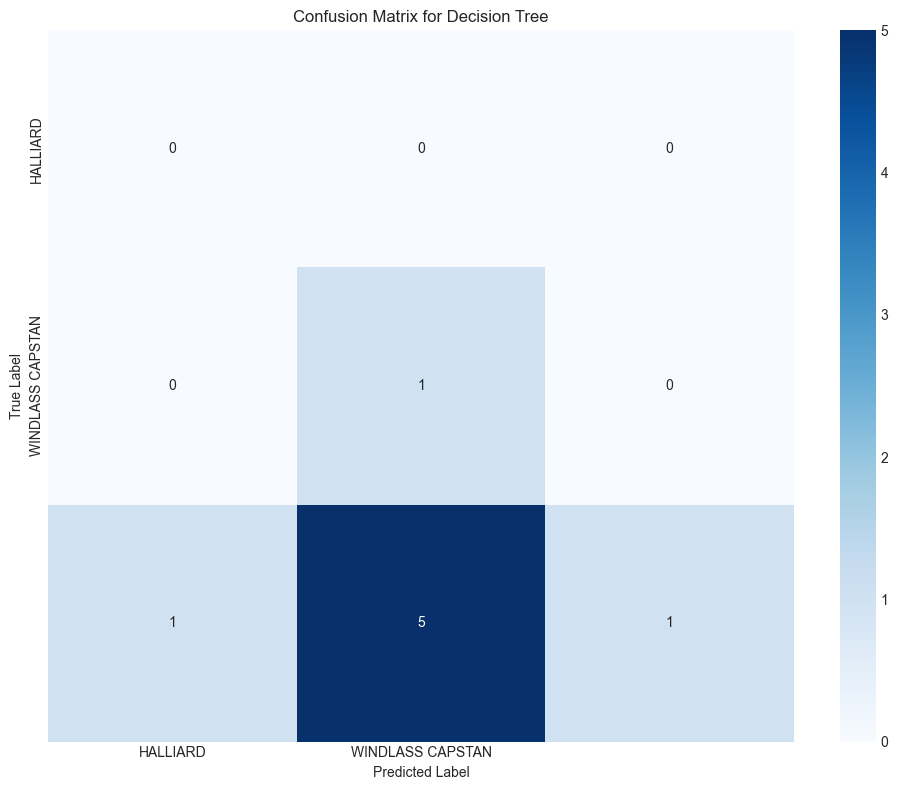

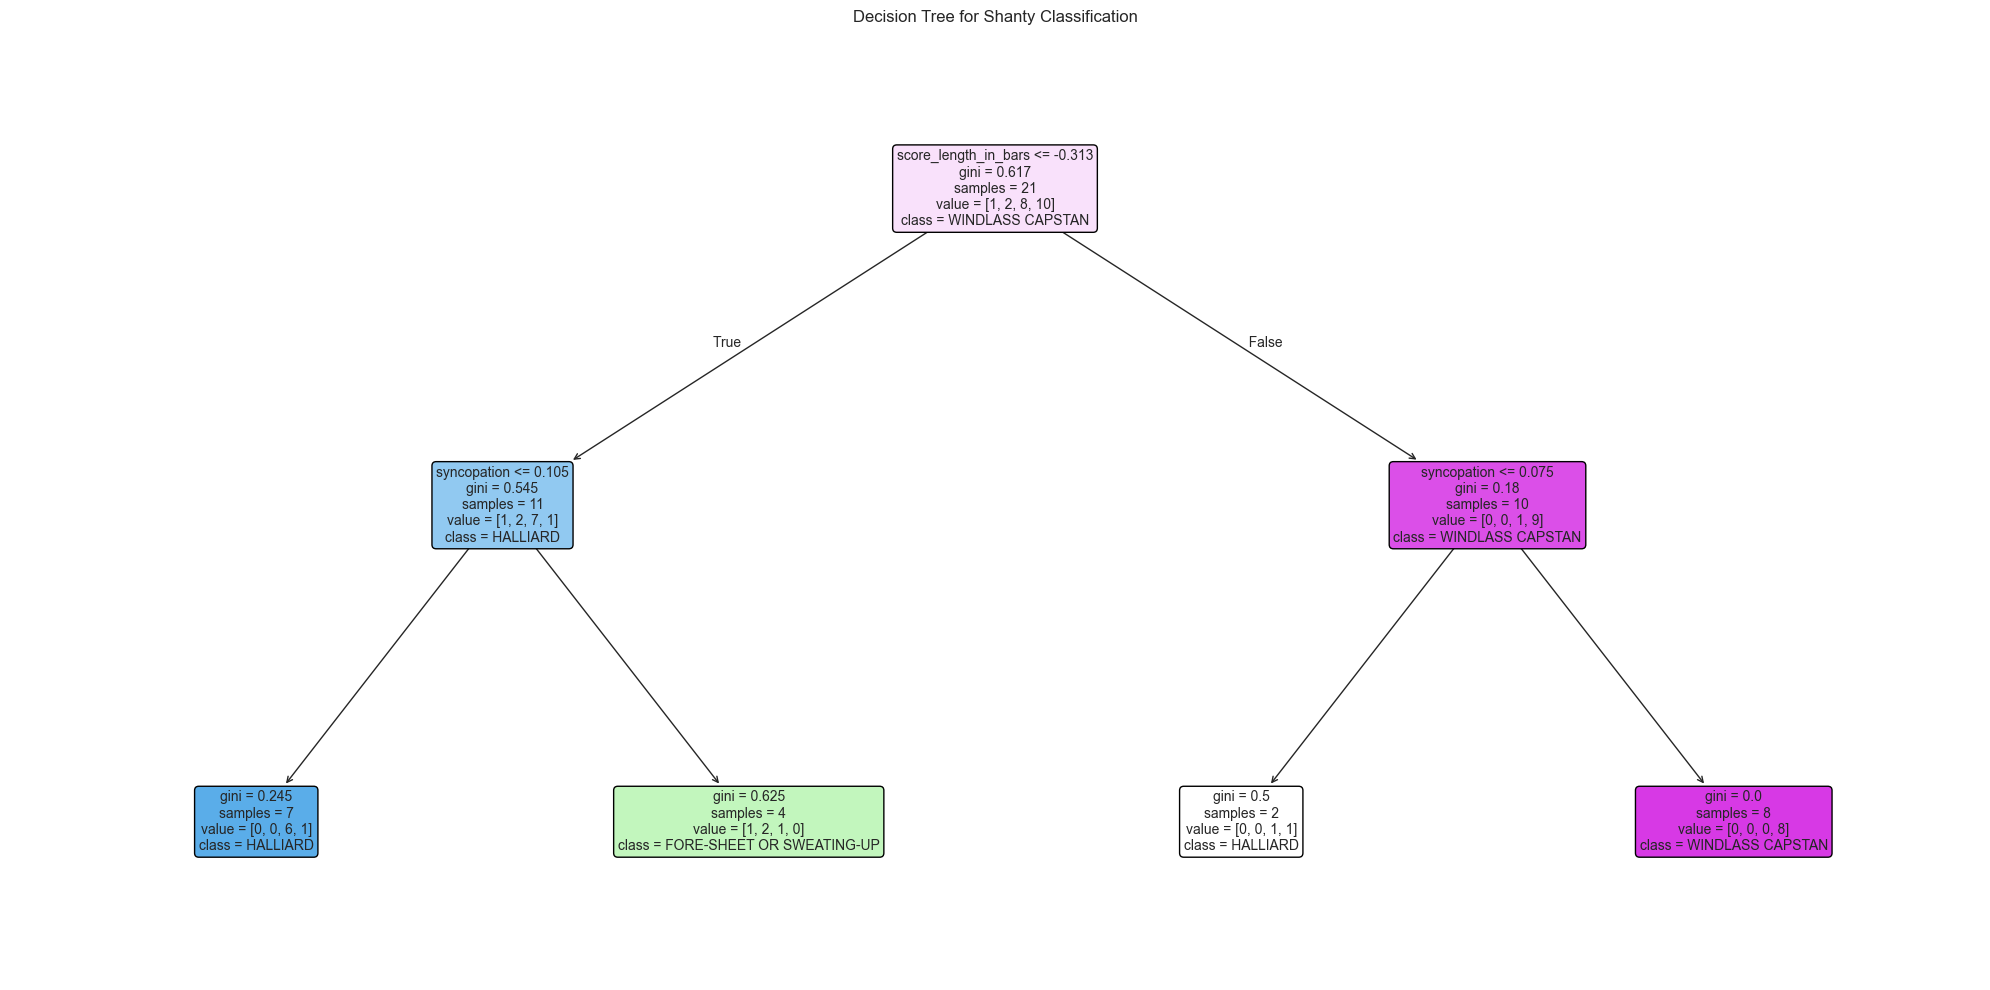


=== Evaluation for Random Forest ===
Accuracy: 0.625

Classification Report:
                  precision    recall  f1-score   support

        HALLIARD       0.25      1.00      0.40         1
WINDLASS CAPSTAN       1.00      0.57      0.73         7

        accuracy                           0.62         8
       macro avg       0.62      0.79      0.56         8
    weighted avg       0.91      0.62      0.69         8



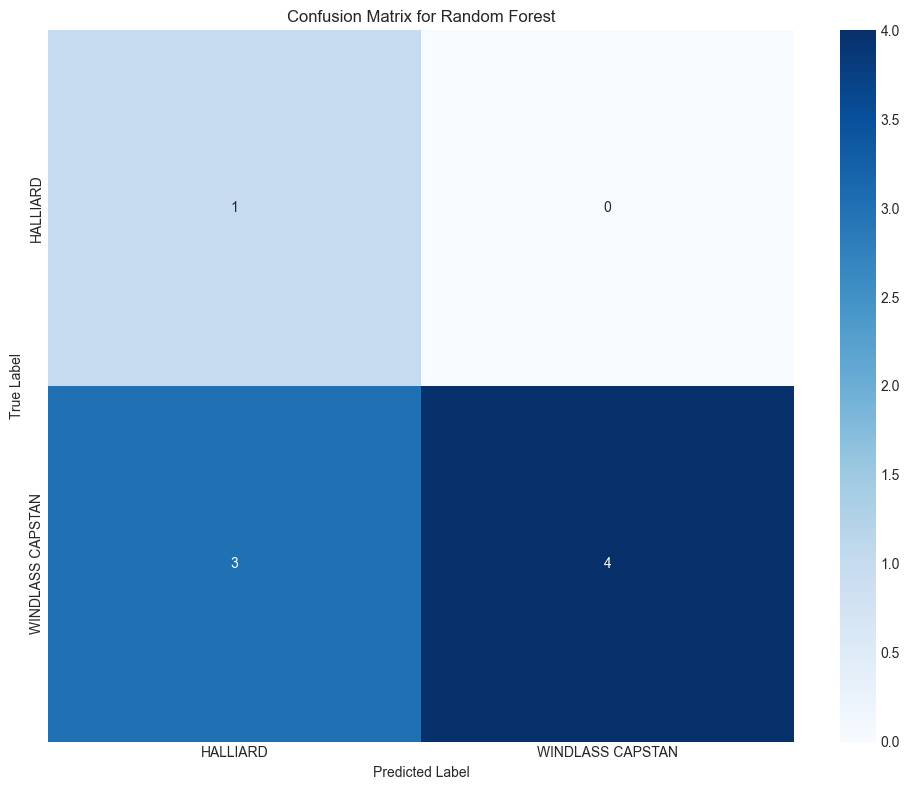


=== Evaluation for Gradient Boosting ===
Accuracy: 0.250

Classification Report:
                  precision    recall  f1-score   support

        HALLIARD       0.00      0.00      0.00         1
WINDLASS CAPSTAN       0.67      0.29      0.40         7

        accuracy                           0.25         8
       macro avg       0.33      0.14      0.20         8
    weighted avg       0.58      0.25      0.35         8



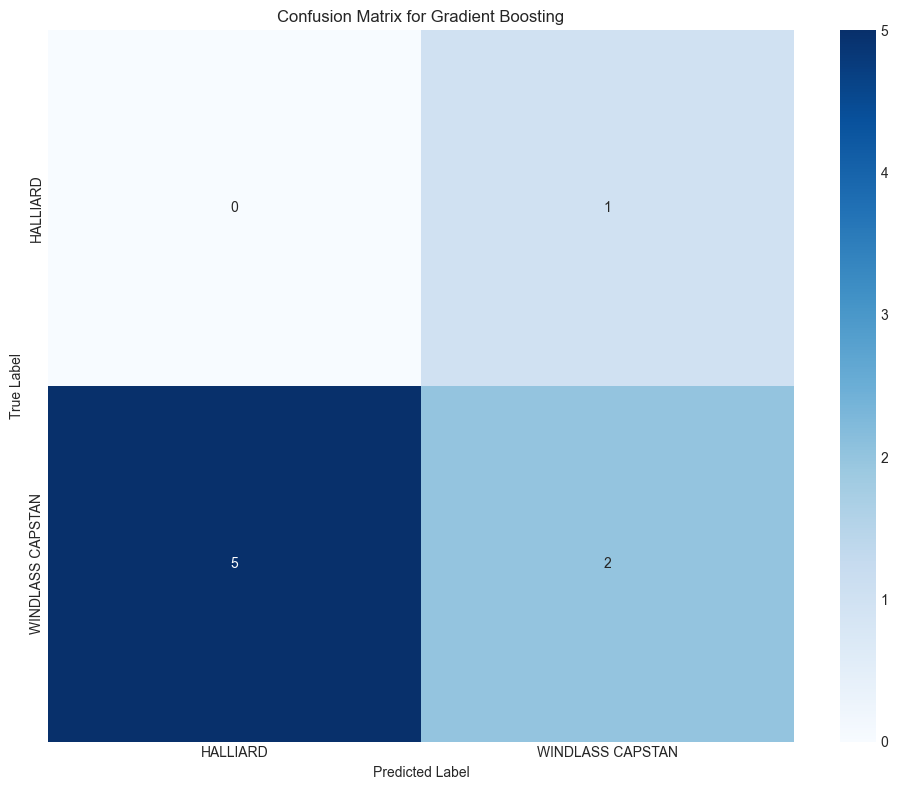


=== Evaluation for SVM ===
Accuracy: 0.500

Classification Report:
                  precision    recall  f1-score   support

        HALLIARD       0.20      1.00      0.33         1
WINDLASS CAPSTAN       1.00      0.43      0.60         7

        accuracy                           0.50         8
       macro avg       0.60      0.71      0.47         8
    weighted avg       0.90      0.50      0.57         8



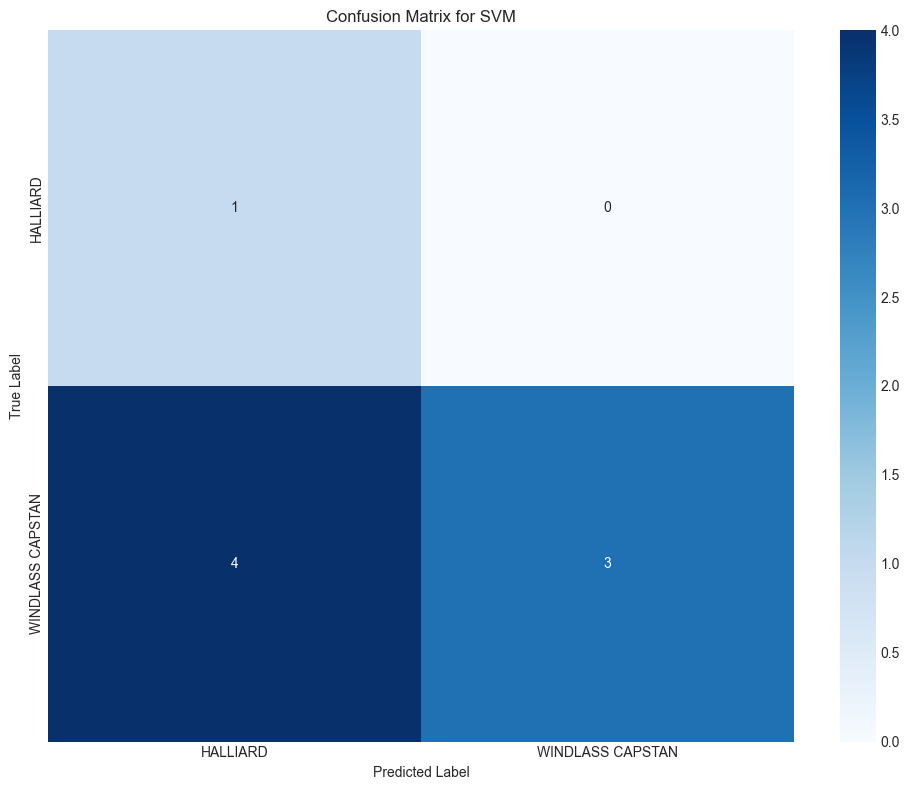


=== Evaluation for k-NN ===
Accuracy: 0.500

Classification Report:
                  precision    recall  f1-score   support

        HALLIARD       0.20      1.00      0.33         1
WINDLASS CAPSTAN       1.00      0.43      0.60         7

        accuracy                           0.50         8
       macro avg       0.60      0.71      0.47         8
    weighted avg       0.90      0.50      0.57         8



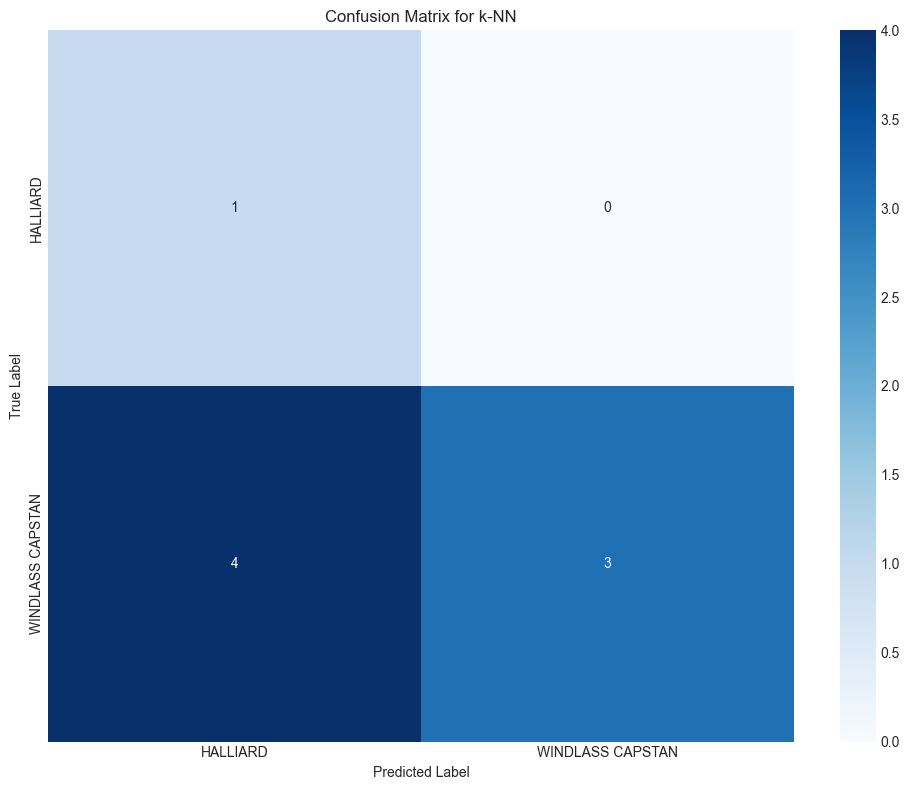


=== Evaluation for Logistic Regression ===
Accuracy: 0.375

Classification Report:
                  precision    recall  f1-score   support

        HALLIARD       0.17      1.00      0.29         1
WINDLASS CAPSTAN       1.00      0.29      0.44         7

        accuracy                           0.38         8
       macro avg       0.58      0.64      0.37         8
    weighted avg       0.90      0.38      0.42         8



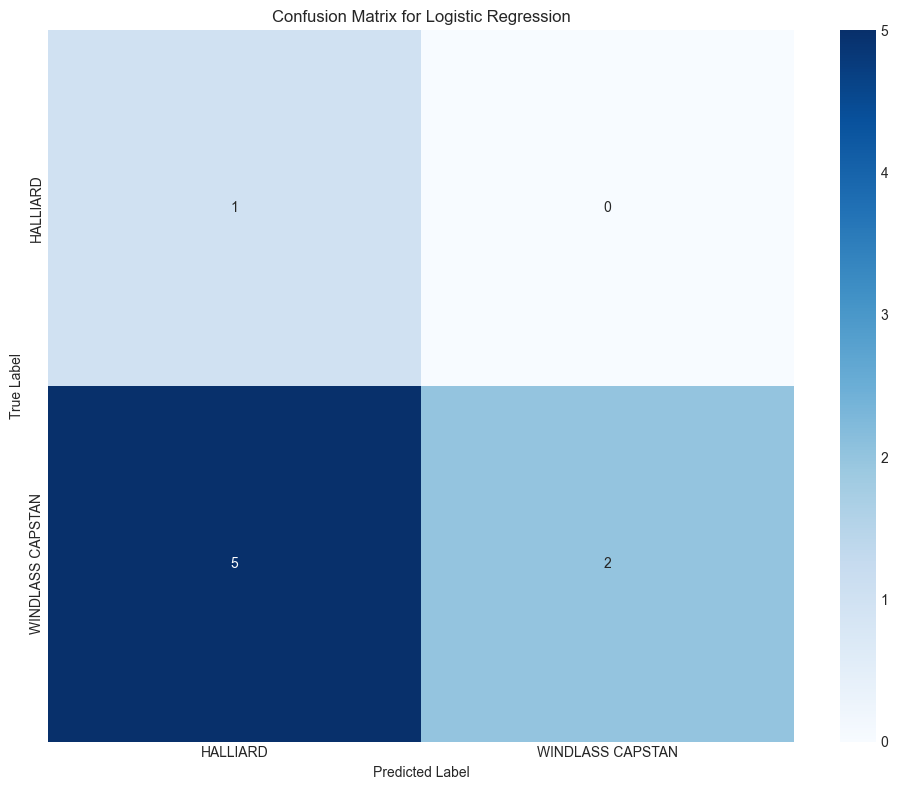


=== Model Comparison ===
                 Model  Accuracy
1        Random Forest     0.625
3                  SVM     0.500
4                 k-NN     0.500
5  Logistic Regression     0.375
0        Decision Tree     0.250
2    Gradient Boosting     0.250


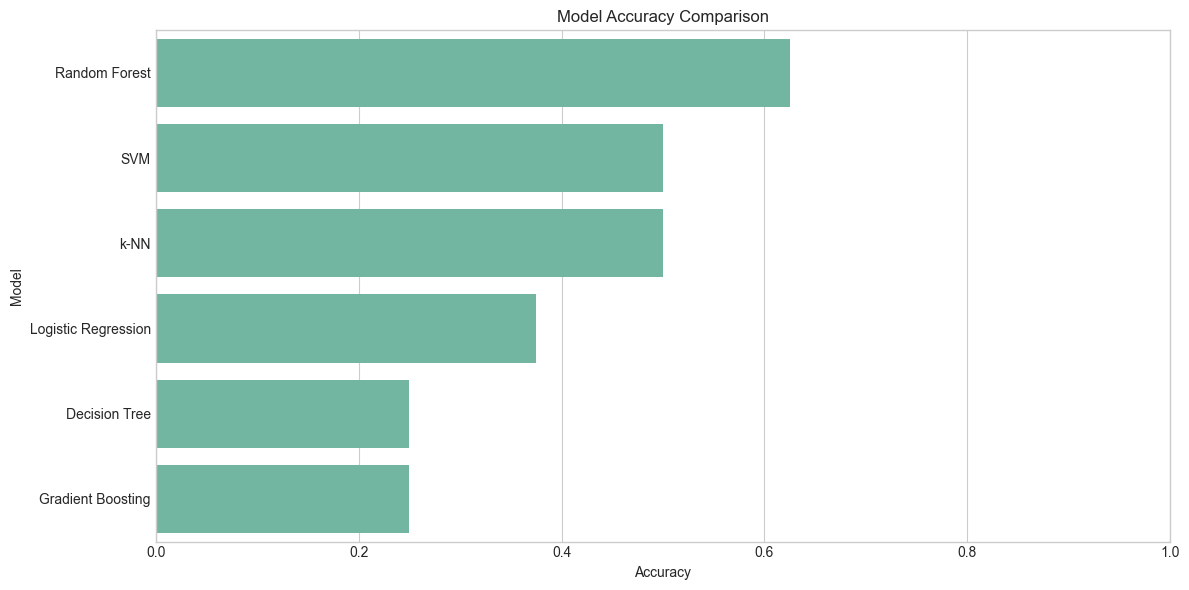

In [90]:
# Function to evaluate a model
def evaluate_model(model, model_name, X_test, y_test):
    print(f"\n=== Evaluation for {model_name} ===")
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.3f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    classes = np.unique(y_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Plot decision tree if the model is a Decision Tree
    if model_name == 'Decision Tree':
        plt.figure(figsize=(20, 10))
        plot_tree(model, filled=True, feature_names=feature_cols, 
                 class_names=list(np.unique(y)), rounded=True, fontsize=10)
        plt.title(f"Decision Tree for Shanty Classification")
        plt.tight_layout()
        plt.show()
    
    return accuracy, y_pred

# Evaluate each model
results = {}
predictions = {}

for name, model in best_models.items():
    try:
        accuracy, y_pred = evaluate_model(model, name, X_test_scaled, y_test)
        results[name] = accuracy
        predictions[name] = y_pred
    except Exception as e:
        print(f"Error evaluating {name}: {e}")

# Compare model performance
print("\n=== Model Comparison ===")
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
results_df = results_df.sort_values('Accuracy', ascending=False)
print(results_df)

# Plot model comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Accuracy', y='Model', data=results_df)
plt.title('Model Accuracy Comparison')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

## 5. Ensemble Model

Let's create an ensemble of our best models to see if we can improve performance.


=== Ensemble Model ===

=== Evaluation for Ensemble ===
Accuracy: 0.500

Classification Report:
                  precision    recall  f1-score   support

        HALLIARD       0.20      1.00      0.33         1
WINDLASS CAPSTAN       1.00      0.43      0.60         7

        accuracy                           0.50         8
       macro avg       0.60      0.71      0.47         8
    weighted avg       0.90      0.50      0.57         8



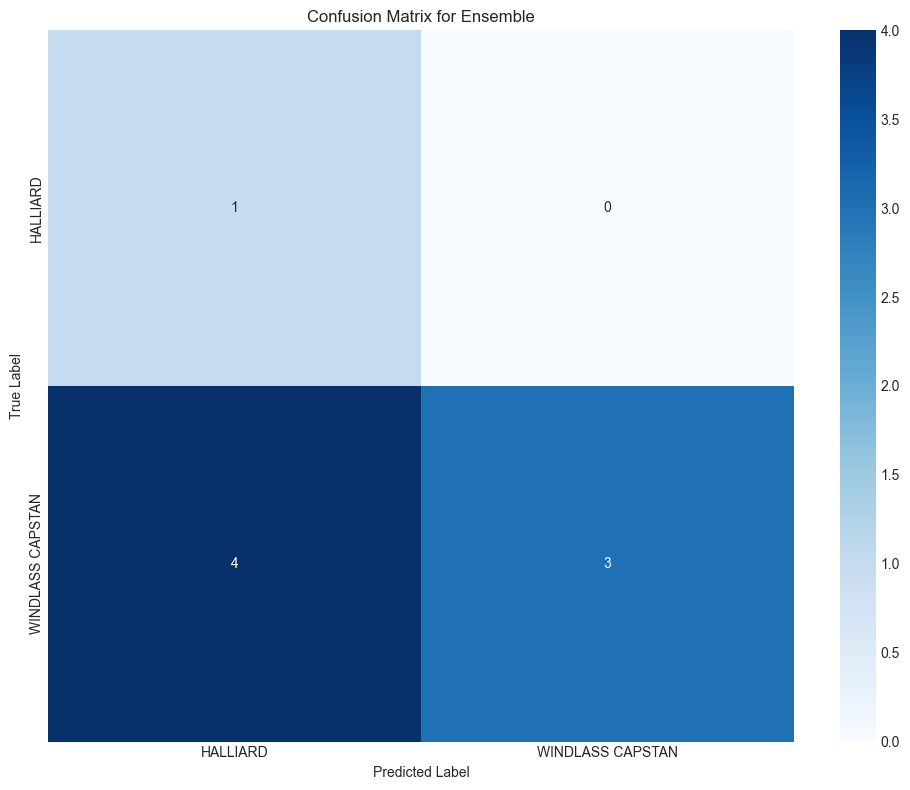


Best individual model: Random Forest with accuracy 0.625
Ensemble model accuracy: 0.500
Best individual model outperforms the ensemble

Selecting Random Forest as the final model for predictions


In [92]:
# Create a voting classifier with our top models
try:
    # Take the top 3 models or all if we have less than 3
    top_models = results_df.head(min(3, len(results_df)))
    
    if len(top_models) > 1:  # Need at least 2 models for ensemble
        print("\n=== Ensemble Model ===")
        
        estimators = []
        for model_name in top_models['Model']:
            estimators.append((model_name, best_models[model_name]))
        
        # Create and train voting classifier
        voting_clf = VotingClassifier(estimators=estimators, voting='soft')
        voting_clf.fit(X_train_scaled, y_train)
        
        # Evaluate the ensemble model
        ensemble_accuracy, ensemble_preds = evaluate_model(
            voting_clf, 'Ensemble', X_test_scaled, y_test
        )
        
        # Compare with best individual model
        best_model_name = results_df.iloc[0]['Model']
        best_model_accuracy = results_df.iloc[0]['Accuracy']
        
        print(f"\nBest individual model: {best_model_name} with accuracy {best_model_accuracy:.3f}")
        print(f"Ensemble model accuracy: {ensemble_accuracy:.3f}")
        
        if ensemble_accuracy > best_model_accuracy:
            print("Ensemble performs better than the best individual model")
            final_model = voting_clf
            final_model_name = 'Ensemble'
        else:
            print("Best individual model outperforms the ensemble")
            final_model = best_models[best_model_name]
            final_model_name = best_model_name
    else:
        print("\nNot enough models for ensemble. Using the best individual model.")
        best_model_name = results_df.iloc[0]['Model']
        final_model = best_models[best_model_name]
        final_model_name = best_model_name
except Exception as e:
    print(f"Error creating ensemble: {e}")
    # Default to the best individual model
    best_model_name = results_df.iloc[0]['Model'] if not results_df.empty else list(best_models.keys())[0]
    final_model = best_models[best_model_name]
    final_model_name = best_model_name

print(f"\nSelecting {final_model_name} as the final model for predictions")

## 6. Learning Curves

Let's examine the learning curves to understand how our model performs with different amounts of training data.


=== Learning Curves ===


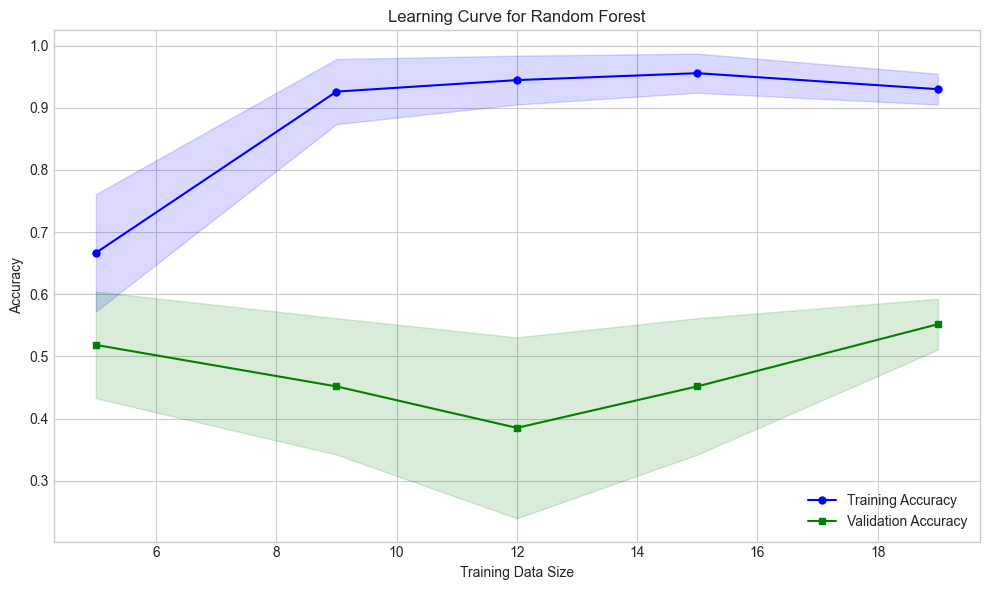

In [93]:
# Plot learning curve for the final model
if len(X) >= 10:  # Need enough data for meaningful curve
    print("\n=== Learning Curves ===")
    
    train_sizes, train_scores, test_scores = learning_curve(
        final_model, X_scaled, y, 
        train_sizes=np.linspace(0.3, 1.0, 5),
        cv=min(3, len(X) // len(np.unique(y))), 
        scoring='accuracy',
        n_jobs=-1
    )
    
    # Calculate mean and std for train/test scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', 
             markersize=5, label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, 
                    alpha=0.15, color='blue')
    
    plt.plot(train_sizes, test_mean, color='green', marker='s', 
             markersize=5, label='Validation Accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, 
                    alpha=0.15, color='green')
    
    plt.title(f'Learning Curve for {final_model_name}')
    plt.xlabel('Training Data Size')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data to generate learning curves")

## 7. Final Predictions for Unknown Shanties

Now we'll use our final model to predict the types of the 'Unknown' shanties.


=== Predicting Types for 93 Unknown Shanties ===

Predictions for Unknown Shanties:
        filename shanty_name    predicted_type  confidence  \
0   music01.midi     Unknown          HALLIARD    0.579024   
1   music07.midi     Unknown          HALLIARD    0.518833   
2   music10.midi     Unknown          HALLIARD    0.526333   
3   music06.midi     Unknown          HALLIARD    0.656190   
4   music05.midi     Unknown  WINDLASS CAPSTAN    0.397333   
..           ...         ...               ...         ...   
88   WHSKJHN.MID     Unknown          HALLIARD    0.692833   
89  CABINBOY.MID     Unknown  WINDLASS CAPSTAN    0.586333   
90  BIGLRCRW.MID     Unknown  WINDLASS CAPSTAN    0.776833   
91  ROLLHOM3.MID     Unknown  WINDLASS CAPSTAN    0.507167   
92  JACKTAR1.MID     Unknown          HALLIARD    0.552190   

   classification_status  
0         Low Confidence  
1         Low Confidence  
2         Low Confidence  
3        High Confidence  
4         Low Confidence  
..      

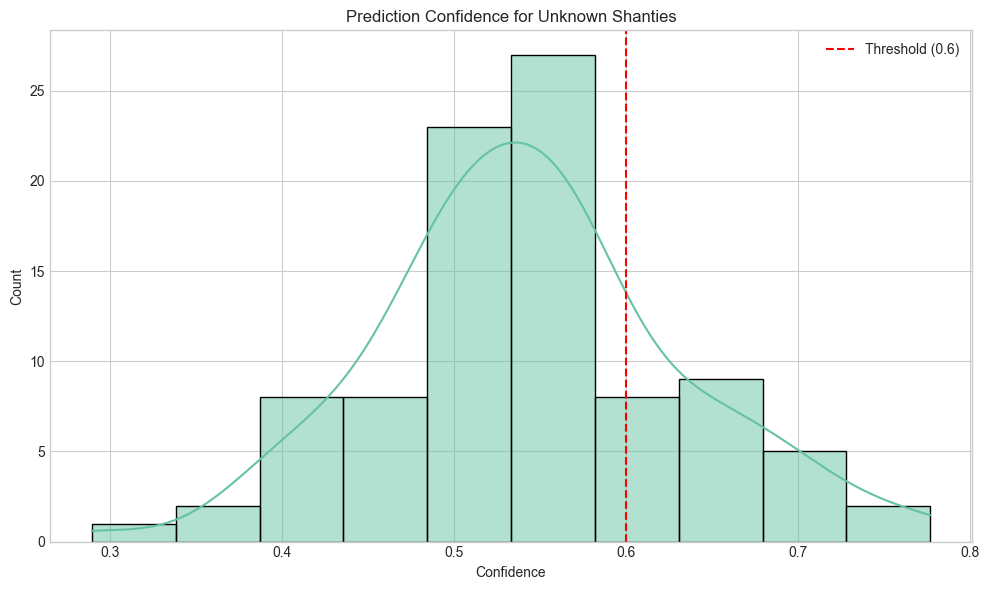

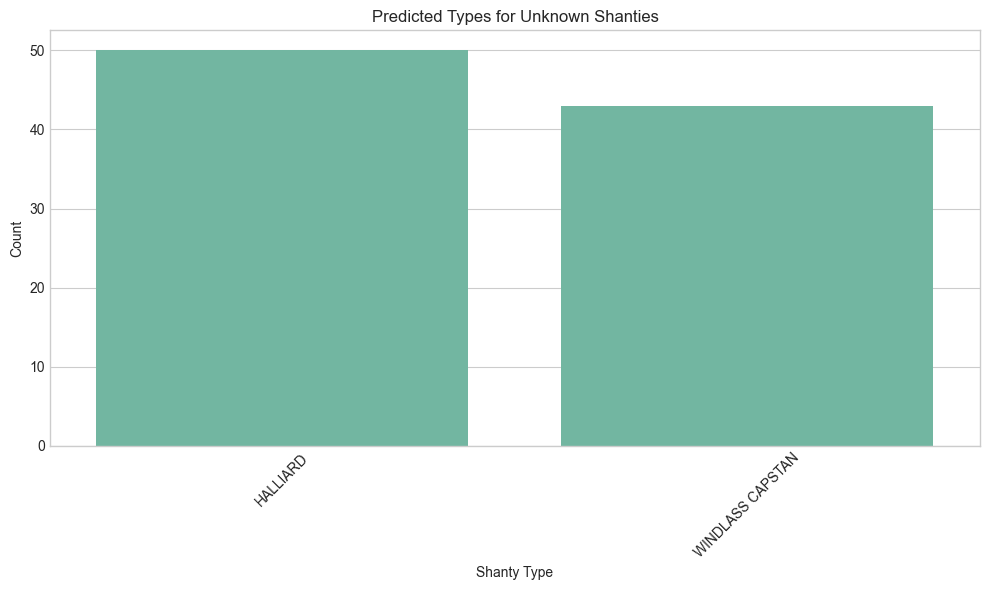

Predictions saved to 'unknown_shanty_predictions.csv'
Complete dataset with predictions saved to 'complete_shanty_dataset_with_predictions.csv'


In [94]:
# Check if we have any unknown shanties
unknown_shanties = df_original[df_original['shanty_type'] == 'Unknown']

if len(unknown_shanties) > 0:
    print(f"\n=== Predicting Types for {len(unknown_shanties)} Unknown Shanties ===")
    
    # Extract features for unknown shanties
    X_unknown = unknown_shanties[feature_cols].values
    X_unknown_scaled = scaler.transform(X_unknown)
    
    # Make predictions with the final model
    y_unknown_pred = final_model.predict(X_unknown_scaled)
    
    # Get prediction probabilities
    y_unknown_proba = final_model.predict_proba(X_unknown_scaled)
    
    # Create a DataFrame with predictions
    unknown_predictions = pd.DataFrame({
        'filename': unknown_shanties['filename'].values,
        'shanty_name': unknown_shanties['shanty_name'].values,
        'predicted_type': y_unknown_pred
    })
    
    # Add prediction confidence (max probability)
    unknown_predictions['confidence'] = np.max(y_unknown_proba, axis=1)
    
    # Add classification (high/low confidence)
    confidence_threshold = 0.6
    unknown_predictions['classification_status'] = unknown_predictions['confidence'].apply(
        lambda conf: 'High Confidence' if conf >= confidence_threshold else 'Low Confidence'
    )
    
    # Display predictions
    print("\nPredictions for Unknown Shanties:")
    print(unknown_predictions)
    
    # Plot confidence distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(unknown_predictions['confidence'], bins=10, kde=True)
    plt.axvline(x=confidence_threshold, color='red', linestyle='--', 
                label=f'Threshold ({confidence_threshold})')
    plt.title('Prediction Confidence for Unknown Shanties')
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Visualize predictions by type
    plt.figure(figsize=(10, 6))
    type_counts = unknown_predictions['predicted_type'].value_counts()
    sns.barplot(x=type_counts.index, y=type_counts.values)
    plt.title('Predicted Types for Unknown Shanties')
    plt.xlabel('Shanty Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Save predictions to a CSV file
    unknown_predictions.to_csv('unknown_shanty_predictions.csv', index=False)
    print("Predictions saved to 'unknown_shanty_predictions.csv'")
    
    # Create a comprehensive dataset with all shanties (including predicted types)
    complete_dataset = df_original.copy()
    
    # Update unknown shanties with predictions where confidence is high
    for i, row in unknown_predictions.iterrows():
        if row['classification_status'] == 'High Confidence':
            idx = complete_dataset[
                (complete_dataset['shanty_name'] == row['shanty_name']) & 
                (complete_dataset['shanty_type'] == 'Unknown')
            ].index
            complete_dataset.loc[idx, 'shanty_type'] = row['predicted_type']
        else:
            idx = complete_dataset[
                (complete_dataset['shanty_name'] == row['shanty_name']) & 
                (complete_dataset['shanty_type'] == 'Unknown')
            ].index
            complete_dataset.loc[idx, 'shanty_type'] = f"Unknown (Likely {row['predicted_type']})"
    
    # Save the updated dataset
    complete_dataset.to_csv('complete_shanty_dataset_with_predictions.csv', index=False)
    print("Complete dataset with predictions saved to 'complete_shanty_dataset_with_predictions.csv'")
else:
    print("No unknown shanties found in the dataset")

## 8. Feature Importance Visualization for the Final Model

Let's examine which features were most important for our final model's classification decisions.

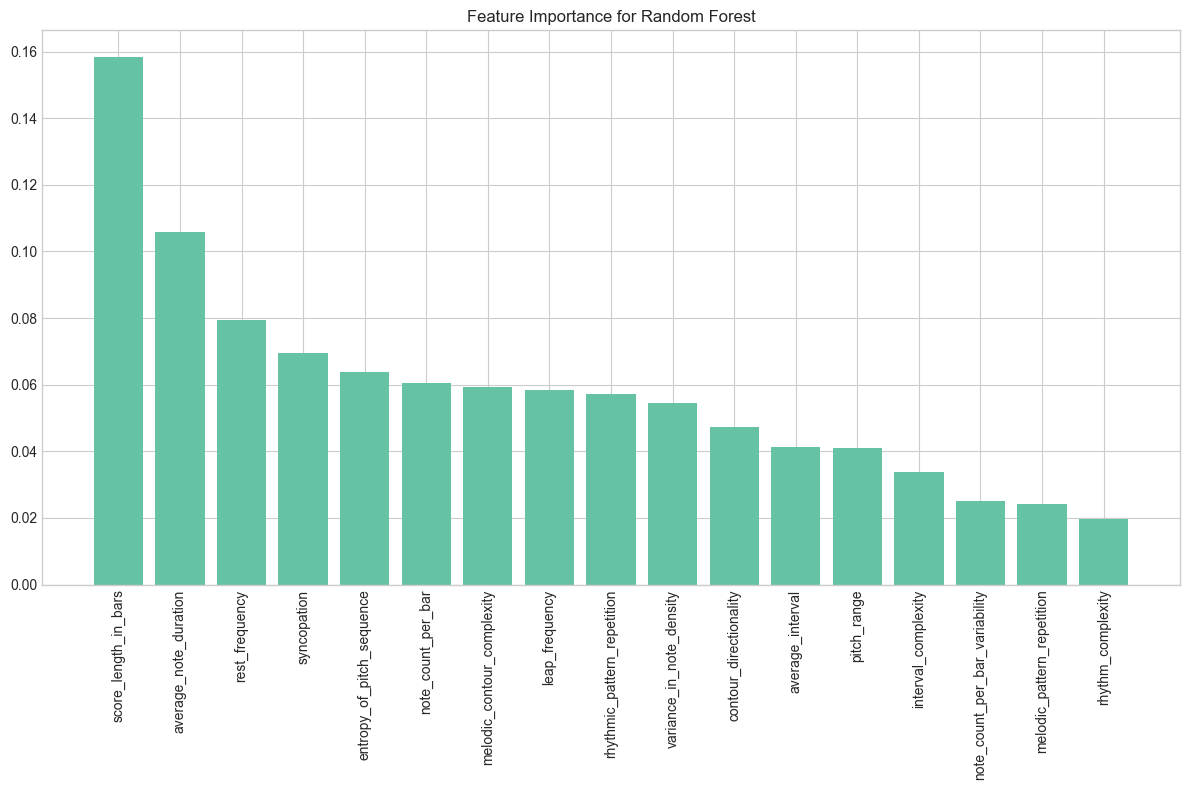


Feature ranking:
1. score_length_in_bars (0.1584)
2. average_note_duration (0.1059)
3. rest_frequency (0.0793)
4. syncopation (0.0697)
5. entropy_of_pitch_sequence (0.0639)
6. note_count_per_bar (0.0606)
7. melodic_contour_complexity (0.0593)
8. leap_frequency (0.0585)
9. rhythmic_pattern_repetition (0.0572)
10. variance_in_note_density (0.0546)
11. contour_directionality (0.0474)
12. average_interval (0.0414)
13. pitch_range (0.0409)
14. interval_complexity (0.0337)
15. note_count_per_bar_variability (0.0250)
16. melodic_pattern_repetition (0.0243)
17. rhythm_complexity (0.0198)


In [95]:
# Visualize feature importance from the final model
if hasattr(final_model, 'feature_importances_'):
    # For tree-based models
    importances = final_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title(f'Feature Importance for {final_model_name}')
    plt.bar(range(X.shape[1]), importances[indices], align='center')
    plt.xticks(range(X.shape[1]), [feature_cols[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
    
    # Print feature ranking
    print("\nFeature ranking:")
    for i in range(X.shape[1]):
        print(f"{i+1}. {feature_cols[indices[i]]} ({importances[indices[i]]:.4f})")
elif hasattr(final_model, 'coef_'):
    # For linear models
    importances = np.abs(final_model.coef_).mean(axis=0)
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title(f'Feature Importance for {final_model_name}')
    plt.bar(range(X.shape[1]), importances[indices], align='center')
    plt.xticks(range(X.shape[1]), [feature_cols[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
    
    # Print feature ranking
    print("\nFeature ranking:")
    for i in range(X.shape[1]):
        print(f"{i+1}. {feature_cols[indices[i]]} ({importances[indices[i]]:.4f})")
elif hasattr(final_model, 'estimators_') and hasattr(final_model.estimators_[0], 'feature_importances_'):
    # For ensemble models with base estimators having feature importances
    importances = np.mean([est.feature_importances_ for est in final_model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title(f'Feature Importance for {final_model_name}')
    plt.bar(range(X.shape[1]), importances[indices], align='center')
    plt.xticks(range(X.shape[1]), [feature_cols[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
    
    # Print feature ranking
    print("\nFeature ranking:")
    for i in range(X.shape[1]):
        print(f"{i+1}. {feature_cols[indices[i]]} ({importances[indices[i]]:.4f})")
else:
    print("\nFeature importance not directly available for this model type")
    
    # Try using permutation importance as an alternative
    try:
        from sklearn.inspection import permutation_importance
        
        result = permutation_importance(final_model, X_test_scaled, y_test, 
                                        n_repeats=10, random_state=42)
        importances = result.importances_mean
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(12, 8))
        plt.title(f'Permutation Feature Importance for {final_model_name}')
        plt.bar(range(X.shape[1]), importances[indices], align='center')
        plt.xticks(range(X.shape[1]), [feature_cols[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.show()
        
        # Print feature ranking
        print("\nFeature ranking (permutation importance):")
        for i in range(X.shape[1]):
            print(f"{i+1}. {feature_cols[indices[i]]} ({importances[indices[i]]:.4f})")
    except:
        print("Could not compute permutation importance")

## Summary

We've performed a comprehensive machine learning analysis for shanty type classification:

1. **Feature Selection**: Identified the most informative musical features
2. **Model Comparison**: Trained and evaluated multiple classification algorithms
3. **Hyperparameter Tuning**: Optimized model parameters for best performance
4. **Model Evaluation**: Thoroughly assessed model performance with various metrics
5. **Ensemble Model**: Combined top models to potentially improve predictions
6. **Unknown Shanty Classification**: Applied our model to predict unknown shanty types

The results provide insights into which musical features best distinguish different shanty types,
and offer predictions for previously unclassified shanties in the dataset.